In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["NVIDIA_VISIBLE_DEVICES"] = "1"

In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datasets import load_dataset
from torchvision import transforms
import torch
import torch.nn.functional as F
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from accelerate import Accelerator, notebook_launcher
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import math
import os
import glob

In [3]:
print('CUDA availability: {}'.format(torch.cuda.is_available()))
print('Num cores: {}'.format(torch.cuda.device_count()))
print('Current Device: {}'.format(torch.cuda.current_device()))

CUDA availability: True
Num cores: 1
Current Device: 0


# Set Configs

In [4]:
@dataclass
class TrainingConfig:
    # image_size = 128  # the generated image resolution
    image_size = 128
#     image_format='RGBA'
    image_format='L'
    channels=1
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 1000
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 25
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    # mixed_precision = 'no'  # requires a GPU
    output_dir = 'model_230402'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

DIR="../images_1_128/"
config = TrainingConfig()

# Create the Dataset

In [5]:
dataset = load_dataset("imagefolder", data_dir=DIR)

Resolving data files:   0%|          | 0/3067 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /mas/u/doorleyr/.cache/huggingface/datasets/imagefolder/default-8b5064cd38c07bfd/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
type(dataset['train'][0]['image'])

PIL.PngImagePlugin.PngImageFile

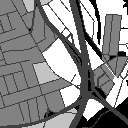

In [9]:
dataset['train'][0]['image']

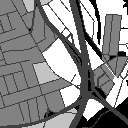

In [7]:
dataset['train'][0]['image'].getchannel(0)

In [10]:
dataset['train'][0]['image'].size

(128, 128)

# Plot a few example images

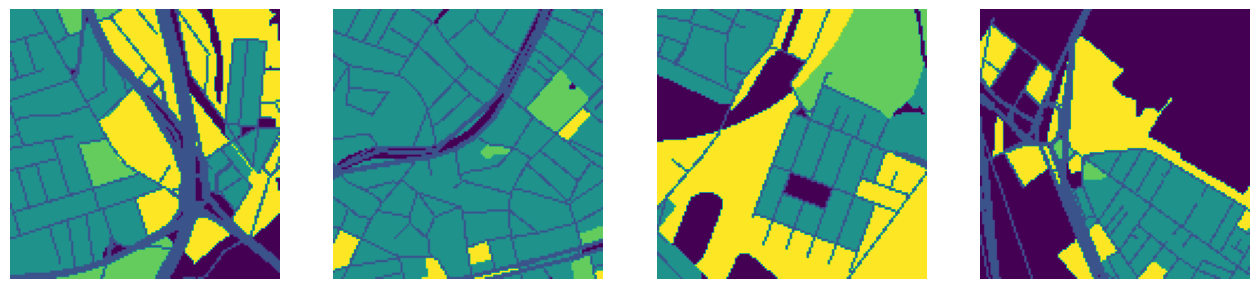

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Apply Transforms

In [12]:
preprocess = transforms.Compose(
    [
        # transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [13]:
def transform(examples):
    images = [preprocess(image.convert(config.image_format)) for image in examples["image"]]
    return {"images": images}

dataset["train"].set_transform(transform)

In [14]:
dataset["train"][0]['images'].shape

torch.Size([1, 128, 128])

In [18]:
# plt.imshow(dataset["train"][0]['images'][0, :, :])
# plt.colorbar()

# Plot transformed images

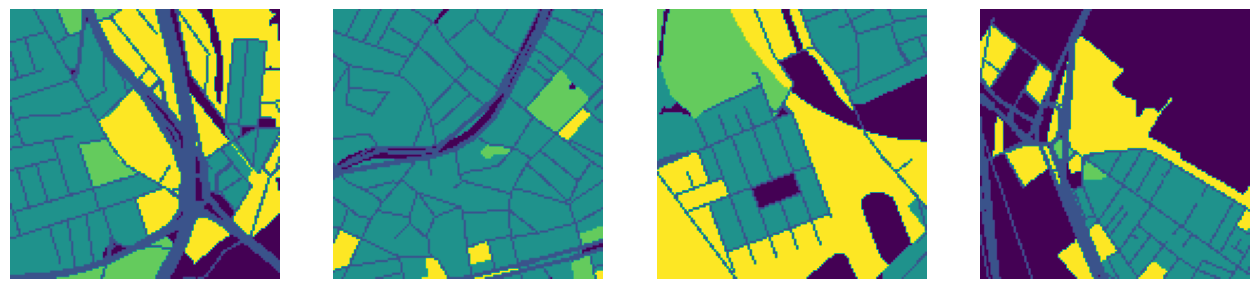

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

# Set up Dataloader

In [19]:
train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=config.train_batch_size, shuffle=True)

# Diffusion Model

In [20]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 
                         128, 
                        256, 
                        256, 
                        512,
                        512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
         "DownBlock2D", 
         "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
         "UpBlock2D", 
         "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [21]:
sample_image = dataset["train"][0]['images'].unsqueeze(0)

In [22]:
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 1, 128, 128])


In [23]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 128, 128])


## Define the noise scheduler

In [24]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

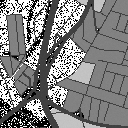

In [38]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([0])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)


if config.image_format=='L':
    noised_image=Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0][:,:,0],
                   mode='L')
else:
    noised_image=Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
noised_image

In [39]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1074, grad_fn=<MseLossBackward0>)


## Set up training

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [41]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Model evaluation with DDPMPipeline

In [42]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new(config.image_format, size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Training Loop

In [43]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        print(epoch)
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            print(logs)
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

# Train Model

In [44]:
%load_ext tensorboard

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.
0


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 1.1322376728057861, 'lr': 2.0000000000000002e-07, 'step': 0}
{'loss': 1.1135447025299072, 'lr': 4.0000000000000003e-07, 'step': 1}
{'loss': 1.120011806488037, 'lr': 6.000000000000001e-07, 'step': 2}
{'loss': 1.1238605976104736, 'lr': 8.000000000000001e-07, 'step': 3}
{'loss': 1.110870361328125, 'lr': 1.0000000000000002e-06, 'step': 4}
{'loss': 1.1056814193725586, 'lr': 1.2000000000000002e-06, 'step': 5}
{'loss': 1.0854427814483643, 'lr': 1.4000000000000001e-06, 'step': 6}
{'loss': 1.0785642862319946, 'lr': 1.6000000000000001e-06, 'step': 7}
{'loss': 1.075769066810608, 'lr': 1.8e-06, 'step': 8}
{'loss': 1.0475478172302246, 'lr': 2.0000000000000003e-06, 'step': 9}
{'loss': 1.0395848751068115, 'lr': 2.2e-06, 'step': 10}
{'loss': 1.0311951637268066, 'lr': 2.4000000000000003e-06, 'step': 11}
{'loss': 1.0042130947113037, 'lr': 2.6e-06, 'step': 12}
{'loss': 0.9897303581237793, 'lr': 2.8000000000000003e-06, 'step': 13}
{'loss': 0.969270646572113, 'lr': 3e-06, 'step': 14}
{'loss': 0.93

{'loss': 0.045455388724803925, 'lr': 2.6200000000000003e-05, 'step': 130}
{'loss': 0.1119871735572815, 'lr': 2.64e-05, 'step': 131}
{'loss': 0.10719910264015198, 'lr': 2.6600000000000003e-05, 'step': 132}
{'loss': 0.03525008261203766, 'lr': 2.6800000000000004e-05, 'step': 133}
{'loss': 0.07345734536647797, 'lr': 2.7000000000000002e-05, 'step': 134}
{'loss': 0.1269921362400055, 'lr': 2.7200000000000004e-05, 'step': 135}
{'loss': 0.061666764318943024, 'lr': 2.7400000000000002e-05, 'step': 136}
{'loss': 0.08408159762620926, 'lr': 2.7600000000000003e-05, 'step': 137}
{'loss': 0.07418322563171387, 'lr': 2.7800000000000005e-05, 'step': 138}
{'loss': 0.04943443834781647, 'lr': 2.8000000000000003e-05, 'step': 139}
{'loss': 0.1469763219356537, 'lr': 2.8199999999999998e-05, 'step': 140}
{'loss': 0.10106679797172546, 'lr': 2.84e-05, 'step': 141}
{'loss': 0.0374276340007782, 'lr': 2.86e-05, 'step': 142}
{'loss': 0.13158845901489258, 'lr': 2.88e-05, 'step': 143}
{'loss': 0.03807467967271805, 'lr': 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03324146941304207, 'lr': 3.86e-05, 'step': 192}
{'loss': 0.04352173954248428, 'lr': 3.88e-05, 'step': 193}
{'loss': 0.0708305686712265, 'lr': 3.9000000000000006e-05, 'step': 194}
{'loss': 0.1218043714761734, 'lr': 3.9200000000000004e-05, 'step': 195}
{'loss': 0.08054830878973007, 'lr': 3.94e-05, 'step': 196}
{'loss': 0.03648674115538597, 'lr': 3.960000000000001e-05, 'step': 197}
{'loss': 0.07955729961395264, 'lr': 3.9800000000000005e-05, 'step': 198}
{'loss': 0.02706390991806984, 'lr': 4e-05, 'step': 199}
{'loss': 0.07629704475402832, 'lr': 4.02e-05, 'step': 200}
{'loss': 0.04901762306690216, 'lr': 4.0400000000000006e-05, 'step': 201}
{'loss': 0.09232297539710999, 'lr': 4.0600000000000004e-05, 'step': 202}
{'loss': 0.09369450062513351, 'lr': 4.08e-05, 'step': 203}
{'loss': 0.07834567129611969, 'lr': 4.1e-05, 'step': 204}
{'loss': 0.09755135327577591, 'lr': 4.12e-05, 'step': 205}
{'loss': 0.08421781659126282, 'lr': 4.14e-05, 'step': 206}
{'loss': 0.06406770646572113, 'lr': 4.

{'loss': 0.10371015220880508, 'lr': 6.42e-05, 'step': 320}
{'loss': 0.12360847741365433, 'lr': 6.440000000000001e-05, 'step': 321}
{'loss': 0.03248320519924164, 'lr': 6.460000000000001e-05, 'step': 322}
{'loss': 0.029589496552944183, 'lr': 6.48e-05, 'step': 323}
{'loss': 0.10646151006221771, 'lr': 6.500000000000001e-05, 'step': 324}
{'loss': 0.03402599319815636, 'lr': 6.52e-05, 'step': 325}
{'loss': 0.06309905648231506, 'lr': 6.54e-05, 'step': 326}
{'loss': 0.07047615945339203, 'lr': 6.560000000000001e-05, 'step': 327}
{'loss': 0.060823939740657806, 'lr': 6.58e-05, 'step': 328}
{'loss': 0.09357712417840958, 'lr': 6.6e-05, 'step': 329}
{'loss': 0.09504663199186325, 'lr': 6.620000000000001e-05, 'step': 330}
{'loss': 0.049430474638938904, 'lr': 6.64e-05, 'step': 331}
{'loss': 0.04352525621652603, 'lr': 6.66e-05, 'step': 332}
{'loss': 0.0862671434879303, 'lr': 6.680000000000001e-05, 'step': 333}
{'loss': 0.11401787400245667, 'lr': 6.7e-05, 'step': 334}
{'loss': 0.043365657329559326, 'lr': 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.057637982070446014, 'lr': 7.7e-05, 'step': 384}
{'loss': 0.1047913059592247, 'lr': 7.72e-05, 'step': 385}
{'loss': 0.041051432490348816, 'lr': 7.740000000000001e-05, 'step': 386}
{'loss': 0.01656154915690422, 'lr': 7.76e-05, 'step': 387}
{'loss': 0.02185237780213356, 'lr': 7.780000000000001e-05, 'step': 388}
{'loss': 0.1003456562757492, 'lr': 7.800000000000001e-05, 'step': 389}
{'loss': 0.12462851405143738, 'lr': 7.82e-05, 'step': 390}
{'loss': 0.05347520858049393, 'lr': 7.840000000000001e-05, 'step': 391}
{'loss': 0.06280099600553513, 'lr': 7.860000000000001e-05, 'step': 392}
{'loss': 0.04130035638809204, 'lr': 7.88e-05, 'step': 393}
{'loss': 0.05579732358455658, 'lr': 7.900000000000001e-05, 'step': 394}
{'loss': 0.08143538981676102, 'lr': 7.920000000000001e-05, 'step': 395}
{'loss': 0.052338987588882446, 'lr': 7.94e-05, 'step': 396}
{'loss': 0.036570485681295395, 'lr': 7.960000000000001e-05, 'step': 397}
{'loss': 0.01712413690984249, 'lr': 7.98e-05, 'step': 398}
{'loss': 0

{'loss': 0.05764131620526314, 'lr': 9.999999868126277e-05, 'step': 513}
{'loss': 0.030952952802181244, 'lr': 9.99999984861435e-05, 'step': 514}
{'loss': 0.05572030320763588, 'lr': 9.999999827756771e-05, 'step': 515}
{'loss': 0.08287349343299866, 'lr': 9.999999805553541e-05, 'step': 516}
{'loss': 0.061548735946416855, 'lr': 9.999999782004663e-05, 'step': 517}
{'loss': 0.022877003997564316, 'lr': 9.999999757110134e-05, 'step': 518}
{'loss': 0.10715989768505096, 'lr': 9.999999730869956e-05, 'step': 519}
{'loss': 0.028626538813114166, 'lr': 9.999999703284126e-05, 'step': 520}
{'loss': 0.06267067044973373, 'lr': 9.999999674352646e-05, 'step': 521}
{'loss': 0.026811694726347923, 'lr': 9.999999644075516e-05, 'step': 522}
{'loss': 0.07296697050333023, 'lr': 9.999999612452736e-05, 'step': 523}
{'loss': 0.09607856720685959, 'lr': 9.999999579484307e-05, 'step': 524}
{'loss': 0.06441429257392883, 'lr': 9.999999545170227e-05, 'step': 525}
{'loss': 0.038336776196956635, 'lr': 9.999999509510497e-05, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03807109594345093, 'lr': 9.999996010820395e-05, 'step': 576}
{'loss': 0.04527047276496887, 'lr': 9.999995906532529e-05, 'step': 577}
{'loss': 0.06459694355726242, 'lr': 9.999995800899016e-05, 'step': 578}
{'loss': 0.05356242135167122, 'lr': 9.999995693919851e-05, 'step': 579}
{'loss': 0.068261057138443, 'lr': 9.999995585595038e-05, 'step': 580}
{'loss': 0.10407507419586182, 'lr': 9.999995475924577e-05, 'step': 581}
{'loss': 0.04166819155216217, 'lr': 9.999995364908466e-05, 'step': 582}
{'loss': 0.0814853236079216, 'lr': 9.999995252546706e-05, 'step': 583}
{'loss': 0.03984001278877258, 'lr': 9.999995138839298e-05, 'step': 584}
{'loss': 0.016949478536844254, 'lr': 9.99999502378624e-05, 'step': 585}
{'loss': 0.05387713760137558, 'lr': 9.999994907387533e-05, 'step': 586}
{'loss': 0.0319678857922554, 'lr': 9.999994789643177e-05, 'step': 587}
{'loss': 0.057598717510700226, 'lr': 9.999994670553172e-05, 'step': 588}
{'loss': 0.06224560737609863, 'lr': 9.99999455011752e-05, 'step': 5

{'loss': 0.054328687489032745, 'lr': 9.999975454686885e-05, 'step': 690}
{'loss': 0.07122387737035751, 'lr': 9.999975196995289e-05, 'step': 691}
{'loss': 0.023699726909399033, 'lr': 9.999974937958046e-05, 'step': 692}
{'loss': 0.06307321786880493, 'lr': 9.999974677575163e-05, 'step': 693}
{'loss': 0.04443801939487457, 'lr': 9.999974415846636e-05, 'step': 694}
{'loss': 0.04591396450996399, 'lr': 9.999974152772464e-05, 'step': 695}
{'loss': 0.0294273030012846, 'lr': 9.99997388835265e-05, 'step': 696}
{'loss': 0.07183228433132172, 'lr': 9.999973622587194e-05, 'step': 697}
{'loss': 0.09533898532390594, 'lr': 9.999973355476092e-05, 'step': 698}
{'loss': 0.07161127030849457, 'lr': 9.999973087019348e-05, 'step': 699}
{'loss': 0.037739723920822144, 'lr': 9.999972817216963e-05, 'step': 700}
{'loss': 0.03811492770910263, 'lr': 9.999972546068931e-05, 'step': 701}
{'loss': 0.062264230102300644, 'lr': 9.99997227357526e-05, 'step': 702}
{'loss': 0.04589304327964783, 'lr': 9.999971999735945e-05, 'ste

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0471501462161541, 'lr': 9.999951313780512e-05, 'step': 768}
{'loss': 0.060293473303318024, 'lr': 9.999950951128954e-05, 'step': 769}
{'loss': 0.06059945374727249, 'lr': 9.999950587131759e-05, 'step': 770}
{'loss': 0.03596533089876175, 'lr': 9.999950221788927e-05, 'step': 771}
{'loss': 0.07182352989912033, 'lr': 9.999949855100457e-05, 'step': 772}
{'loss': 0.05168894678354263, 'lr': 9.999949487066351e-05, 'step': 773}
{'loss': 0.0365387499332428, 'lr': 9.99994911768661e-05, 'step': 774}
{'loss': 0.07875615358352661, 'lr': 9.999948746961231e-05, 'step': 775}
{'loss': 0.06419054418802261, 'lr': 9.999948374890216e-05, 'step': 776}
{'loss': 0.031244371086359024, 'lr': 9.999948001473563e-05, 'step': 777}
{'loss': 0.028100784868001938, 'lr': 9.999947626711276e-05, 'step': 778}
{'loss': 0.04595142602920532, 'lr': 9.999947250603352e-05, 'step': 779}
{'loss': 0.0565890334546566, 'lr': 9.999946873149791e-05, 'step': 780}
{'loss': 0.03279922902584076, 'lr': 9.999946494350597e-05, 'step'

{'loss': 0.05332545191049576, 'lr': 9.999901304280685e-05, 'step': 882}
{'loss': 0.027480976656079292, 'lr': 9.999900788227223e-05, 'step': 883}
{'loss': 0.0567903071641922, 'lr': 9.999900270828137e-05, 'step': 884}
{'loss': 0.08895304799079895, 'lr': 9.999899752083429e-05, 'step': 885}
{'loss': 0.05184514820575714, 'lr': 9.999899231993095e-05, 'step': 886}
{'loss': 0.02841819077730179, 'lr': 9.99989871055714e-05, 'step': 887}
{'loss': 0.04503008723258972, 'lr': 9.99989818777556e-05, 'step': 888}
{'loss': 0.08113595843315125, 'lr': 9.999897663648359e-05, 'step': 889}
{'loss': 0.04135734587907791, 'lr': 9.999897138175533e-05, 'step': 890}
{'loss': 0.08540229499340057, 'lr': 9.999896611357087e-05, 'step': 891}
{'loss': 0.0204571895301342, 'lr': 9.999896083193019e-05, 'step': 892}
{'loss': 0.05326005816459656, 'lr': 9.999895553683327e-05, 'step': 893}
{'loss': 0.07301744818687439, 'lr': 9.999895022828012e-05, 'step': 894}
{'loss': 0.02599642425775528, 'lr': 9.999894490627077e-05, 'step': 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03304918855428696, 'lr': 9.999857011214228e-05, 'step': 960}
{'loss': 0.039290666580200195, 'lr': 9.999856390202576e-05, 'step': 961}
{'loss': 0.06023464351892471, 'lr': 9.999855767845311e-05, 'step': 962}
{'loss': 0.034867752343416214, 'lr': 9.999855144142436e-05, 'step': 963}
{'loss': 0.03480607271194458, 'lr': 9.999854519093949e-05, 'step': 964}
{'loss': 0.02577083557844162, 'lr': 9.999853892699851e-05, 'step': 965}
{'loss': 0.04208497703075409, 'lr': 9.999853264960141e-05, 'step': 966}
{'loss': 0.033707402646541595, 'lr': 9.999852635874821e-05, 'step': 967}
{'loss': 0.060804154723882675, 'lr': 9.99985200544389e-05, 'step': 968}
{'loss': 0.0230459775775671, 'lr': 9.999851373667351e-05, 'step': 969}
{'loss': 0.011835730634629726, 'lr': 9.999850740545198e-05, 'step': 970}
{'loss': 0.03277416527271271, 'lr': 9.999850106077437e-05, 'step': 971}
{'loss': 0.04723756015300751, 'lr': 9.999849470264067e-05, 'step': 972}
{'loss': 0.042973313480615616, 'lr': 9.999848833105085e-05, '

{'loss': 0.03489171341061592, 'lr': 9.99977832190886e-05, 'step': 1073}
{'loss': 0.06148282438516617, 'lr': 9.999777548844242e-05, 'step': 1074}
{'loss': 0.02322811260819435, 'lr': 9.999776774434034e-05, 'step': 1075}
{'loss': 0.05174341797828674, 'lr': 9.999775998678235e-05, 'step': 1076}
{'loss': 0.05252169072628021, 'lr': 9.999775221576847e-05, 'step': 1077}
{'loss': 0.02977374754846096, 'lr': 9.999774443129868e-05, 'step': 1078}
{'loss': 0.037669308483600616, 'lr': 9.999773663337302e-05, 'step': 1079}
{'loss': 0.06473081558942795, 'lr': 9.999772882199144e-05, 'step': 1080}
{'loss': 0.02852356992661953, 'lr': 9.999772099715399e-05, 'step': 1081}
{'loss': 0.01854025572538376, 'lr': 9.999771315886063e-05, 'step': 1082}
{'loss': 0.055680714547634125, 'lr': 9.999770530711139e-05, 'step': 1083}
{'loss': 0.03819286823272705, 'lr': 9.999769744190628e-05, 'step': 1084}
{'loss': 0.035683464258909225, 'lr': 9.999768956324526e-05, 'step': 1085}
{'loss': 0.0405283197760582, 'lr': 9.999768167112

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.04769038036465645, 'lr': 9.99971310405714e-05, 'step': 1152}
{'loss': 0.030532609671354294, 'lr': 9.999712224691554e-05, 'step': 1153}
{'loss': 0.055290088057518005, 'lr': 9.999711343980394e-05, 'step': 1154}
{'loss': 0.031136207282543182, 'lr': 9.999710461923663e-05, 'step': 1155}
{'loss': 0.03952206298708916, 'lr': 9.99970957852136e-05, 'step': 1156}
{'loss': 0.04743122309446335, 'lr': 9.999708693773481e-05, 'step': 1157}
{'loss': 0.05345941334962845, 'lr': 9.999707807680034e-05, 'step': 1158}
{'loss': 0.0396154411137104, 'lr': 9.999706920241014e-05, 'step': 1159}
{'loss': 0.02547387406229973, 'lr': 9.999706031456424e-05, 'step': 1160}
{'loss': 0.043853841722011566, 'lr': 9.999705141326262e-05, 'step': 1161}
{'loss': 0.03901023417711258, 'lr': 9.999704249850528e-05, 'step': 1162}
{'loss': 0.03356936573982239, 'lr': 9.999703357029224e-05, 'step': 1163}
{'loss': 0.06467404961585999, 'lr': 9.99970246286235e-05, 'step': 1164}
{'loss': 0.028752179816365242, 'lr': 9.999701567349

{'loss': 0.02930547669529915, 'lr': 9.999606251087264e-05, 'step': 1264}
{'loss': 0.026081973686814308, 'lr': 9.999605221019081e-05, 'step': 1265}
{'loss': 0.04008106514811516, 'lr': 9.999604189605354e-05, 'step': 1266}
{'loss': 0.02826741524040699, 'lr': 9.999603156846083e-05, 'step': 1267}
{'loss': 0.053862135857343674, 'lr': 9.99960212274127e-05, 'step': 1268}
{'loss': 0.035208649933338165, 'lr': 9.999601087290911e-05, 'step': 1269}
{'loss': 0.021877337247133255, 'lr': 9.999600050495011e-05, 'step': 1270}
{'loss': 0.03276897594332695, 'lr': 9.999599012353568e-05, 'step': 1271}
{'loss': 0.026847463101148605, 'lr': 9.999597972866584e-05, 'step': 1272}
{'loss': 0.0697832852602005, 'lr': 9.999596932034057e-05, 'step': 1273}
{'loss': 0.03456701710820198, 'lr': 9.999595889855986e-05, 'step': 1274}
{'loss': 0.0743241161108017, 'lr': 9.999594846332376e-05, 'step': 1275}
{'loss': 0.03618983179330826, 'lr': 9.999593801463226e-05, 'step': 1276}
{'loss': 0.06376181542873383, 'lr': 9.99959275524

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03544338047504425, 'lr': 9.999519593736977e-05, 'step': 1344}
{'loss': 0.04241081327199936, 'lr': 9.999518456026183e-05, 'step': 1345}
{'loss': 0.03414401039481163, 'lr': 9.999517316969865e-05, 'step': 1346}
{'loss': 0.03414151817560196, 'lr': 9.999516176568029e-05, 'step': 1347}
{'loss': 0.037577636539936066, 'lr': 9.999515034820672e-05, 'step': 1348}
{'loss': 0.04297702759504318, 'lr': 9.999513891727797e-05, 'step': 1349}
{'loss': 0.03494209051132202, 'lr': 9.9995127472894e-05, 'step': 1350}
{'loss': 0.04727788269519806, 'lr': 9.999511601505484e-05, 'step': 1351}
{'loss': 0.025769587606191635, 'lr': 9.999510454376051e-05, 'step': 1352}
{'loss': 0.04171283543109894, 'lr': 9.999509305901098e-05, 'step': 1353}
{'loss': 0.03605460375547409, 'lr': 9.999508156080629e-05, 'step': 1354}
{'loss': 0.024627137929201126, 'lr': 9.999507004914641e-05, 'step': 1355}
{'loss': 0.01691683568060398, 'lr': 9.999505852403135e-05, 'step': 1356}
{'loss': 0.03469758480787277, 'lr': 9.999504698546

{'loss': 0.02964911237359047, 'lr': 9.999383806443678e-05, 'step': 1456}
{'loss': 0.01762482337653637, 'lr': 9.999382518036557e-05, 'step': 1457}
{'loss': 0.0341416634619236, 'lr': 9.999381228283955e-05, 'step': 1458}
{'loss': 0.04203176125884056, 'lr': 9.999379937185868e-05, 'step': 1459}
{'loss': 0.01828833669424057, 'lr': 9.999378644742296e-05, 'step': 1460}
{'loss': 0.04071846604347229, 'lr': 9.999377350953243e-05, 'step': 1461}
{'loss': 0.034586064517498016, 'lr': 9.999376055818707e-05, 'step': 1462}
{'loss': 0.05277707800269127, 'lr': 9.999374759338688e-05, 'step': 1463}
{'loss': 0.014308474957942963, 'lr': 9.999373461513188e-05, 'step': 1464}
{'loss': 0.03759388253092766, 'lr': 9.999372162342207e-05, 'step': 1465}
{'loss': 0.037052154541015625, 'lr': 9.999370861825743e-05, 'step': 1466}
{'loss': 0.034588053822517395, 'lr': 9.999369559963798e-05, 'step': 1467}
{'loss': 0.030674414709210396, 'lr': 9.999368256756374e-05, 'step': 1468}
{'loss': 0.025497857481241226, 'lr': 9.99936695

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.04449775815010071, 'lr': 9.999276482173596e-05, 'step': 1536}
{'loss': 0.02346811071038246, 'lr': 9.999275086128878e-05, 'step': 1537}
{'loss': 0.04667283222079277, 'lr': 9.999273688738706e-05, 'step': 1538}
{'loss': 0.07398510724306107, 'lr': 9.999272290003078e-05, 'step': 1539}
{'loss': 0.03577551618218422, 'lr': 9.999270889921997e-05, 'step': 1540}
{'loss': 0.02887999452650547, 'lr': 9.999269488495462e-05, 'step': 1541}
{'loss': 0.030131764709949493, 'lr': 9.999268085723473e-05, 'step': 1542}
{'loss': 0.024346882477402687, 'lr': 9.99926668160603e-05, 'step': 1543}
{'loss': 0.047005750238895416, 'lr': 9.999265276143135e-05, 'step': 1544}
{'loss': 0.03954499587416649, 'lr': 9.999263869334786e-05, 'step': 1545}
{'loss': 0.027795927599072456, 'lr': 9.999262461180987e-05, 'step': 1546}
{'loss': 0.04045817255973816, 'lr': 9.999261051681735e-05, 'step': 1547}
{'loss': 0.03224986046552658, 'lr': 9.999259640837031e-05, 'step': 1548}
{'loss': 0.03770643472671509, 'lr': 9.9992582286

{'loss': 0.041246846318244934, 'lr': 9.999111761904046e-05, 'step': 1648}
{'loss': 0.04898457229137421, 'lr': 9.999110215170773e-05, 'step': 1649}
{'loss': 0.023217007517814636, 'lr': 9.999108667092089e-05, 'step': 1650}
{'loss': 0.02723037451505661, 'lr': 9.999107117667995e-05, 'step': 1651}
{'loss': 0.02519001066684723, 'lr': 9.99910556689849e-05, 'step': 1652}
{'loss': 0.018909573554992676, 'lr': 9.999104014783575e-05, 'step': 1653}
{'loss': 0.028724391013383865, 'lr': 9.999102461323253e-05, 'step': 1654}
{'loss': 0.03510568290948868, 'lr': 9.999100906517522e-05, 'step': 1655}
{'loss': 0.03335222601890564, 'lr': 9.999099350366381e-05, 'step': 1656}
{'loss': 0.03267314285039902, 'lr': 9.999097792869834e-05, 'step': 1657}
{'loss': 0.03701045364141464, 'lr': 9.999096234027878e-05, 'step': 1658}
{'loss': 0.0170303788036108, 'lr': 9.999094673840517e-05, 'step': 1659}
{'loss': 0.03220348060131073, 'lr': 9.999093112307748e-05, 'step': 1660}
{'loss': 0.02048639953136444, 'lr': 9.99909154942

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.02078079618513584, 'lr': 9.998983771778955e-05, 'step': 1728}
{'loss': 0.042955510318279266, 'lr': 9.998982117414166e-05, 'step': 1729}
{'loss': 0.01767679862678051, 'lr': 9.998980461704002e-05, 'step': 1730}
{'loss': 0.028129246085882187, 'lr': 9.99897880464846e-05, 'step': 1731}
{'loss': 0.03066902607679367, 'lr': 9.998977146247544e-05, 'step': 1732}
{'loss': 0.028631018474698067, 'lr': 9.998975486501253e-05, 'step': 1733}
{'loss': 0.027957653626799583, 'lr': 9.998973825409587e-05, 'step': 1734}
{'loss': 0.01761850155889988, 'lr': 9.998972162972548e-05, 'step': 1735}
{'loss': 0.028116118162870407, 'lr': 9.998970499190134e-05, 'step': 1736}
{'loss': 0.035338565707206726, 'lr': 9.998968834062348e-05, 'step': 1737}
{'loss': 0.03182006627321243, 'lr': 9.998967167589189e-05, 'step': 1738}
{'loss': 0.024586638435721397, 'lr': 9.998965499770657e-05, 'step': 1739}
{'loss': 0.04488412290811539, 'lr': 9.998963830606753e-05, 'step': 1740}
{'loss': 0.03318100422620773, 'lr': 9.9989621

{'loss': 0.0501306876540184, 'lr': 9.998790120167376e-05, 'step': 1840}
{'loss': 0.03415630757808685, 'lr': 9.998788315123295e-05, 'step': 1841}
{'loss': 0.023701220750808716, 'lr': 9.99878650873389e-05, 'step': 1842}
{'loss': 0.05163154751062393, 'lr': 9.99878470099916e-05, 'step': 1843}
{'loss': 0.016448266804218292, 'lr': 9.998782891919108e-05, 'step': 1844}
{'loss': 0.02359602600336075, 'lr': 9.998781081493733e-05, 'step': 1845}
{'loss': 0.042293839156627655, 'lr': 9.998779269723036e-05, 'step': 1846}
{'loss': 0.010900923982262611, 'lr': 9.998777456607015e-05, 'step': 1847}
{'loss': 0.031271521002054214, 'lr': 9.998775642145675e-05, 'step': 1848}
{'loss': 0.037517402321100235, 'lr': 9.998773826339015e-05, 'step': 1849}
{'loss': 0.03937245160341263, 'lr': 9.998772009187034e-05, 'step': 1850}
{'loss': 0.024008285254240036, 'lr': 9.998770190689733e-05, 'step': 1851}
{'loss': 0.019017376005649567, 'lr': 9.998768370847112e-05, 'step': 1852}
{'loss': 0.01802445761859417, 'lr': 9.99876654

  0%|          | 0/1000 [00:00<?, ?it/s]

10


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03700762242078781, 'lr': 9.998641465457092e-05, 'step': 1920}
{'loss': 0.025178907439112663, 'lr': 9.998639552788646e-05, 'step': 1921}
{'loss': 0.012869379483163357, 'lr': 9.998637638774915e-05, 'step': 1922}
{'loss': 0.010341127403080463, 'lr': 9.998635723415902e-05, 'step': 1923}
{'loss': 0.03970056027173996, 'lr': 9.998633806711604e-05, 'step': 1924}
{'loss': 0.012401184067130089, 'lr': 9.998631888662024e-05, 'step': 1925}
{'loss': 0.045639120042324066, 'lr': 9.998629969267161e-05, 'step': 1926}
{'loss': 0.022029727697372437, 'lr': 9.998628048527018e-05, 'step': 1927}
{'loss': 0.05080299824476242, 'lr': 9.998626126441593e-05, 'step': 1928}
{'loss': 0.017193064093589783, 'lr': 9.998624203010889e-05, 'step': 1929}
{'loss': 0.04823426902294159, 'lr': 9.998622278234903e-05, 'step': 1930}
{'loss': 0.04199844226241112, 'lr': 9.998620352113639e-05, 'step': 1931}
{'loss': 0.035254113376140594, 'lr': 9.998618424647095e-05, 'step': 1932}
{'loss': 0.029242273420095444, 'lr': 9.9986

{'loss': 0.0358259454369545, 'lr': 9.998418884424743e-05, 'step': 2032}
{'loss': 0.033670853823423386, 'lr': 9.998416821087761e-05, 'step': 2033}
{'loss': 0.02186247706413269, 'lr': 9.998414756405556e-05, 'step': 2034}
{'loss': 0.028553692623972893, 'lr': 9.998412690378128e-05, 'step': 2035}
{'loss': 0.03295408561825752, 'lr': 9.998410623005474e-05, 'step': 2036}
{'loss': 0.04539395496249199, 'lr': 9.998408554287599e-05, 'step': 2037}
{'loss': 0.027515031397342682, 'lr': 9.998406484224503e-05, 'step': 2038}
{'loss': 0.019479762762784958, 'lr': 9.998404412816184e-05, 'step': 2039}
{'loss': 0.022054456174373627, 'lr': 9.998402340062644e-05, 'step': 2040}
{'loss': 0.021721752360463142, 'lr': 9.998400265963885e-05, 'step': 2041}
{'loss': 0.05951136723160744, 'lr': 9.998398190519907e-05, 'step': 2042}
{'loss': 0.031817927956581116, 'lr': 9.998396113730708e-05, 'step': 2043}
{'loss': 0.027020398527383804, 'lr': 9.998394035596292e-05, 'step': 2044}
{'loss': 0.02558465674519539, 'lr': 9.998391

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.02472037449479103, 'lr': 9.998249566604099e-05, 'step': 2112}
{'loss': 0.03187960386276245, 'lr': 9.99824739565097e-05, 'step': 2113}
{'loss': 0.021529318764805794, 'lr': 9.998245223352663e-05, 'step': 2114}
{'loss': 0.016498509794473648, 'lr': 9.998243049709178e-05, 'step': 2115}
{'loss': 0.033347807824611664, 'lr': 9.998240874720516e-05, 'step': 2116}
{'loss': 0.0648033618927002, 'lr': 9.998238698386676e-05, 'step': 2117}
{'loss': 0.021982355043292046, 'lr': 9.99823652070766e-05, 'step': 2118}
{'loss': 0.016196027398109436, 'lr': 9.99823434168347e-05, 'step': 2119}
{'loss': 0.03990643471479416, 'lr': 9.998232161314103e-05, 'step': 2120}
{'loss': 0.04722936451435089, 'lr': 9.998229979599562e-05, 'step': 2121}
{'loss': 0.05326283723115921, 'lr': 9.998227796539848e-05, 'step': 2122}
{'loss': 0.035138268023729324, 'lr': 9.99822561213496e-05, 'step': 2123}
{'loss': 0.03398595750331879, 'lr': 9.9982234263849e-05, 'step': 2124}
{'loss': 0.04268259555101395, 'lr': 9.99822123928966

{'loss': 0.029374483972787857, 'lr': 9.99799805835925e-05, 'step': 2224}
{'loss': 0.03094581514596939, 'lr': 9.99799573674984e-05, 'step': 2225}
{'loss': 0.03970039635896683, 'lr': 9.997993413795319e-05, 'step': 2226}
{'loss': 0.01634284295141697, 'lr': 9.997991089495686e-05, 'step': 2227}
{'loss': 0.03558732196688652, 'lr': 9.997988763850945e-05, 'step': 2228}
{'loss': 0.011449936777353287, 'lr': 9.997986436861095e-05, 'step': 2229}
{'loss': 0.010007880628108978, 'lr': 9.997984108526135e-05, 'step': 2230}
{'loss': 0.04640057682991028, 'lr': 9.997981778846069e-05, 'step': 2231}
{'loss': 0.024803487583994865, 'lr': 9.997979447820896e-05, 'step': 2232}
{'loss': 0.011194232851266861, 'lr': 9.997977115450615e-05, 'step': 2233}
{'loss': 0.023184265941381454, 'lr': 9.997974781735229e-05, 'step': 2234}
{'loss': 0.029149014502763748, 'lr': 9.997972446674739e-05, 'step': 2235}
{'loss': 0.02642689272761345, 'lr': 9.997970110269142e-05, 'step': 2236}
{'loss': 0.017472587525844574, 'lr': 9.9979677

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.022985298186540604, 'lr': 9.997808079108083e-05, 'step': 2304}
{'loss': 0.01721656508743763, 'lr': 9.997805649891812e-05, 'step': 2305}
{'loss': 0.03468489646911621, 'lr': 9.99780321933048e-05, 'step': 2306}
{'loss': 0.03295009583234787, 'lr': 9.997800787424088e-05, 'step': 2307}
{'loss': 0.029730603098869324, 'lr': 9.997798354172638e-05, 'step': 2308}
{'loss': 0.03201453387737274, 'lr': 9.997795919576132e-05, 'step': 2309}
{'loss': 0.02372184582054615, 'lr': 9.997793483634567e-05, 'step': 2310}
{'loss': 0.027860140427947044, 'lr': 9.997791046347948e-05, 'step': 2311}
{'loss': 0.03475804999470711, 'lr': 9.997788607716271e-05, 'step': 2312}
{'loss': 0.030470388010144234, 'lr': 9.99778616773954e-05, 'step': 2313}
{'loss': 0.02980039268732071, 'lr': 9.997783726417754e-05, 'step': 2314}
{'loss': 0.026230938732624054, 'lr': 9.997781283750916e-05, 'step': 2315}
{'loss': 0.03542405366897583, 'lr': 9.997778839739023e-05, 'step': 2316}
{'loss': 0.021226681768894196, 'lr': 9.997776394

{'loss': 0.02250988408923149, 'lr': 9.997527646145998e-05, 'step': 2416}
{'loss': 0.03130139410495758, 'lr': 9.997525066287192e-05, 'step': 2417}
{'loss': 0.03033427521586418, 'lr': 9.997522485083401e-05, 'step': 2418}
{'loss': 0.02503511868417263, 'lr': 9.997519902534627e-05, 'step': 2419}
{'loss': 0.010411460883915424, 'lr': 9.997517318640869e-05, 'step': 2420}
{'loss': 0.0269157774746418, 'lr': 9.997514733402129e-05, 'step': 2421}
{'loss': 0.020538417622447014, 'lr': 9.997512146818408e-05, 'step': 2422}
{'loss': 0.0231927577406168, 'lr': 9.997509558889706e-05, 'step': 2423}
{'loss': 0.02013060264289379, 'lr': 9.997506969616025e-05, 'step': 2424}
{'loss': 0.017810111865401268, 'lr': 9.997504378997365e-05, 'step': 2425}
{'loss': 0.02514096163213253, 'lr': 9.997501787033725e-05, 'step': 2426}
{'loss': 0.027500435709953308, 'lr': 9.997499193725108e-05, 'step': 2427}
{'loss': 0.039697736501693726, 'lr': 9.997496599071511e-05, 'step': 2428}
{'loss': 0.018772030249238014, 'lr': 9.997494003

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.021877754479646683, 'lr': 9.99731700734913e-05, 'step': 2496}
{'loss': 0.027044855058193207, 'lr': 9.997314319893815e-05, 'step': 2497}
{'loss': 0.0321878120303154, 'lr': 9.997311631093574e-05, 'step': 2498}
{'loss': 0.0336037315428257, 'lr': 9.997308940948405e-05, 'step': 2499}
{'loss': 0.016670849174261093, 'lr': 9.997306249458309e-05, 'step': 2500}
{'loss': 0.046573515981435776, 'lr': 9.997303556623287e-05, 'step': 2501}
{'loss': 0.027531161904335022, 'lr': 9.997300862443343e-05, 'step': 2502}
{'loss': 0.024921540170907974, 'lr': 9.997298166918474e-05, 'step': 2503}
{'loss': 0.022748664021492004, 'lr': 9.997295470048682e-05, 'step': 2504}
{'loss': 0.04083830118179321, 'lr': 9.997292771833969e-05, 'step': 2505}
{'loss': 0.026783717796206474, 'lr': 9.997290072274332e-05, 'step': 2506}
{'loss': 0.02765948511660099, 'lr': 9.997287371369774e-05, 'step': 2507}
{'loss': 0.03623919561505318, 'lr': 9.997284669120299e-05, 'step': 2508}
{'loss': 0.022145146504044533, 'lr': 9.9972819

{'loss': 0.014866285026073456, 'lr': 9.997007652452044e-05, 'step': 2608}
{'loss': 0.013327431865036488, 'lr': 9.997004814369435e-05, 'step': 2609}
{'loss': 0.02754056826233864, 'lr': 9.997001974941983e-05, 'step': 2610}
{'loss': 0.02009887620806694, 'lr': 9.996999134169687e-05, 'step': 2611}
{'loss': 0.045366279780864716, 'lr': 9.996996292052549e-05, 'step': 2612}
{'loss': 0.030921217054128647, 'lr': 9.99699344859057e-05, 'step': 2613}
{'loss': 0.022064659744501114, 'lr': 9.996990603783749e-05, 'step': 2614}
{'loss': 0.03799464553594589, 'lr': 9.996987757632088e-05, 'step': 2615}
{'loss': 0.020993847399950027, 'lr': 9.996984910135587e-05, 'step': 2616}
{'loss': 0.01640559732913971, 'lr': 9.996982061294247e-05, 'step': 2617}
{'loss': 0.02032991126179695, 'lr': 9.996979211108068e-05, 'step': 2618}
{'loss': 0.02831251174211502, 'lr': 9.996976359577054e-05, 'step': 2619}
{'loss': 0.02218293771147728, 'lr': 9.996973506701201e-05, 'step': 2620}
{'loss': 0.013393190689384937, 'lr': 9.9969706

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.022310633212327957, 'lr': 9.996776356199263e-05, 'step': 2688}
{'loss': 0.017491891980171204, 'lr': 9.996773410531568e-05, 'step': 2689}
{'loss': 0.022495558485388756, 'lr': 9.996770463519092e-05, 'step': 2690}
{'loss': 0.01279950886964798, 'lr': 9.996767515161833e-05, 'step': 2691}
{'loss': 0.019576238468289375, 'lr': 9.996764565459796e-05, 'step': 2692}
{'loss': 0.028197113424539566, 'lr': 9.996761614412978e-05, 'step': 2693}
{'loss': 0.023181114345788956, 'lr': 9.99675866202138e-05, 'step': 2694}
{'loss': 0.026473507285118103, 'lr': 9.996755708285007e-05, 'step': 2695}
{'loss': 0.015083790756762028, 'lr': 9.996752753203855e-05, 'step': 2696}
{'loss': 0.043491341173648834, 'lr': 9.996749796777926e-05, 'step': 2697}
{'loss': 0.011958071030676365, 'lr': 9.996746839007224e-05, 'step': 2698}
{'loss': 0.02523859590291977, 'lr': 9.996743879891746e-05, 'step': 2699}
{'loss': 0.02316608652472496, 'lr': 9.996740919431493e-05, 'step': 2700}
{'loss': 0.023606255650520325, 'lr': 9.996

{'loss': 0.013555429875850677, 'lr': 9.996438082436345e-05, 'step': 2800}
{'loss': 0.034721195697784424, 'lr': 9.996434986158093e-05, 'step': 2801}
{'loss': 0.033437881618738174, 'lr': 9.996431888535151e-05, 'step': 2802}
{'loss': 0.050020039081573486, 'lr': 9.996428789567518e-05, 'step': 2803}
{'loss': 0.04365643858909607, 'lr': 9.996425689255197e-05, 'step': 2804}
{'loss': 0.021679183468222618, 'lr': 9.996422587598187e-05, 'step': 2805}
{'loss': 0.009024281054735184, 'lr': 9.99641948459649e-05, 'step': 2806}
{'loss': 0.033123284578323364, 'lr': 9.996416380250107e-05, 'step': 2807}
{'loss': 0.027040814980864525, 'lr': 9.996413274559035e-05, 'step': 2808}
{'loss': 0.024927839636802673, 'lr': 9.996410167523283e-05, 'step': 2809}
{'loss': 0.03653252124786377, 'lr': 9.996407059142842e-05, 'step': 2810}
{'loss': 0.015191236510872841, 'lr': 9.996403949417721e-05, 'step': 2811}
{'loss': 0.026395026594400406, 'lr': 9.996400838347917e-05, 'step': 2812}
{'loss': 0.01752379722893238, 'lr': 9.996

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03267114236950874, 'lr': 9.996186131022391e-05, 'step': 2880}
{'loss': 0.018077250570058823, 'lr': 9.99618292717154e-05, 'step': 2881}
{'loss': 0.04292842745780945, 'lr': 9.996179721976067e-05, 'step': 2882}
{'loss': 0.02453501522541046, 'lr': 9.996176515435971e-05, 'step': 2883}
{'loss': 0.022448234260082245, 'lr': 9.996173307551254e-05, 'step': 2884}
{'loss': 0.025442715734243393, 'lr': 9.996170098321917e-05, 'step': 2885}
{'loss': 0.034921638667583466, 'lr': 9.99616688774796e-05, 'step': 2886}
{'loss': 0.023200612515211105, 'lr': 9.996163675829385e-05, 'step': 2887}
{'loss': 0.039666421711444855, 'lr': 9.996160462566192e-05, 'step': 2888}
{'loss': 0.029099855571985245, 'lr': 9.996157247958383e-05, 'step': 2889}
{'loss': 0.014467054978013039, 'lr': 9.996154032005956e-05, 'step': 2890}
{'loss': 0.028795143589377403, 'lr': 9.996150814708916e-05, 'step': 2891}
{'loss': 0.04131056368350983, 'lr': 9.99614759606726e-05, 'step': 2892}
{'loss': 0.0459609255194664, 'lr': 9.99614437

{'loss': 0.02246163785457611, 'lr': 9.995818941749724e-05, 'step': 2992}
{'loss': 0.030363082885742188, 'lr': 9.995815587306548e-05, 'step': 2993}
{'loss': 0.0388125404715538, 'lr': 9.995812231518846e-05, 'step': 2994}
{'loss': 0.0222015380859375, 'lr': 9.995808874386623e-05, 'step': 2995}
{'loss': 0.01629764772951603, 'lr': 9.995805515909876e-05, 'step': 2996}
{'loss': 0.012056082487106323, 'lr': 9.99580215608861e-05, 'step': 2997}
{'loss': 0.019780810922384262, 'lr': 9.995798794922821e-05, 'step': 2998}
{'loss': 0.01552753895521164, 'lr': 9.995795432412514e-05, 'step': 2999}
{'loss': 0.03931291773915291, 'lr': 9.995792068557688e-05, 'step': 3000}
{'loss': 0.0289770420640707, 'lr': 9.995788703358345e-05, 'step': 3001}
{'loss': 0.03505132347345352, 'lr': 9.995785336814483e-05, 'step': 3002}
{'loss': 0.02563909813761711, 'lr': 9.995781968926105e-05, 'step': 3003}
{'loss': 0.017100537195801735, 'lr': 9.995778599693214e-05, 'step': 3004}
{'loss': 0.03337977081537247, 'lr': 9.9957752291158

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.018766358494758606, 'lr': 9.995546337674255e-05, 'step': 3072}
{'loss': 0.028287863358855247, 'lr': 9.995542875672035e-05, 'step': 3073}
{'loss': 0.018584195524454117, 'lr': 9.995539412325366e-05, 'step': 3074}
{'loss': 0.02870866283774376, 'lr': 9.995535947634245e-05, 'step': 3075}
{'loss': 0.01758830063045025, 'lr': 9.995532481598674e-05, 'step': 3076}
{'loss': 0.027024364098906517, 'lr': 9.995529014218659e-05, 'step': 3077}
{'loss': 0.01937272772192955, 'lr': 9.995525545494194e-05, 'step': 3078}
{'loss': 0.016453783959150314, 'lr': 9.995522075425284e-05, 'step': 3079}
{'loss': 0.01596226543188095, 'lr': 9.995518604011929e-05, 'step': 3080}
{'loss': 0.029415208846330643, 'lr': 9.99551513125413e-05, 'step': 3081}
{'loss': 0.01110713928937912, 'lr': 9.995511657151886e-05, 'step': 3082}
{'loss': 0.01804903708398342, 'lr': 9.995508181705202e-05, 'step': 3083}
{'loss': 0.032731954008340836, 'lr': 9.995504704914076e-05, 'step': 3084}
{'loss': 0.027426915243268013, 'lr': 9.995501

{'loss': 0.034496936947107315, 'lr': 9.995150236534798e-05, 'step': 3184}
{'loss': 0.020758822560310364, 'lr': 9.995146623959978e-05, 'step': 3185}
{'loss': 0.023352134972810745, 'lr': 9.995143010040812e-05, 'step': 3186}
{'loss': 0.04312568157911301, 'lr': 9.995139394777304e-05, 'step': 3187}
{'loss': 0.035005003213882446, 'lr': 9.995135778169454e-05, 'step': 3188}
{'loss': 0.012957097962498665, 'lr': 9.995132160217262e-05, 'step': 3189}
{'loss': 0.020533304661512375, 'lr': 9.99512854092073e-05, 'step': 3190}
{'loss': 0.02258455567061901, 'lr': 9.99512492027986e-05, 'step': 3191}
{'loss': 0.03309459984302521, 'lr': 9.99512129829465e-05, 'step': 3192}
{'loss': 0.01970256119966507, 'lr': 9.995117674965103e-05, 'step': 3193}
{'loss': 0.03097677230834961, 'lr': 9.995114050291221e-05, 'step': 3194}
{'loss': 0.018395906314253807, 'lr': 9.995110424273001e-05, 'step': 3195}
{'loss': 0.009855544194579124, 'lr': 9.99510679691045e-05, 'step': 3196}
{'loss': 0.03083045408129692, 'lr': 9.995103168

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.018996408209204674, 'lr': 9.994856982502378e-05, 'step': 3264}
{'loss': 0.018023718148469925, 'lr': 9.994853262383136e-05, 'step': 3265}
{'loss': 0.01661720871925354, 'lr': 9.994849540919629e-05, 'step': 3266}
{'loss': 0.020395701751112938, 'lr': 9.994845818111857e-05, 'step': 3267}
{'loss': 0.021365486085414886, 'lr': 9.994842093959821e-05, 'step': 3268}
{'loss': 0.01762906089425087, 'lr': 9.994838368463526e-05, 'step': 3269}
{'loss': 0.034024275839328766, 'lr': 9.994834641622969e-05, 'step': 3270}
{'loss': 0.02557373046875, 'lr': 9.994830913438152e-05, 'step': 3271}
{'loss': 0.022722318768501282, 'lr': 9.994827183909075e-05, 'step': 3272}
{'loss': 0.025343619287014008, 'lr': 9.99482345303574e-05, 'step': 3273}
{'loss': 0.026614101603627205, 'lr': 9.994819720818147e-05, 'step': 3274}
{'loss': 0.018253039568662643, 'lr': 9.994815987256298e-05, 'step': 3275}
{'loss': 0.03370728716254234, 'lr': 9.994812252350196e-05, 'step': 3276}
{'loss': 0.03226678818464279, 'lr': 9.99480851

{'loss': 0.021773211658000946, 'lr': 9.994431973425931e-05, 'step': 3376}
{'loss': 0.032708652317523956, 'lr': 9.994428102755305e-05, 'step': 3377}
{'loss': 0.01982911303639412, 'lr': 9.99442423074053e-05, 'step': 3378}
{'loss': 0.017534438520669937, 'lr': 9.994420357381604e-05, 'step': 3379}
{'loss': 0.02878509648144245, 'lr': 9.994416482678531e-05, 'step': 3380}
{'loss': 0.02261999063193798, 'lr': 9.994412606631309e-05, 'step': 3381}
{'loss': 0.019509172067046165, 'lr': 9.994408729239941e-05, 'step': 3382}
{'loss': 0.01880112662911415, 'lr': 9.994404850504429e-05, 'step': 3383}
{'loss': 0.02273956872522831, 'lr': 9.99440097042477e-05, 'step': 3384}
{'loss': 0.014306667260825634, 'lr': 9.994397089000968e-05, 'step': 3385}
{'loss': 0.013042453676462173, 'lr': 9.994393206233026e-05, 'step': 3386}
{'loss': 0.017948824912309647, 'lr': 9.99438932212094e-05, 'step': 3387}
{'loss': 0.04113969951868057, 'lr': 9.994385436664715e-05, 'step': 3388}
{'loss': 0.01804807409644127, 'lr': 9.994381549

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0288991779088974, 'lr': 9.994118072345988e-05, 'step': 3456}
{'loss': 0.018845312297344208, 'lr': 9.994114094146631e-05, 'step': 3457}
{'loss': 0.0397208072245121, 'lr': 9.99411011460321e-05, 'step': 3458}
{'loss': 0.034958772361278534, 'lr': 9.994106133715722e-05, 'step': 3459}
{'loss': 0.035303980112075806, 'lr': 9.99410215148417e-05, 'step': 3460}
{'loss': 0.02043035440146923, 'lr': 9.994098167908556e-05, 'step': 3461}
{'loss': 0.016397729516029358, 'lr': 9.99409418298888e-05, 'step': 3462}
{'loss': 0.025503160431981087, 'lr': 9.994090196725144e-05, 'step': 3463}
{'loss': 0.04775247722864151, 'lr': 9.994086209117345e-05, 'step': 3464}
{'loss': 0.03152678906917572, 'lr': 9.99408222016549e-05, 'step': 3465}
{'loss': 0.01383375097066164, 'lr': 9.994078229869576e-05, 'step': 3466}
{'loss': 0.030756596475839615, 'lr': 9.994074238229607e-05, 'step': 3467}
{'loss': 0.02097446843981743, 'lr': 9.994070245245582e-05, 'step': 3468}
{'loss': 0.024816054850816727, 'lr': 9.994066250917

{'loss': 0.023933149874210358, 'lr': 9.993664159549152e-05, 'step': 3568}
{'loss': 0.017242243513464928, 'lr': 9.993660030821125e-05, 'step': 3569}
{'loss': 0.02616610750555992, 'lr': 9.993655900749154e-05, 'step': 3570}
{'loss': 0.025952303782105446, 'lr': 9.99365176933324e-05, 'step': 3571}
{'loss': 0.022845692932605743, 'lr': 9.993647636573385e-05, 'step': 3572}
{'loss': 0.016234908252954483, 'lr': 9.993643502469587e-05, 'step': 3573}
{'loss': 0.02401035651564598, 'lr': 9.993639367021852e-05, 'step': 3574}
{'loss': 0.020085200667381287, 'lr': 9.993635230230178e-05, 'step': 3575}
{'loss': 0.027044398710131645, 'lr': 9.993631092094566e-05, 'step': 3576}
{'loss': 0.020442064851522446, 'lr': 9.993626952615019e-05, 'step': 3577}
{'loss': 0.03886409103870392, 'lr': 9.993622811791536e-05, 'step': 3578}
{'loss': 0.02428257465362549, 'lr': 9.99361866962412e-05, 'step': 3579}
{'loss': 0.031977977603673935, 'lr': 9.993614526112771e-05, 'step': 3580}
{'loss': 0.022454742342233658, 'lr': 9.99361

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.020775843411684036, 'lr': 9.993329614535964e-05, 'step': 3648}
{'loss': 0.017257604748010635, 'lr': 9.993325378295963e-05, 'step': 3649}
{'loss': 0.03348379582166672, 'lr': 9.993321140712106e-05, 'step': 3650}
{'loss': 0.04083913564682007, 'lr': 9.993316901784398e-05, 'step': 3651}
{'loss': 0.0265328548848629, 'lr': 9.993312661512838e-05, 'step': 3652}
{'loss': 0.023759905248880386, 'lr': 9.993308419897427e-05, 'step': 3653}
{'loss': 0.010292311199009418, 'lr': 9.993304176938168e-05, 'step': 3654}
{'loss': 0.027247771620750427, 'lr': 9.99329993263506e-05, 'step': 3655}
{'loss': 0.023306606337428093, 'lr': 9.993295686988105e-05, 'step': 3656}
{'loss': 0.031893789768218994, 'lr': 9.993291439997304e-05, 'step': 3657}
{'loss': 0.01996155083179474, 'lr': 9.993287191662656e-05, 'step': 3658}
{'loss': 0.02471689134836197, 'lr': 9.993282941984168e-05, 'step': 3659}
{'loss': 0.01841193437576294, 'lr': 9.993278690961836e-05, 'step': 3660}
{'loss': 0.022836223244667053, 'lr': 9.9932744

{'loss': 0.034171298146247864, 'lr': 9.992846802522098e-05, 'step': 3760}
{'loss': 0.03268052637577057, 'lr': 9.992842415777631e-05, 'step': 3761}
{'loss': 0.02799414098262787, 'lr': 9.99283802768944e-05, 'step': 3762}
{'loss': 0.028976084664463997, 'lr': 9.992833638257527e-05, 'step': 3763}
{'loss': 0.02586367167532444, 'lr': 9.992829247481892e-05, 'step': 3764}
{'loss': 0.028298836201429367, 'lr': 9.992824855362536e-05, 'step': 3765}
{'loss': 0.022836828604340553, 'lr': 9.992820461899461e-05, 'step': 3766}
{'loss': 0.034171171486377716, 'lr': 9.992816067092669e-05, 'step': 3767}
{'loss': 0.02283545397222042, 'lr': 9.99281167094216e-05, 'step': 3768}
{'loss': 0.05079761892557144, 'lr': 9.992807273447934e-05, 'step': 3769}
{'loss': 0.013991659507155418, 'lr': 9.992802874609994e-05, 'step': 3770}
{'loss': 0.02153531089425087, 'lr': 9.992798474428341e-05, 'step': 3771}
{'loss': 0.04105614870786667, 'lr': 9.992794072902976e-05, 'step': 3772}
{'loss': 0.023643584921956062, 'lr': 9.99278967

  0%|          | 0/1000 [00:00<?, ?it/s]

20


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03158523514866829, 'lr': 9.992491616894755e-05, 'step': 3840}
{'loss': 0.019804557785391808, 'lr': 9.992487122656137e-05, 'step': 3841}
{'loss': 0.01207910105586052, 'lr': 9.99248262707389e-05, 'step': 3842}
{'loss': 0.010241793468594551, 'lr': 9.992478130148015e-05, 'step': 3843}
{'loss': 0.03305273503065109, 'lr': 9.992473631878515e-05, 'step': 3844}
{'loss': 0.011888625100255013, 'lr': 9.99246913226539e-05, 'step': 3845}
{'loss': 0.03657422214746475, 'lr': 9.992464631308642e-05, 'step': 3846}
{'loss': 0.019816793501377106, 'lr': 9.992460129008271e-05, 'step': 3847}
{'loss': 0.03349533677101135, 'lr': 9.992455625364278e-05, 'step': 3848}
{'loss': 0.015367862768471241, 'lr': 9.992451120376668e-05, 'step': 3849}
{'loss': 0.03991907089948654, 'lr': 9.992446614045439e-05, 'step': 3850}
{'loss': 0.03498202934861183, 'lr': 9.99244210637059e-05, 'step': 3851}
{'loss': 0.027549225836992264, 'lr': 9.992437597352126e-05, 'step': 3852}
{'loss': 0.02279241755604744, 'lr': 9.9924330869

{'loss': 0.030439944937825203, 'lr': 9.991979910453935e-05, 'step': 3952}
{'loss': 0.028447289019823074, 'lr': 9.99197526573655e-05, 'step': 3953}
{'loss': 0.01770203188061714, 'lr': 9.991970619675674e-05, 'step': 3954}
{'loss': 0.02055291272699833, 'lr': 9.99196597227131e-05, 'step': 3955}
{'loss': 0.025390582159161568, 'lr': 9.991961323523455e-05, 'step': 3956}
{'loss': 0.033469341695308685, 'lr': 9.991956673432116e-05, 'step': 3957}
{'loss': 0.022221645340323448, 'lr': 9.991952021997291e-05, 'step': 3958}
{'loss': 0.017475569620728493, 'lr': 9.991947369218982e-05, 'step': 3959}
{'loss': 0.016611257568001747, 'lr': 9.991942715097189e-05, 'step': 3960}
{'loss': 0.019071847200393677, 'lr': 9.991938059631914e-05, 'step': 3961}
{'loss': 0.04588944464921951, 'lr': 9.991933402823159e-05, 'step': 3962}
{'loss': 0.027510257437825203, 'lr': 9.991928744670925e-05, 'step': 3963}
{'loss': 0.022102415561676025, 'lr': 9.991924085175213e-05, 'step': 3964}
{'loss': 0.021186312660574913, 'lr': 9.9919

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.020637044683098793, 'lr': 9.991604087736304e-05, 'step': 4032}
{'loss': 0.028420602902770042, 'lr': 9.991599335543657e-05, 'step': 4033}
{'loss': 0.018796823918819427, 'lr': 9.99159458200762e-05, 'step': 4034}
{'loss': 0.014918740838766098, 'lr': 9.991589827128194e-05, 'step': 4035}
{'loss': 0.02875119261443615, 'lr': 9.991585070905383e-05, 'step': 4036}
{'loss': 0.05108268931508064, 'lr': 9.991580313339184e-05, 'step': 4037}
{'loss': 0.01915883831679821, 'lr': 9.991575554429604e-05, 'step': 4038}
{'loss': 0.014216262847185135, 'lr': 9.991570794176639e-05, 'step': 4039}
{'loss': 0.029151134192943573, 'lr': 9.991566032580293e-05, 'step': 4040}
{'loss': 0.03659338876605034, 'lr': 9.991561269640566e-05, 'step': 4041}
{'loss': 0.03811907395720482, 'lr': 9.99155650535746e-05, 'step': 4042}
{'loss': 0.028691526502370834, 'lr': 9.991551739730975e-05, 'step': 4043}
{'loss': 0.028152456507086754, 'lr': 9.991546972761116e-05, 'step': 4044}
{'loss': 0.031844235956668854, 'lr': 9.991542

{'loss': 0.025742359459400177, 'lr': 9.991063491945274e-05, 'step': 4144}
{'loss': 0.02385520562529564, 'lr': 9.991058589301052e-05, 'step': 4145}
{'loss': 0.0292163398116827, 'lr': 9.991053685313585e-05, 'step': 4146}
{'loss': 0.014494813978672028, 'lr': 9.991048779982877e-05, 'step': 4147}
{'loss': 0.027610182762145996, 'lr': 9.991043873308927e-05, 'step': 4148}
{'loss': 0.010348284617066383, 'lr': 9.991038965291736e-05, 'step': 4149}
{'loss': 0.009287135675549507, 'lr': 9.991034055931309e-05, 'step': 4150}
{'loss': 0.03893840312957764, 'lr': 9.991029145227644e-05, 'step': 4151}
{'loss': 0.021122466772794724, 'lr': 9.991024233180741e-05, 'step': 4152}
{'loss': 0.009452933445572853, 'lr': 9.991019319790605e-05, 'step': 4153}
{'loss': 0.02077983319759369, 'lr': 9.991014405057236e-05, 'step': 4154}
{'loss': 0.026213843375444412, 'lr': 9.991009488980635e-05, 'step': 4155}
{'loss': 0.02269616164267063, 'lr': 9.991004571560803e-05, 'step': 4156}
{'loss': 0.01513949129730463, 'lr': 9.990999

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01949361525475979, 'lr': 9.990667035865968e-05, 'step': 4224}
{'loss': 0.014152918010950089, 'lr': 9.990662025766439e-05, 'step': 4225}
{'loss': 0.028105836361646652, 'lr': 9.990657014323772e-05, 'step': 4226}
{'loss': 0.02668185718357563, 'lr': 9.99065200153797e-05, 'step': 4227}
{'loss': 0.024914095178246498, 'lr': 9.990646987409035e-05, 'step': 4228}
{'loss': 0.028605451807379723, 'lr': 9.990641971936965e-05, 'step': 4229}
{'loss': 0.020011909306049347, 'lr': 9.990636955121763e-05, 'step': 4230}
{'loss': 0.024701623246073723, 'lr': 9.990631936963432e-05, 'step': 4231}
{'loss': 0.02885662391781807, 'lr': 9.990626917461972e-05, 'step': 4232}
{'loss': 0.024079300463199615, 'lr': 9.990621896617385e-05, 'step': 4233}
{'loss': 0.02406962960958481, 'lr': 9.99061687442967e-05, 'step': 4234}
{'loss': 0.019757211208343506, 'lr': 9.99061185089883e-05, 'step': 4235}
{'loss': 0.028941508382558823, 'lr': 9.990606826024867e-05, 'step': 4236}
{'loss': 0.017312869429588318, 'lr': 9.990601

{'loss': 0.01936248689889908, 'lr': 9.990097556088087e-05, 'step': 4336}
{'loss': 0.025764308869838715, 'lr': 9.990092395565667e-05, 'step': 4337}
{'loss': 0.025102602317929268, 'lr': 9.990087233700264e-05, 'step': 4338}
{'loss': 0.020177196711301804, 'lr': 9.990082070491878e-05, 'step': 4339}
{'loss': 0.009126242250204086, 'lr': 9.990076905940512e-05, 'step': 4340}
{'loss': 0.023349294438958168, 'lr': 9.990071740046166e-05, 'step': 4341}
{'loss': 0.01861768588423729, 'lr': 9.990066572808842e-05, 'step': 4342}
{'loss': 0.01922324299812317, 'lr': 9.99006140422854e-05, 'step': 4343}
{'loss': 0.018559936434030533, 'lr': 9.990056234305263e-05, 'step': 4344}
{'loss': 0.014936181716620922, 'lr': 9.990051063039012e-05, 'step': 4345}
{'loss': 0.021039962768554688, 'lr': 9.990045890429789e-05, 'step': 4346}
{'loss': 0.022694379091262817, 'lr': 9.990040716477595e-05, 'step': 4347}
{'loss': 0.03232235834002495, 'lr': 9.99003554118243e-05, 'step': 4348}
{'loss': 0.017706429585814476, 'lr': 9.99003

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.016893260180950165, 'lr': 9.989680470580426e-05, 'step': 4416}
{'loss': 0.02380961924791336, 'lr': 9.989675202623723e-05, 'step': 4417}
{'loss': 0.025774462148547173, 'lr': 9.989669933324146e-05, 'step': 4418}
{'loss': 0.028119444847106934, 'lr': 9.989664662681701e-05, 'step': 4419}
{'loss': 0.014905381947755814, 'lr': 9.989659390696386e-05, 'step': 4420}
{'loss': 0.04034344479441643, 'lr': 9.989654117368205e-05, 'step': 4421}
{'loss': 0.024002712219953537, 'lr': 9.989648842697156e-05, 'step': 4422}
{'loss': 0.021493813022971153, 'lr': 9.989643566683244e-05, 'step': 4423}
{'loss': 0.019510462880134583, 'lr': 9.989638289326471e-05, 'step': 4424}
{'loss': 0.0340544730424881, 'lr': 9.989633010626834e-05, 'step': 4425}
{'loss': 0.023060806095600128, 'lr': 9.989627730584336e-05, 'step': 4426}
{'loss': 0.022872883826494217, 'lr': 9.989622449198981e-05, 'step': 4427}
{'loss': 0.03132175654172897, 'lr': 9.989617166470768e-05, 'step': 4428}
{'loss': 0.019211377948522568, 'lr': 9.9896

{'loss': 0.013769663870334625, 'lr': 9.989082112465618e-05, 'step': 4528}
{'loss': 0.012778193689882755, 'lr': 9.9890766941162e-05, 'step': 4529}
{'loss': 0.025857433676719666, 'lr': 9.989071274424072e-05, 'step': 4530}
{'loss': 0.018534593284130096, 'lr': 9.989065853389234e-05, 'step': 4531}
{'loss': 0.04110115021467209, 'lr': 9.98906043101169e-05, 'step': 4532}
{'loss': 0.027635816484689713, 'lr': 9.989055007291439e-05, 'step': 4533}
{'loss': 0.020094159990549088, 'lr': 9.989049582228485e-05, 'step': 4534}
{'loss': 0.03466488793492317, 'lr': 9.989044155822826e-05, 'step': 4535}
{'loss': 0.020211799070239067, 'lr': 9.989038728074466e-05, 'step': 4536}
{'loss': 0.01555852685123682, 'lr': 9.989033298983405e-05, 'step': 4537}
{'loss': 0.01899140700697899, 'lr': 9.989027868549647e-05, 'step': 4538}
{'loss': 0.025906438007950783, 'lr': 9.98902243677319e-05, 'step': 4539}
{'loss': 0.020875655114650726, 'lr': 9.989017003654037e-05, 'step': 4540}
{'loss': 0.012659111991524696, 'lr': 9.9890115

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.019303586333990097, 'lr': 9.988644401667592e-05, 'step': 4608}
{'loss': 0.014991361647844315, 'lr': 9.988638875905977e-05, 'step': 4609}
{'loss': 0.020556814968585968, 'lr': 9.988633348801772e-05, 'step': 4610}
{'loss': 0.011475331149995327, 'lr': 9.988627820354973e-05, 'step': 4611}
{'loss': 0.017343996092677116, 'lr': 9.988622290565585e-05, 'step': 4612}
{'loss': 0.024753181263804436, 'lr': 9.988616759433609e-05, 'step': 4613}
{'loss': 0.021271226927638054, 'lr': 9.988611226959045e-05, 'step': 4614}
{'loss': 0.02195560932159424, 'lr': 9.988605693141897e-05, 'step': 4615}
{'loss': 0.013906723819673061, 'lr': 9.988600157982164e-05, 'step': 4616}
{'loss': 0.035014957189559937, 'lr': 9.988594621479851e-05, 'step': 4617}
{'loss': 0.011507147923111916, 'lr': 9.988589083634956e-05, 'step': 4618}
{'loss': 0.022039998322725296, 'lr': 9.988583544447483e-05, 'step': 4619}
{'loss': 0.02039530873298645, 'lr': 9.988578003917431e-05, 'step': 4620}
{'loss': 0.02133530005812645, 'lr': 9.98

{'loss': 0.012564335949718952, 'lr': 9.98801717115229e-05, 'step': 4720}
{'loss': 0.031239748001098633, 'lr': 9.98801149502963e-05, 'step': 4721}
{'loss': 0.029606200754642487, 'lr': 9.988005817564548e-05, 'step': 4722}
{'loss': 0.04485946521162987, 'lr': 9.988000138757041e-05, 'step': 4723}
{'loss': 0.038617461919784546, 'lr': 9.987994458607116e-05, 'step': 4724}
{'loss': 0.019553743302822113, 'lr': 9.987988777114769e-05, 'step': 4725}
{'loss': 0.008785970509052277, 'lr': 9.987983094280007e-05, 'step': 4726}
{'loss': 0.030778614804148674, 'lr': 9.987977410102827e-05, 'step': 4727}
{'loss': 0.02412804588675499, 'lr': 9.987971724583234e-05, 'step': 4728}
{'loss': 0.022645901888608932, 'lr': 9.987966037721227e-05, 'step': 4729}
{'loss': 0.0330139622092247, 'lr': 9.987960349516809e-05, 'step': 4730}
{'loss': 0.014697488397359848, 'lr': 9.98795465996998e-05, 'step': 4731}
{'loss': 0.024588849395513535, 'lr': 9.987948969080743e-05, 'step': 4732}
{'loss': 0.01595570333302021, 'lr': 9.9879432

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.02715202048420906, 'lr': 9.987558839406518e-05, 'step': 4800}
{'loss': 0.015825442969799042, 'lr': 9.987553055894814e-05, 'step': 4801}
{'loss': 0.0328904464840889, 'lr': 9.987547271040812e-05, 'step': 4802}
{'loss': 0.020043939352035522, 'lr': 9.987541484844508e-05, 'step': 4803}
{'loss': 0.018540427088737488, 'lr': 9.987535697305909e-05, 'step': 4804}
{'loss': 0.021414604038000107, 'lr': 9.987529908425012e-05, 'step': 4805}
{'loss': 0.02350740134716034, 'lr': 9.987524118201823e-05, 'step': 4806}
{'loss': 0.020801760256290436, 'lr': 9.987518326636342e-05, 'step': 4807}
{'loss': 0.034689366817474365, 'lr': 9.987512533728568e-05, 'step': 4808}
{'loss': 0.024193787947297096, 'lr': 9.987506739478505e-05, 'step': 4809}
{'loss': 0.010465076193213463, 'lr': 9.987500943886155e-05, 'step': 4810}
{'loss': 0.025335486978292465, 'lr': 9.987495146951518e-05, 'step': 4811}
{'loss': 0.03169843554496765, 'lr': 9.987489348674596e-05, 'step': 4812}
{'loss': 0.03609599173069, 'lr': 9.98748354

{'loss': 0.020376626402139664, 'lr': 9.986902742713599e-05, 'step': 4912}
{'loss': 0.027068067342042923, 'lr': 9.986896808874011e-05, 'step': 4913}
{'loss': 0.03187786415219307, 'lr': 9.9868908736923e-05, 'step': 4914}
{'loss': 0.01745743677020073, 'lr': 9.986884937168468e-05, 'step': 4915}
{'loss': 0.013623327016830444, 'lr': 9.986878999302514e-05, 'step': 4916}
{'loss': 0.01062093861401081, 'lr': 9.986873060094441e-05, 'step': 4917}
{'loss': 0.01705305092036724, 'lr': 9.98686711954425e-05, 'step': 4918}
{'loss': 0.013440936803817749, 'lr': 9.986861177651944e-05, 'step': 4919}
{'loss': 0.0361744649708271, 'lr': 9.986855234417524e-05, 'step': 4920}
{'loss': 0.026189245283603668, 'lr': 9.986849289840991e-05, 'step': 4921}
{'loss': 0.028626395389437675, 'lr': 9.986843343922348e-05, 'step': 4922}
{'loss': 0.022906595841050148, 'lr': 9.986837396661595e-05, 'step': 4923}
{'loss': 0.015242820605635643, 'lr': 9.986831448058734e-05, 'step': 4924}
{'loss': 0.029595647007226944, 'lr': 9.98682549

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0168624185025692, 'lr': 9.986423794567281e-05, 'step': 4992}
{'loss': 0.02190936543047428, 'lr': 9.986417753362869e-05, 'step': 4993}
{'loss': 0.015212181955575943, 'lr': 9.986411710816463e-05, 'step': 4994}
{'loss': 0.02497156709432602, 'lr': 9.986405666928063e-05, 'step': 4995}
{'loss': 0.016633611172437668, 'lr': 9.98639962169767e-05, 'step': 4996}
{'loss': 0.024013182148337364, 'lr': 9.986393575125288e-05, 'step': 4997}
{'loss': 0.01841668412089348, 'lr': 9.986387527210917e-05, 'step': 4998}
{'loss': 0.015605219639837742, 'lr': 9.98638147795456e-05, 'step': 4999}
{'loss': 0.01489013060927391, 'lr': 9.986375427356218e-05, 'step': 5000}
{'loss': 0.023281287401914597, 'lr': 9.986369375415893e-05, 'step': 5001}
{'loss': 0.010052051395177841, 'lr': 9.986363322133586e-05, 'step': 5002}
{'loss': 0.016410905867815018, 'lr': 9.986357267509299e-05, 'step': 5003}
{'loss': 0.025939881801605225, 'lr': 9.986351211543032e-05, 'step': 5004}
{'loss': 0.024043617770075798, 'lr': 9.9863451

{'loss': 0.029366400092840195, 'lr': 9.985738838206016e-05, 'step': 5104}
{'loss': 0.015821892768144608, 'lr': 9.985732646708372e-05, 'step': 5105}
{'loss': 0.021262917667627335, 'lr': 9.985726453868916e-05, 'step': 5106}
{'loss': 0.03697560727596283, 'lr': 9.985720259687653e-05, 'step': 5107}
{'loss': 0.028742244467139244, 'lr': 9.985714064164582e-05, 'step': 5108}
{'loss': 0.011877093464136124, 'lr': 9.985707867299706e-05, 'step': 5109}
{'loss': 0.018102746456861496, 'lr': 9.985701669093026e-05, 'step': 5110}
{'loss': 0.02030758559703827, 'lr': 9.985695469544543e-05, 'step': 5111}
{'loss': 0.027303781360387802, 'lr': 9.985689268654261e-05, 'step': 5112}
{'loss': 0.018521983176469803, 'lr': 9.98568306642218e-05, 'step': 5113}
{'loss': 0.027887167409062386, 'lr': 9.9856768628483e-05, 'step': 5114}
{'loss': 0.015568725764751434, 'lr': 9.985670657932626e-05, 'step': 5115}
{'loss': 0.009656872600317001, 'lr': 9.985664451675159e-05, 'step': 5116}
{'loss': 0.02712211012840271, 'lr': 9.98565

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.017606867477297783, 'lr': 9.985239278410894e-05, 'step': 5184}
{'loss': 0.01654873974621296, 'lr': 9.985232979573708e-05, 'step': 5185}
{'loss': 0.01508149690926075, 'lr': 9.985226679394848e-05, 'step': 5186}
{'loss': 0.019038129597902298, 'lr': 9.985220377874311e-05, 'step': 5187}
{'loss': 0.01979977637529373, 'lr': 9.985214075012104e-05, 'step': 5188}
{'loss': 0.015977561473846436, 'lr': 9.985207770808224e-05, 'step': 5189}
{'loss': 0.03113185241818428, 'lr': 9.985201465262677e-05, 'step': 5190}
{'loss': 0.022672630846500397, 'lr': 9.98519515837546e-05, 'step': 5191}
{'loss': 0.019515639171004295, 'lr': 9.985188850146579e-05, 'step': 5192}
{'loss': 0.021718313917517662, 'lr': 9.985182540576032e-05, 'step': 5193}
{'loss': 0.023970957845449448, 'lr': 9.985176229663824e-05, 'step': 5194}
{'loss': 0.016656331717967987, 'lr': 9.985169917409956e-05, 'step': 5195}
{'loss': 0.028102373704314232, 'lr': 9.985163603814428e-05, 'step': 5196}
{'loss': 0.027707504108548164, 'lr': 9.9851

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'loss': 0.020421508699655533, 'lr': 9.977894654492957e-05, 'step': 6233}
{'loss': 0.02297503501176834, 'lr': 9.977886949238915e-05, 'step': 6234}
{'loss': 0.01772238314151764, 'lr': 9.977879242645175e-05, 'step': 6235}
{'loss': 0.02129756286740303, 'lr': 9.977871534711738e-05, 'step': 6236}
{'loss': 0.015773415565490723, 'lr': 9.977863825438606e-05, 'step': 6237}
{'loss': 0.023643573746085167, 'lr': 9.97785611482578e-05, 'step': 6238}
{'loss': 0.031047292053699493, 'lr': 9.977848402873266e-05, 'step': 6239}
{'loss': 0.018223918974399567, 'lr': 9.977840689581062e-05, 'step': 6240}
{'loss': 0.023990653455257416, 'lr': 9.97783297494917e-05, 'step': 6241}
{'loss': 0.017753062769770622, 'lr': 9.977825258977595e-05, 'step': 6242}
{'loss': 0.014427795074880123, 'lr': 9.977817541666339e-05, 'step': 6243}
{'loss': 0.018955325707793236, 'lr': 9.977809823015401e-05, 'step': 6244}
{'loss': 0.01854657009243965, 'lr': 9.977802103024785e-05, 'step': 6245}
{'loss': 0.02418699860572815, 'lr': 9.977794

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014918234199285507, 'lr': 9.977093976256478e-05, 'step': 6336}
{'loss': 0.022579411044716835, 'lr': 9.977086133024403e-05, 'step': 6337}
{'loss': 0.023336566984653473, 'lr': 9.977078288452843e-05, 'step': 6338}
{'loss': 0.026245243847370148, 'lr': 9.977070442541805e-05, 'step': 6339}
{'loss': 0.014047365635633469, 'lr': 9.977062595291285e-05, 'step': 6340}
{'loss': 0.03741895407438278, 'lr': 9.977054746701289e-05, 'step': 6341}
{'loss': 0.022633690387010574, 'lr': 9.977046896771819e-05, 'step': 6342}
{'loss': 0.020004866644740105, 'lr': 9.977039045502874e-05, 'step': 6343}
{'loss': 0.01781383715569973, 'lr': 9.97703119289446e-05, 'step': 6344}
{'loss': 0.031200207769870758, 'lr': 9.977023338946577e-05, 'step': 6345}
{'loss': 0.021316055208444595, 'lr': 9.977015483659228e-05, 'step': 6346}
{'loss': 0.020820394158363342, 'lr': 9.977007627032414e-05, 'step': 6347}
{'loss': 0.028386835008859634, 'lr': 9.976999769066138e-05, 'step': 6348}
{'loss': 0.017612867057323456, 'lr': 9.97

{'loss': 0.012778357602655888, 'lr': 9.976207208518524e-05, 'step': 6448}
{'loss': 0.012469738721847534, 'lr': 9.976199215277511e-05, 'step': 6449}
{'loss': 0.024508073925971985, 'lr': 9.976191220697252e-05, 'step': 6450}
{'loss': 0.016763444989919662, 'lr': 9.976183224777753e-05, 'step': 6451}
{'loss': 0.036843426525592804, 'lr': 9.976175227519011e-05, 'step': 6452}
{'loss': 0.024578742682933807, 'lr': 9.976167228921031e-05, 'step': 6453}
{'loss': 0.01863880828022957, 'lr': 9.976159228983816e-05, 'step': 6454}
{'loss': 0.03268447145819664, 'lr': 9.976151227707366e-05, 'step': 6455}
{'loss': 0.019601648673415184, 'lr': 9.976143225091686e-05, 'step': 6456}
{'loss': 0.015212291851639748, 'lr': 9.976135221136773e-05, 'step': 6457}
{'loss': 0.01828695461153984, 'lr': 9.976127215842634e-05, 'step': 6458}
{'loss': 0.02430107444524765, 'lr': 9.976119209209272e-05, 'step': 6459}
{'loss': 0.01966334506869316, 'lr': 9.976111201236684e-05, 'step': 6460}
{'loss': 0.011916141957044601, 'lr': 9.9761

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01806381717324257, 'lr': 9.975563517401432e-05, 'step': 6528}
{'loss': 0.014043858274817467, 'lr': 9.97555541702767e-05, 'step': 6529}
{'loss': 0.01950051449239254, 'lr': 9.975547315314833e-05, 'step': 6530}
{'loss': 0.01087469607591629, 'lr': 9.975539212262928e-05, 'step': 6531}
{'loss': 0.015715479850769043, 'lr': 9.975531107871958e-05, 'step': 6532}
{'loss': 0.02315368317067623, 'lr': 9.975523002141921e-05, 'step': 6533}
{'loss': 0.020091455429792404, 'lr': 9.975514895072821e-05, 'step': 6534}
{'loss': 0.02007604017853737, 'lr': 9.975506786664662e-05, 'step': 6535}
{'loss': 0.012724624015390873, 'lr': 9.975498676917445e-05, 'step': 6536}
{'loss': 0.03137453645467758, 'lr': 9.97549056583117e-05, 'step': 6537}
{'loss': 0.01119294110685587, 'lr': 9.975482453405843e-05, 'step': 6538}
{'loss': 0.02071131020784378, 'lr': 9.975474339641462e-05, 'step': 6539}
{'loss': 0.019123027101159096, 'lr': 9.975466224538033e-05, 'step': 6540}
{'loss': 0.019813470542430878, 'lr': 9.975458108

{'loss': 0.011290970258414745, 'lr': 9.974647952370867e-05, 'step': 6640}
{'loss': 0.027390271425247192, 'lr': 9.974639702034735e-05, 'step': 6641}
{'loss': 0.02514963410794735, 'lr': 9.974631450359777e-05, 'step': 6642}
{'loss': 0.039094239473342896, 'lr': 9.974623197345998e-05, 'step': 6643}
{'loss': 0.028927266597747803, 'lr': 9.974614942993397e-05, 'step': 6644}
{'loss': 0.017668848857283592, 'lr': 9.974606687301977e-05, 'step': 6645}
{'loss': 0.008570306934416294, 'lr': 9.974598430271742e-05, 'step': 6646}
{'loss': 0.02681569755077362, 'lr': 9.974590171902694e-05, 'step': 6647}
{'loss': 0.02221548929810524, 'lr': 9.974581912194832e-05, 'step': 6648}
{'loss': 0.02083098515868187, 'lr': 9.974573651148162e-05, 'step': 6649}
{'loss': 0.029059167951345444, 'lr': 9.974565388762684e-05, 'step': 6650}
{'loss': 0.013737203553318977, 'lr': 9.974557125038402e-05, 'step': 6651}
{'loss': 0.023167531937360764, 'lr': 9.974548859975317e-05, 'step': 6652}
{'loss': 0.015026930719614029, 'lr': 9.974

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.026363354176282883, 'lr': 9.973983694976237e-05, 'step': 6720}
{'loss': 0.014959565363824368, 'lr': 9.973975337541151e-05, 'step': 6721}
{'loss': 0.03564218059182167, 'lr': 9.973966978767418e-05, 'step': 6722}
{'loss': 0.01932750642299652, 'lr': 9.973958618655042e-05, 'step': 6723}
{'loss': 0.01823044754564762, 'lr': 9.973950257204022e-05, 'step': 6724}
{'loss': 0.02053932659327984, 'lr': 9.973941894414363e-05, 'step': 6725}
{'loss': 0.02090650610625744, 'lr': 9.973933530286069e-05, 'step': 6726}
{'loss': 0.020188940688967705, 'lr': 9.973925164819138e-05, 'step': 6727}
{'loss': 0.03262746334075928, 'lr': 9.973916798013574e-05, 'step': 6728}
{'loss': 0.023076055571436882, 'lr': 9.973908429869381e-05, 'step': 6729}
{'loss': 0.010093409568071365, 'lr': 9.973900060386559e-05, 'step': 6730}
{'loss': 0.023742256686091423, 'lr': 9.973891689565112e-05, 'step': 6731}
{'loss': 0.030873874202370644, 'lr': 9.97388331740504e-05, 'step': 6732}
{'loss': 0.03547161817550659, 'lr': 9.9738749

{'loss': 0.019464004784822464, 'lr': 9.973039341736566e-05, 'step': 6832}
{'loss': 0.025506572797894478, 'lr': 9.973030834387168e-05, 'step': 6833}
{'loss': 0.030110057443380356, 'lr': 9.973022325699378e-05, 'step': 6834}
{'loss': 0.016181152313947678, 'lr': 9.973013815673198e-05, 'step': 6835}
{'loss': 0.012488095089793205, 'lr': 9.973005304308632e-05, 'step': 6836}
{'loss': 0.010287150740623474, 'lr': 9.972996791605679e-05, 'step': 6837}
{'loss': 0.015925366431474686, 'lr': 9.972988277564343e-05, 'step': 6838}
{'loss': 0.012591183185577393, 'lr': 9.972979762184628e-05, 'step': 6839}
{'loss': 0.030661579221487045, 'lr': 9.972971245466534e-05, 'step': 6840}
{'loss': 0.02485893853008747, 'lr': 9.972962727410063e-05, 'step': 6841}
{'loss': 0.02520168013870716, 'lr': 9.972954208015219e-05, 'step': 6842}
{'loss': 0.02117212302982807, 'lr': 9.972945687282005e-05, 'step': 6843}
{'loss': 0.014277737587690353, 'lr': 9.972937165210421e-05, 'step': 6844}
{'loss': 0.027383174747228622, 'lr': 9.97

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'loss': 0.017630422487854958, 'lr': 9.869562561138495e-05, 'step': 14456}
{'loss': 0.018839998170733452, 'lr': 9.869543946848888e-05, 'step': 14457}
{'loss': 0.018651224672794342, 'lr': 9.869525331248739e-05, 'step': 14458}
{'loss': 0.011090078391134739, 'lr': 9.869506714338055e-05, 'step': 14459}
{'loss': 0.01401904970407486, 'lr': 9.869488096116841e-05, 'step': 14460}
{'loss': 0.01899290457367897, 'lr': 9.869469476585101e-05, 'step': 14461}
{'loss': 0.015053396113216877, 'lr': 9.869450855742842e-05, 'step': 14462}
{'loss': 0.021569203585386276, 'lr': 9.869432233590065e-05, 'step': 14463}
{'loss': 0.019632969051599503, 'lr': 9.869413610126779e-05, 'step': 14464}
{'loss': 0.022281218320131302, 'lr': 9.869394985352987e-05, 'step': 14465}
{'loss': 0.01737285405397415, 'lr': 9.869376359268694e-05, 'step': 14466}
{'loss': 0.012967079877853394, 'lr': 9.869357731873905e-05, 'step': 14467}
{'loss': 0.017124241217970848, 'lr': 9.869339103168626e-05, 'step': 14468}
{'loss': 0.01129114255309105

{'loss': 0.018034622073173523, 'lr': 9.867507133674074e-05, 'step': 14566}
{'loss': 0.006953809875994921, 'lr': 9.867488375255113e-05, 'step': 14567}
{'loss': 0.015719491988420486, 'lr': 9.867469615526164e-05, 'step': 14568}
{'loss': 0.016353651881217957, 'lr': 9.867450854487231e-05, 'step': 14569}
{'loss': 0.021043747663497925, 'lr': 9.867432092138323e-05, 'step': 14570}
{'loss': 0.023586567491292953, 'lr': 9.867413328479441e-05, 'step': 14571}
{'loss': 0.016941439360380173, 'lr': 9.867394563510593e-05, 'step': 14572}
{'loss': 0.011318325996398926, 'lr': 9.867375797231781e-05, 'step': 14573}
{'loss': 0.013580502942204475, 'lr': 9.867357029643014e-05, 'step': 14574}
{'loss': 0.014843227341771126, 'lr': 9.867338260744294e-05, 'step': 14575}
{'loss': 0.01467275619506836, 'lr': 9.867319490535628e-05, 'step': 14576}
{'loss': 0.0149343591183424, 'lr': 9.867300719017018e-05, 'step': 14577}
{'loss': 0.015127686783671379, 'lr': 9.867281946188474e-05, 'step': 14578}
{'loss': 0.01985220238566398

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01433362066745758, 'lr': 9.867018989048294e-05, 'step': 14592}
{'loss': 0.012706286273896694, 'lr': 9.867000196571302e-05, 'step': 14593}
{'loss': 0.010684216395020485, 'lr': 9.866981402784455e-05, 'step': 14594}
{'loss': 0.018313564360141754, 'lr': 9.866962607687756e-05, 'step': 14595}
{'loss': 0.014606142416596413, 'lr': 9.86694381128121e-05, 'step': 14596}
{'loss': 0.019042976200580597, 'lr': 9.866925013564825e-05, 'step': 14597}
{'loss': 0.016598498448729515, 'lr': 9.866906214538603e-05, 'step': 14598}
{'loss': 0.014708312228322029, 'lr': 9.86688741420255e-05, 'step': 14599}
{'loss': 0.013298671692609787, 'lr': 9.866868612556672e-05, 'step': 14600}
{'loss': 0.01613643951714039, 'lr': 9.866849809600975e-05, 'step': 14601}
{'loss': 0.008128544315695763, 'lr': 9.86683100533546e-05, 'step': 14602}
{'loss': 0.012418117374181747, 'lr': 9.866812199760136e-05, 'step': 14603}
{'loss': 0.016201812773942947, 'lr': 9.866793392875006e-05, 'step': 14604}
{'loss': 0.01912885531783104, 

{'loss': 0.01718710921704769, 'lr': 9.864943965086104e-05, 'step': 14702}
{'loss': 0.014124785549938679, 'lr': 9.864925028555352e-05, 'step': 14703}
{'loss': 0.021886436268687248, 'lr': 9.8649060907153e-05, 'step': 14704}
{'loss': 0.009798556566238403, 'lr': 9.864887151565957e-05, 'step': 14705}
{'loss': 0.017568616196513176, 'lr': 9.864868211107328e-05, 'step': 14706}
{'loss': 0.026837540790438652, 'lr': 9.864849269339415e-05, 'step': 14707}
{'loss': 0.018961329013109207, 'lr': 9.864830326262224e-05, 'step': 14708}
{'loss': 0.010307777673006058, 'lr': 9.864811381875762e-05, 'step': 14709}
{'loss': 0.013796658255159855, 'lr': 9.864792436180035e-05, 'step': 14710}
{'loss': 0.015091811306774616, 'lr': 9.864773489175045e-05, 'step': 14711}
{'loss': 0.017039472237229347, 'lr': 9.864754540860797e-05, 'step': 14712}
{'loss': 0.01582777127623558, 'lr': 9.864735591237297e-05, 'step': 14713}
{'loss': 0.02148582600057125, 'lr': 9.864716640304552e-05, 'step': 14714}
{'loss': 0.011049915105104446,

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014287927187979221, 'lr': 9.863386821839312e-05, 'step': 14784}
{'loss': 0.013138042762875557, 'lr': 9.863367777963122e-05, 'step': 14785}
{'loss': 0.011513100005686283, 'lr': 9.863348732778052e-05, 'step': 14786}
{'loss': 0.014474540948867798, 'lr': 9.863329686284109e-05, 'step': 14787}
{'loss': 0.01623428426682949, 'lr': 9.863310638481298e-05, 'step': 14788}
{'loss': 0.011683298274874687, 'lr': 9.863291589369623e-05, 'step': 14789}
{'loss': 0.02444559335708618, 'lr': 9.863272538949092e-05, 'step': 14790}
{'loss': 0.016187401488423347, 'lr': 9.863253487219707e-05, 'step': 14791}
{'loss': 0.014193175360560417, 'lr': 9.863234434181475e-05, 'step': 14792}
{'loss': 0.015341274440288544, 'lr': 9.8632153798344e-05, 'step': 14793}
{'loss': 0.018534982576966286, 'lr': 9.863196324178488e-05, 'step': 14794}
{'loss': 0.013018893077969551, 'lr': 9.863177267213744e-05, 'step': 14795}
{'loss': 0.019557883962988853, 'lr': 9.86315820894017e-05, 'step': 14796}
{'loss': 0.019091814756393433,

{'loss': 0.018194574862718582, 'lr': 9.861284149840504e-05, 'step': 14894}
{'loss': 0.01720978505909443, 'lr': 9.861264962018493e-05, 'step': 14895}
{'loss': 0.012897538021206856, 'lr': 9.861245772888168e-05, 'step': 14896}
{'loss': 0.019524764269590378, 'lr': 9.861226582449536e-05, 'step': 14897}
{'loss': 0.014807255938649178, 'lr': 9.861207390702603e-05, 'step': 14898}
{'loss': 0.012537963688373566, 'lr': 9.861188197647373e-05, 'step': 14899}
{'loss': 0.019114024937152863, 'lr': 9.861169003283852e-05, 'step': 14900}
{'loss': 0.014432797208428383, 'lr': 9.861149807612042e-05, 'step': 14901}
{'loss': 0.013531963340938091, 'lr': 9.861130610631953e-05, 'step': 14902}
{'loss': 0.013871099799871445, 'lr': 9.861111412343586e-05, 'step': 14903}
{'loss': 0.016651824116706848, 'lr': 9.861092212746948e-05, 'step': 14904}
{'loss': 0.012197185307741165, 'lr': 9.861073011842044e-05, 'step': 14905}
{'loss': 0.00940931960940361, 'lr': 9.861053809628879e-05, 'step': 14906}
{'loss': 0.0148187447339296

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.02027467079460621, 'lr': 9.859706403987825e-05, 'step': 14976}
{'loss': 0.013347224332392216, 'lr': 9.859687108901372e-05, 'step': 14977}
{'loss': 0.022125037387013435, 'lr': 9.859667812507033e-05, 'step': 14978}
{'loss': 0.022221263498067856, 'lr': 9.859648514804811e-05, 'step': 14979}
{'loss': 0.025023078545928, 'lr': 9.85962921579471e-05, 'step': 14980}
{'loss': 0.01600055769085884, 'lr': 9.859609915476738e-05, 'step': 14981}
{'loss': 0.012626366689801216, 'lr': 9.8595906138509e-05, 'step': 14982}
{'loss': 0.019845375791192055, 'lr': 9.859571310917197e-05, 'step': 14983}
{'loss': 0.0285051167011261, 'lr': 9.859552006675641e-05, 'step': 14984}
{'loss': 0.019064657390117645, 'lr': 9.859532701126231e-05, 'step': 14985}
{'loss': 0.011104673147201538, 'lr': 9.859513394268976e-05, 'step': 14986}
{'loss': 0.022255977615714073, 'lr': 9.85949408610388e-05, 'step': 14987}
{'loss': 0.014805858954787254, 'lr': 9.859474776630946e-05, 'step': 14988}
{'loss': 0.01826499029994011, 'lr': 

{'loss': 0.01383814588189125, 'lr': 9.857556665890528e-05, 'step': 15087}
{'loss': 0.016918566077947617, 'lr': 9.857537225660309e-05, 'step': 15088}
{'loss': 0.013284392654895782, 'lr': 9.857517784122783e-05, 'step': 15089}
{'loss': 0.01774349808692932, 'lr': 9.857498341277951e-05, 'step': 15090}
{'loss': 0.018193330615758896, 'lr': 9.857478897125822e-05, 'step': 15091}
{'loss': 0.013768024742603302, 'lr': 9.857459451666398e-05, 'step': 15092}
{'loss': 0.013120242394506931, 'lr': 9.857440004899687e-05, 'step': 15093}
{'loss': 0.01851723901927471, 'lr': 9.857420556825691e-05, 'step': 15094}
{'loss': 0.011282561346888542, 'lr': 9.85740110744442e-05, 'step': 15095}
{'loss': 0.01771128736436367, 'lr': 9.857381656755875e-05, 'step': 15096}
{'loss': 0.011199177242815495, 'lr': 9.857362204760062e-05, 'step': 15097}
{'loss': 0.020310772582888603, 'lr': 9.857342751456988e-05, 'step': 15098}
{'loss': 0.012317878194153309, 'lr': 9.857323296846657e-05, 'step': 15099}
{'loss': 0.017011838033795357,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'loss': 0.0067341867834329605, 'lr': 9.837319077298033e-05, 'step': 16094}
{'loss': 0.01561486441642046, 'lr': 9.837298323317336e-05, 'step': 16095}
{'loss': 0.014209864661097527, 'lr': 9.837277568034775e-05, 'step': 16096}
{'loss': 0.011578249745070934, 'lr': 9.837256811450359e-05, 'step': 16097}
{'loss': 0.018828287720680237, 'lr': 9.837236053564089e-05, 'step': 16098}
{'loss': 0.017576947808265686, 'lr': 9.837215294375976e-05, 'step': 16099}
{'loss': 0.015015477314591408, 'lr': 9.837194533886022e-05, 'step': 16100}
{'loss': 0.024102196097373962, 'lr': 9.837173772094234e-05, 'step': 16101}
{'loss': 0.01367892511188984, 'lr': 9.837153009000618e-05, 'step': 16102}
{'loss': 0.02001715824007988, 'lr': 9.837132244605179e-05, 'step': 16103}
{'loss': 0.013238298706710339, 'lr': 9.83711147890792e-05, 'step': 16104}
{'loss': 0.017938582226634026, 'lr': 9.83709071190885e-05, 'step': 16105}
{'loss': 0.02290407195687294, 'lr': 9.837069943607974e-05, 'step': 16106}
{'loss': 0.013592440634965897,

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013972852379083633, 'lr': 9.836633508582184e-05, 'step': 16128}
{'loss': 0.011129177175462246, 'lr': 9.836612711642981e-05, 'step': 16129}
{'loss': 0.015852484852075577, 'lr': 9.836591913402101e-05, 'step': 16130}
{'loss': 0.008880839683115482, 'lr': 9.836571113859546e-05, 'step': 16131}
{'loss': 0.011400200426578522, 'lr': 9.836550313015326e-05, 'step': 16132}
{'loss': 0.019220786169171333, 'lr': 9.836529510869445e-05, 'step': 16133}
{'loss': 0.017637765035033226, 'lr': 9.836508707421908e-05, 'step': 16134}
{'loss': 0.015960531309247017, 'lr': 9.836487902672722e-05, 'step': 16135}
{'loss': 0.010268721729516983, 'lr': 9.836467096621891e-05, 'step': 16136}
{'loss': 0.022090686485171318, 'lr': 9.836446289269422e-05, 'step': 16137}
{'loss': 0.010492520406842232, 'lr': 9.83642548061532e-05, 'step': 16138}
{'loss': 0.017519498243927956, 'lr': 9.83640467065959e-05, 'step': 16139}
{'loss': 0.016097309067845345, 'lr': 9.836383859402238e-05, 'step': 16140}
{'loss': 0.0167099013924598

{'loss': 0.01872505620121956, 'lr': 9.834338042921384e-05, 'step': 16238}
{'loss': 0.024947326630353928, 'lr': 9.834317102831253e-05, 'step': 16239}
{'loss': 0.010024672374129295, 'lr': 9.834296161440062e-05, 'step': 16240}
{'loss': 0.021394111216068268, 'lr': 9.834275218747817e-05, 'step': 16241}
{'loss': 0.019272206351161003, 'lr': 9.834254274754525e-05, 'step': 16242}
{'loss': 0.030537905171513557, 'lr': 9.834233329460188e-05, 'step': 16243}
{'loss': 0.0201108455657959, 'lr': 9.834212382864814e-05, 'step': 16244}
{'loss': 0.013709723018109798, 'lr': 9.834191434968407e-05, 'step': 16245}
{'loss': 0.007985683158040047, 'lr': 9.834170485770976e-05, 'step': 16246}
{'loss': 0.01923583447933197, 'lr': 9.834149535272523e-05, 'step': 16247}
{'loss': 0.016724277287721634, 'lr': 9.834128583473054e-05, 'step': 16248}
{'loss': 0.016298381611704826, 'lr': 9.834107630372579e-05, 'step': 16249}
{'loss': 0.023475198075175285, 'lr': 9.834086675971099e-05, 'step': 16250}
{'loss': 0.012095163576304913

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.021189365535974503, 'lr': 9.832616635210176e-05, 'step': 16320}
{'loss': 0.012439148500561714, 'lr': 9.832595588451873e-05, 'step': 16321}
{'loss': 0.02719486877322197, 'lr': 9.832574540392976e-05, 'step': 16322}
{'loss': 0.015583084896206856, 'lr': 9.832553491033488e-05, 'step': 16323}
{'loss': 0.014467110857367516, 'lr': 9.832532440373412e-05, 'step': 16324}
{'loss': 0.01653703860938549, 'lr': 9.832511388412757e-05, 'step': 16325}
{'loss': 0.015050599351525307, 'lr': 9.832490335151527e-05, 'step': 16326}
{'loss': 0.017662115395069122, 'lr': 9.832469280589732e-05, 'step': 16327}
{'loss': 0.02638336271047592, 'lr': 9.83244822472737e-05, 'step': 16328}
{'loss': 0.019123706966638565, 'lr': 9.832427167564453e-05, 'step': 16329}
{'loss': 0.006827966310083866, 'lr': 9.832406109100987e-05, 'step': 16330}
{'loss': 0.01984705775976181, 'lr': 9.832385049336971e-05, 'step': 16331}
{'loss': 0.021955255419015884, 'lr': 9.832363988272419e-05, 'step': 16332}
{'loss': 0.02749321050941944, 

{'loss': 0.013719528913497925, 'lr': 9.830293695944419e-05, 'step': 16430}
{'loss': 0.011252915486693382, 'lr': 9.830272506154517e-05, 'step': 16431}
{'loss': 0.01709924452006817, 'lr': 9.830251315064644e-05, 'step': 16432}
{'loss': 0.020780935883522034, 'lr': 9.830230122674803e-05, 'step': 16433}
{'loss': 0.02185705304145813, 'lr': 9.830208928985006e-05, 'step': 16434}
{'loss': 0.011085601523518562, 'lr': 9.830187733995252e-05, 'step': 16435}
{'loss': 0.009798627346754074, 'lr': 9.83016653770555e-05, 'step': 16436}
{'loss': 0.009115850552916527, 'lr': 9.830145340115904e-05, 'step': 16437}
{'loss': 0.012738829478621483, 'lr': 9.830124141226322e-05, 'step': 16438}
{'loss': 0.00982669461518526, 'lr': 9.830102941036808e-05, 'step': 16439}
{'loss': 0.02737940289080143, 'lr': 9.830081739547369e-05, 'step': 16440}
{'loss': 0.021286265924572945, 'lr': 9.830060536758008e-05, 'step': 16441}
{'loss': 0.01847316138446331, 'lr': 9.830039332668735e-05, 'step': 16442}
{'loss': 0.016853593289852142, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013599853962659836, 'lr': 9.828551816472898e-05, 'step': 16512}
{'loss': 0.010942131280899048, 'lr': 9.828530520104305e-05, 'step': 16513}
{'loss': 0.00979410856962204, 'lr': 9.828509222436211e-05, 'step': 16514}
{'loss': 0.01718420721590519, 'lr': 9.82848792346862e-05, 'step': 16515}
{'loss': 0.014066584408283234, 'lr': 9.82846662320154e-05, 'step': 16516}
{'loss': 0.01801222935318947, 'lr': 9.828445321634971e-05, 'step': 16517}
{'loss': 0.016166720539331436, 'lr': 9.828424018768925e-05, 'step': 16518}
{'loss': 0.014383220113813877, 'lr': 9.828402714603402e-05, 'step': 16519}
{'loss': 0.012835826724767685, 'lr': 9.828381409138413e-05, 'step': 16520}
{'loss': 0.014190765097737312, 'lr': 9.828360102373961e-05, 'step': 16521}
{'loss': 0.007659395225346088, 'lr': 9.828338794310053e-05, 'step': 16522}
{'loss': 0.012024397030472755, 'lr': 9.828317484946692e-05, 'step': 16523}
{'loss': 0.013643925078213215, 'lr': 9.828296174283887e-05, 'step': 16524}
{'loss': 0.018346887081861496,

{'loss': 0.01679157465696335, 'lr': 9.826201426648532e-05, 'step': 16622}
{'loss': 0.013633056543767452, 'lr': 9.826179987369087e-05, 'step': 16623}
{'loss': 0.02070380374789238, 'lr': 9.826158546790772e-05, 'step': 16624}
{'loss': 0.009284727275371552, 'lr': 9.826137104913592e-05, 'step': 16625}
{'loss': 0.0170854851603508, 'lr': 9.826115661737554e-05, 'step': 16626}
{'loss': 0.025933705270290375, 'lr': 9.826094217262663e-05, 'step': 16627}
{'loss': 0.018424376845359802, 'lr': 9.826072771488925e-05, 'step': 16628}
{'loss': 0.010098980739712715, 'lr': 9.826051324416348e-05, 'step': 16629}
{'loss': 0.013643236830830574, 'lr': 9.826029876044933e-05, 'step': 16630}
{'loss': 0.014169116504490376, 'lr': 9.826008426374688e-05, 'step': 16631}
{'loss': 0.016203856095671654, 'lr': 9.825986975405621e-05, 'step': 16632}
{'loss': 0.015238205902278423, 'lr': 9.825965523137736e-05, 'step': 16633}
{'loss': 0.020536286756396294, 'lr': 9.825944069571037e-05, 'step': 16634}
{'loss': 0.01062597706913948,

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013907358050346375, 'lr': 9.824439092698232e-05, 'step': 16704}
{'loss': 0.012728139758110046, 'lr': 9.824417546930638e-05, 'step': 16705}
{'loss': 0.011825998313724995, 'lr': 9.824395999864646e-05, 'step': 16706}
{'loss': 0.014440314844250679, 'lr': 9.824374451500266e-05, 'step': 16707}
{'loss': 0.016153410077095032, 'lr': 9.824352901837502e-05, 'step': 16708}
{'loss': 0.011455289088189602, 'lr': 9.824331350876357e-05, 'step': 16709}
{'loss': 0.023813361302018166, 'lr': 9.824309798616842e-05, 'step': 16710}
{'loss': 0.015922406688332558, 'lr': 9.82428824505896e-05, 'step': 16711}
{'loss': 0.014107318595051765, 'lr': 9.824266690202717e-05, 'step': 16712}
{'loss': 0.015090972185134888, 'lr': 9.824245134048118e-05, 'step': 16713}
{'loss': 0.017948206514120102, 'lr': 9.824223576595171e-05, 'step': 16714}
{'loss': 0.012523239478468895, 'lr': 9.82420201784388e-05, 'step': 16715}
{'loss': 0.018793178722262383, 'lr': 9.82418045779425e-05, 'step': 16716}
{'loss': 0.01865201070904731

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'loss': 0.015496616251766682, 'lr': 9.808792679970202e-05, 'step': 17415}
{'loss': 0.016968924552202225, 'lr': 9.808770212527761e-05, 'step': 17416}
{'loss': 0.011139946058392525, 'lr': 9.808747743791136e-05, 'step': 17417}
{'loss': 0.014029921032488346, 'lr': 9.80872527376033e-05, 'step': 17418}
{'loss': 0.020164165645837784, 'lr': 9.808702802435355e-05, 'step': 17419}
{'loss': 0.024855513125658035, 'lr': 9.808680329816213e-05, 'step': 17420}
{'loss': 0.024922940880060196, 'lr': 9.808657855902909e-05, 'step': 17421}
{'loss': 0.013742403127253056, 'lr': 9.808635380695451e-05, 'step': 17422}
{'loss': 0.0089796744287014, 'lr': 9.808612904193845e-05, 'step': 17423}
{'loss': 0.014411463402211666, 'lr': 9.808590426398096e-05, 'step': 17424}
{'loss': 0.020234297960996628, 'lr': 9.808567947308212e-05, 'step': 17425}
{'loss': 0.009062506258487701, 'lr': 9.808545466924199e-05, 'step': 17426}
{'loss': 0.023415908217430115, 'lr': 9.80852298524606e-05, 'step': 17427}
{'loss': 0.025423336774110794

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014772356487810612, 'lr': 9.807509970409585e-05, 'step': 17472}
{'loss': 0.02279619500041008, 'lr': 9.807487429208285e-05, 'step': 17473}
{'loss': 0.014617027714848518, 'lr': 9.807464886713146e-05, 'step': 17474}
{'loss': 0.012681322172284126, 'lr': 9.807442342924174e-05, 'step': 17475}
{'loss': 0.02216106280684471, 'lr': 9.807419797841376e-05, 'step': 17476}
{'loss': 0.029862523078918457, 'lr': 9.807397251464754e-05, 'step': 17477}
{'loss': 0.014200116507709026, 'lr': 9.807374703794319e-05, 'step': 17478}
{'loss': 0.011507319286465645, 'lr': 9.807352154830074e-05, 'step': 17479}
{'loss': 0.017767755314707756, 'lr': 9.807329604572027e-05, 'step': 17480}
{'loss': 0.026125270873308182, 'lr': 9.807307053020183e-05, 'step': 17481}
{'loss': 0.023706894367933273, 'lr': 9.807284500174547e-05, 'step': 17482}
{'loss': 0.020115068182349205, 'lr': 9.807261946035128e-05, 'step': 17483}
{'loss': 0.01914597675204277, 'lr': 9.80723939060193e-05, 'step': 17484}
{'loss': 0.019839271903038025

{'loss': 0.021345699205994606, 'lr': 9.804999999524076e-05, 'step': 17583}
{'loss': 0.019648712128400803, 'lr': 9.804977314743728e-05, 'step': 17584}
{'loss': 0.01445348747074604, 'lr': 9.804954628670215e-05, 'step': 17585}
{'loss': 0.01415744423866272, 'lr': 9.804931941303545e-05, 'step': 17586}
{'loss': 0.011426577344536781, 'lr': 9.804909252643722e-05, 'step': 17587}
{'loss': 0.017653441056609154, 'lr': 9.804886562690756e-05, 'step': 17588}
{'loss': 0.008603056892752647, 'lr': 9.804863871444648e-05, 'step': 17589}
{'loss': 0.007908869534730911, 'lr': 9.804841178905409e-05, 'step': 17590}
{'loss': 0.02708858624100685, 'lr': 9.804818485073042e-05, 'step': 17591}
{'loss': 0.015193609520792961, 'lr': 9.804795789947554e-05, 'step': 17592}
{'loss': 0.00711340457201004, 'lr': 9.80477309352895e-05, 'step': 17593}
{'loss': 0.016227275133132935, 'lr': 9.804750395817239e-05, 'step': 17594}
{'loss': 0.020963188260793686, 'lr': 9.804727696812424e-05, 'step': 17595}
{'loss': 0.016966810449957848,

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014154532924294472, 'lr': 9.803158342986683e-05, 'step': 17664}
{'loss': 0.01032631192356348, 'lr': 9.803135553479881e-05, 'step': 17665}
{'loss': 0.018584053963422775, 'lr': 9.803112762680409e-05, 'step': 17666}
{'loss': 0.017157860100269318, 'lr': 9.803089970588275e-05, 'step': 17667}
{'loss': 0.01666327938437462, 'lr': 9.803067177203487e-05, 'step': 17668}
{'loss': 0.022514455020427704, 'lr': 9.803044382526047e-05, 'step': 17669}
{'loss': 0.014125846326351166, 'lr': 9.803021586555965e-05, 'step': 17670}
{'loss': 0.01905706152319908, 'lr': 9.802998789293245e-05, 'step': 17671}
{'loss': 0.019600963220000267, 'lr': 9.802975990737894e-05, 'step': 17672}
{'loss': 0.014416535384953022, 'lr': 9.802953190889919e-05, 'step': 17673}
{'loss': 0.015731409192085266, 'lr': 9.802930389749324e-05, 'step': 17674}
{'loss': 0.010418307036161423, 'lr': 9.802907587316115e-05, 'step': 17675}
{'loss': 0.01894349418580532, 'lr': 9.802884783590301e-05, 'step': 17676}
{'loss': 0.011582860723137856

{'loss': 0.009688742458820343, 'lr': 9.800643749018845e-05, 'step': 17774}
{'loss': 0.021712321788072586, 'lr': 9.800620817355397e-05, 'step': 17775}
{'loss': 0.012654725462198257, 'lr': 9.800597884399958e-05, 'step': 17776}
{'loss': 0.017489640042185783, 'lr': 9.800574950152533e-05, 'step': 17777}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'loss': 0.01662532240152359, 'lr': 9.795753349381608e-05, 'step': 17986}
{'loss': 0.011658094823360443, 'lr': 9.795730143954589e-05, 'step': 17987}
{'loss': 0.010677671059966087, 'lr': 9.795706937236894e-05, 'step': 17988}
{'loss': 0.028008311986923218, 'lr': 9.79568372922853e-05, 'step': 17989}
{'loss': 0.01639929786324501, 'lr': 9.795660519929505e-05, 'step': 17990}
{'loss': 0.014715766534209251, 'lr': 9.795637309339823e-05, 'step': 17991}
{'loss': 0.02220425009727478, 'lr': 9.79561409745949e-05, 'step': 17992}
{'loss': 0.012552795931696892, 'lr': 9.795590884288514e-05, 'step': 17993}
{'loss': 0.022398486733436584, 'lr': 9.7955676698269e-05, 'step': 17994}
{'loss': 0.020734664052724838, 'lr': 9.795544454074655e-05, 'step': 17995}
{'loss': 0.013822849839925766, 'lr': 9.795521237031784e-05, 'step': 17996}
{'loss': 0.022004384547472, 'lr': 9.795498018698293e-05, 'step': 17997}
{'loss': 0.01886056922376156, 'lr': 9.795474799074191e-05, 'step': 17998}
{'loss': 0.012763096950948238, 'lr':

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013542667031288147, 'lr': 9.794312172476207e-05, 'step': 18048}
{'loss': 0.010861053131520748, 'lr': 9.794288887039158e-05, 'step': 18049}
{'loss': 0.01537831500172615, 'lr': 9.794265600311818e-05, 'step': 18050}
{'loss': 0.00856911949813366, 'lr': 9.794242312294199e-05, 'step': 18051}
{'loss': 0.010956855490803719, 'lr': 9.794219022986305e-05, 'step': 18052}
{'loss': 0.018201543018221855, 'lr': 9.794195732388143e-05, 'step': 18053}
{'loss': 0.017560645937919617, 'lr': 9.794172440499719e-05, 'step': 18054}
{'loss': 0.016134880483150482, 'lr': 9.794149147321038e-05, 'step': 18055}
{'loss': 0.009897569194436073, 'lr': 9.794125852852108e-05, 'step': 18056}
{'loss': 0.022648107260465622, 'lr': 9.794102557092934e-05, 'step': 18057}
{'loss': 0.010387081652879715, 'lr': 9.794079260043525e-05, 'step': 18058}
{'loss': 0.01672641932964325, 'lr': 9.794055961703883e-05, 'step': 18059}
{'loss': 0.015734784305095673, 'lr': 9.794032662074018e-05, 'step': 18060}
{'loss': 0.01634575240314006

{'loss': 0.017367016524076462, 'lr': 9.791766466524795e-05, 'step': 18158}
{'loss': 0.023010289296507835, 'lr': 9.7917430404834e-05, 'step': 18159}
{'loss': 0.009260723367333412, 'lr': 9.791719613152403e-05, 'step': 18160}
{'loss': 0.01980038359761238, 'lr': 9.791696184531812e-05, 'step': 18161}
{'loss': 0.01767478510737419, 'lr': 9.791672754621631e-05, 'step': 18162}
{'loss': 0.027690064162015915, 'lr': 9.791649323421865e-05, 'step': 18163}
{'loss': 0.018337126821279526, 'lr': 9.791625890932523e-05, 'step': 18164}
{'loss': 0.013356451876461506, 'lr': 9.79160245715361e-05, 'step': 18165}
{'loss': 0.00784718431532383, 'lr': 9.791579022085136e-05, 'step': 18166}
{'loss': 0.016979198902845383, 'lr': 9.791555585727102e-05, 'step': 18167}
{'loss': 0.01445823535323143, 'lr': 9.791532148079514e-05, 'step': 18168}
{'loss': 0.014731882140040398, 'lr': 9.791508709142384e-05, 'step': 18169}
{'loss': 0.021839655935764313, 'lr': 9.791485268915714e-05, 'step': 18170}
{'loss': 0.011595642194151878, '

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.022037435322999954, 'lr': 9.78984124892107e-05, 'step': 18240}
{'loss': 0.012172671966254711, 'lr': 9.789817717153278e-05, 'step': 18241}
{'loss': 0.024704091250896454, 'lr': 9.789794184096404e-05, 'step': 18242}
{'loss': 0.014872319996356964, 'lr': 9.789770649750449e-05, 'step': 18243}
{'loss': 0.01379241794347763, 'lr': 9.789747114115426e-05, 'step': 18244}
{'loss': 0.01548011228442192, 'lr': 9.789723577191336e-05, 'step': 18245}
{'loss': 0.014262337237596512, 'lr': 9.789700038978189e-05, 'step': 18246}
{'loss': 0.01714702509343624, 'lr': 9.789676499475988e-05, 'step': 18247}
{'loss': 0.025981485843658447, 'lr': 9.789652958684742e-05, 'step': 18248}
{'loss': 0.01838826760649681, 'lr': 9.789629416604458e-05, 'step': 18249}
{'loss': 0.006991581059992313, 'lr': 9.789605873235139e-05, 'step': 18250}
{'loss': 0.01961691863834858, 'lr': 9.789582328576794e-05, 'step': 18251}
{'loss': 0.021825069561600685, 'lr': 9.789558782629428e-05, 'step': 18252}
{'loss': 0.026832766830921173, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'loss': 0.023346204310655594, 'lr': 9.76740069703492e-05, 'step': 19170}
{'loss': 0.024956418201327324, 'lr': 9.767375969201388e-05, 'step': 19171}
{'loss': 0.023490391671657562, 'lr': 9.767351240084815e-05, 'step': 19172}
{'loss': 0.016833700239658356, 'lr': 9.767326509685203e-05, 'step': 19173}
{'loss': 0.017374098300933838, 'lr': 9.767301778002562e-05, 'step': 19174}
{'loss': 0.016668636351823807, 'lr': 9.767277045036896e-05, 'step': 19175}
{'loss': 0.01812526397407055, 'lr': 9.767252310788211e-05, 'step': 19176}
{'loss': 0.015179470181465149, 'lr': 9.767227575256517e-05, 'step': 19177}
{'loss': 0.012020663358271122, 'lr': 9.767202838441818e-05, 'step': 19178}
{'loss': 0.009887125343084335, 'lr': 9.767178100344121e-05, 'step': 19179}
{'loss': 0.011958971619606018, 'lr': 9.767153360963432e-05, 'step': 19180}
{'loss': 0.0178219061344862, 'lr': 9.767128620299762e-05, 'step': 19181}
{'loss': 0.01919851452112198, 'lr': 9.767103878353112e-05, 'step': 19182}
{'loss': 0.019257139414548874,

  0%|          | 0/1000 [00:00<?, ?it/s]

100


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.019846271723508835, 'lr': 9.766658303931858e-05, 'step': 19200}
{'loss': 0.012493970803916454, 'lr': 9.7666335376099e-05, 'step': 19201}
{'loss': 0.00826646201312542, 'lr': 9.7666087700051e-05, 'step': 19202}
{'loss': 0.008601888082921505, 'lr': 9.766584001117459e-05, 'step': 19203}
{'loss': 0.02003759704530239, 'lr': 9.76655923094699e-05, 'step': 19204}
{'loss': 0.00927140936255455, 'lr': 9.766534459493694e-05, 'step': 19205}
{'loss': 0.021991955116391182, 'lr': 9.766509686757583e-05, 'step': 19206}
{'loss': 0.015222057700157166, 'lr': 9.76648491273866e-05, 'step': 19207}
{'loss': 0.017981236800551414, 'lr': 9.766460137436932e-05, 'step': 19208}
{'loss': 0.011882852762937546, 'lr': 9.766435360852407e-05, 'step': 19209}
{'loss': 0.02635880559682846, 'lr': 9.766410582985091e-05, 'step': 19210}
{'loss': 0.02287926897406578, 'lr': 9.766385803834992e-05, 'step': 19211}
{'loss': 0.016846518963575363, 'lr': 9.766361023402113e-05, 'step': 19212}
{'loss': 0.014789693057537079, 'lr':

{'loss': 0.006756783928722143, 'lr': 9.763926319305499e-05, 'step': 19310}
{'loss': 0.013562136329710484, 'lr': 9.763901411910703e-05, 'step': 19311}
{'loss': 0.022013140842318535, 'lr': 9.763876503233798e-05, 'step': 19312}
{'loss': 0.0208653062582016, 'lr': 9.763851593274792e-05, 'step': 19313}
{'loss': 0.011484047397971153, 'lr': 9.763826682033688e-05, 'step': 19314}
{'loss': 0.011616906151175499, 'lr': 9.763801769510496e-05, 'step': 19315}
{'loss': 0.01471778191626072, 'lr': 9.763776855705222e-05, 'step': 19316}
{'loss': 0.01698135957121849, 'lr': 9.763751940617871e-05, 'step': 19317}
{'loss': 0.014796759001910686, 'lr': 9.763727024248452e-05, 'step': 19318}
{'loss': 0.014463651925325394, 'lr': 9.763702106596973e-05, 'step': 19319}
{'loss': 0.010047534480690956, 'lr': 9.763677187663437e-05, 'step': 19320}
{'loss': 0.014656061306595802, 'lr': 9.763652267447851e-05, 'step': 19321}
{'loss': 0.023085948079824448, 'lr': 9.763627345950226e-05, 'step': 19322}
{'loss': 0.018566491082310677

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014172989875078201, 'lr': 9.761879655642457e-05, 'step': 19392}
{'loss': 0.022330449894070625, 'lr': 9.761854643137014e-05, 'step': 19393}
{'loss': 0.014119046740233898, 'lr': 9.761829629350015e-05, 'step': 19394}
{'loss': 0.012311376631259918, 'lr': 9.761804614281463e-05, 'step': 19395}
{'loss': 0.020997267216444016, 'lr': 9.761779597931367e-05, 'step': 19396}
{'loss': 0.027220724150538445, 'lr': 9.761754580299732e-05, 'step': 19397}
{'loss': 0.013839030638337135, 'lr': 9.761729561386566e-05, 'step': 19398}
{'loss': 0.010870113037526608, 'lr': 9.761704541191876e-05, 'step': 19399}
{'loss': 0.01632005348801613, 'lr': 9.761679519715668e-05, 'step': 19400}
{'loss': 0.02493588998913765, 'lr': 9.761654496957951e-05, 'step': 19401}
{'loss': 0.021317804232239723, 'lr': 9.761629472918727e-05, 'step': 19402}
{'loss': 0.019003301858901978, 'lr': 9.761604447598006e-05, 'step': 19403}
{'loss': 0.017962908372282982, 'lr': 9.761579420995795e-05, 'step': 19404}
{'loss': 0.0183059349656105

{'loss': 0.010769492015242577, 'lr': 9.759120598557504e-05, 'step': 19502}
{'loss': 0.02120933309197426, 'lr': 9.759095445121096e-05, 'step': 19503}
{'loss': 0.01956935226917267, 'lr': 9.759070290403872e-05, 'step': 19504}
{'loss': 0.013808971270918846, 'lr': 9.759045134405839e-05, 'step': 19505}
{'loss': 0.013287043198943138, 'lr': 9.759019977127006e-05, 'step': 19506}
{'loss': 0.011510159820318222, 'lr': 9.758994818567375e-05, 'step': 19507}
{'loss': 0.01770702376961708, 'lr': 9.758969658726957e-05, 'step': 19508}
{'loss': 0.00841866247355938, 'lr': 9.758944497605758e-05, 'step': 19509}
{'loss': 0.007799082435667515, 'lr': 9.758919335203783e-05, 'step': 19510}
{'loss': 0.026831356808543205, 'lr': 9.75889417152104e-05, 'step': 19511}
{'loss': 0.01519538089632988, 'lr': 9.758869006557536e-05, 'step': 19512}
{'loss': 0.007088777609169483, 'lr': 9.758843840313277e-05, 'step': 19513}
{'loss': 0.015802737325429916, 'lr': 9.75881867278827e-05, 'step': 19514}
{'loss': 0.019835375249385834, '

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01378200575709343, 'lr': 9.757053763783638e-05, 'step': 19584}
{'loss': 0.010279348120093346, 'lr': 9.757028505342865e-05, 'step': 19585}
{'loss': 0.01777966320514679, 'lr': 9.757003245621833e-05, 'step': 19586}
{'loss': 0.01641383022069931, 'lr': 9.756977984620549e-05, 'step': 19587}
{'loss': 0.015833375975489616, 'lr': 9.756952722339019e-05, 'step': 19588}
{'loss': 0.022314680740237236, 'lr': 9.75692745877725e-05, 'step': 19589}
{'loss': 0.013858651742339134, 'lr': 9.756902193935249e-05, 'step': 19590}
{'loss': 0.01849530264735222, 'lr': 9.756876927813021e-05, 'step': 19591}
{'loss': 0.018920527771115303, 'lr': 9.756851660410578e-05, 'step': 19592}
{'loss': 0.013733521103858948, 'lr': 9.75682639172792e-05, 'step': 19593}
{'loss': 0.015165498480200768, 'lr': 9.756801121765057e-05, 'step': 19594}
{'loss': 0.009569309651851654, 'lr': 9.756775850521999e-05, 'step': 19595}
{'loss': 0.018330402672290802, 'lr': 9.756750577998748e-05, 'step': 19596}
{'loss': 0.011119799688458443, 

{'loss': 0.009663563221693039, 'lr': 9.754267661613254e-05, 'step': 19694}
{'loss': 0.02072610706090927, 'lr': 9.754242262384787e-05, 'step': 19695}
{'loss': 0.012247662991285324, 'lr': 9.75421686187681e-05, 'step': 19696}
{'loss': 0.016914840787649155, 'lr': 9.75419146008933e-05, 'step': 19697}
{'loss': 0.01691606268286705, 'lr': 9.754166057022354e-05, 'step': 19698}
{'loss': 0.01108274795114994, 'lr': 9.75414065267589e-05, 'step': 19699}
{'loss': 0.006720406003296375, 'lr': 9.754115247049944e-05, 'step': 19700}
{'loss': 0.015503428876399994, 'lr': 9.754089840144523e-05, 'step': 19701}
{'loss': 0.014895018190145493, 'lr': 9.754064431959633e-05, 'step': 19702}
{'loss': 0.011627993546426296, 'lr': 9.75403902249528e-05, 'step': 19703}
{'loss': 0.015101538971066475, 'lr': 9.754013611751475e-05, 'step': 19704}
{'loss': 0.008074052631855011, 'lr': 9.753988199728222e-05, 'step': 19705}
{'loss': 0.012803785502910614, 'lr': 9.753962786425526e-05, 'step': 19706}
{'loss': 0.014555510133504868, '

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01085570640861988, 'lr': 9.75218067623405e-05, 'step': 19776}
{'loss': 0.016779212281107903, 'lr': 9.752155172108542e-05, 'step': 19777}
{'loss': 0.015572215430438519, 'lr': 9.752129666704084e-05, 'step': 19778}
{'loss': 0.018721669912338257, 'lr': 9.752104160020686e-05, 'step': 19779}
{'loss': 0.01147548295557499, 'lr': 9.752078652058354e-05, 'step': 19780}
{'loss': 0.026868000626564026, 'lr': 9.752053142817095e-05, 'step': 19781}
{'loss': 0.017848992720246315, 'lr': 9.752027632296916e-05, 'step': 19782}
{'loss': 0.013773713260889053, 'lr': 9.752002120497823e-05, 'step': 19783}
{'loss': 0.012301014736294746, 'lr': 9.751976607419824e-05, 'step': 19784}
{'loss': 0.022006165236234665, 'lr': 9.751951093062925e-05, 'step': 19785}
{'loss': 0.015638377517461777, 'lr': 9.751925577427134e-05, 'step': 19786}
{'loss': 0.014311334118247032, 'lr': 9.751900060512455e-05, 'step': 19787}
{'loss': 0.021420523524284363, 'lr': 9.751874542318899e-05, 'step': 19788}
{'loss': 0.01281385496258735

{'loss': 0.01623770035803318, 'lr': 9.749367556619718e-05, 'step': 19886}
{'loss': 0.014015451073646545, 'lr': 9.74934191185118e-05, 'step': 19887}
{'loss': 0.009384995326399803, 'lr': 9.749316265804453e-05, 'step': 19888}
{'loss': 0.010624546557664871, 'lr': 9.749290618479544e-05, 'step': 19889}
{'loss': 0.01982467994093895, 'lr': 9.749264969876458e-05, 'step': 19890}
{'loss': 0.010872711427509785, 'lr': 9.749239319995199e-05, 'step': 19891}
{'loss': 0.024292245507240295, 'lr': 9.74921366883578e-05, 'step': 19892}
{'loss': 0.016140442341566086, 'lr': 9.749188016398203e-05, 'step': 19893}
{'loss': 0.013513121753931046, 'lr': 9.749162362682477e-05, 'step': 19894}
{'loss': 0.025233400985598564, 'lr': 9.749136707688609e-05, 'step': 19895}
{'loss': 0.016361702233552933, 'lr': 9.749111051416606e-05, 'step': 19896}
{'loss': 0.011744406074285507, 'lr': 9.749085393866475e-05, 'step': 19897}
{'loss': 0.012490862049162388, 'lr': 9.749059735038222e-05, 'step': 19898}
{'loss': 0.018800247460603714

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012997712939977646, 'lr': 9.747260441340578e-05, 'step': 19968}
{'loss': 0.010314911603927612, 'lr': 9.747234691783364e-05, 'step': 19969}
{'loss': 0.014869806356728077, 'lr': 9.747208940948527e-05, 'step': 19970}
{'loss': 0.00816718302667141, 'lr': 9.747183188836072e-05, 'step': 19971}
{'loss': 0.010209828615188599, 'lr': 9.747157435446009e-05, 'step': 19972}
{'loss': 0.017456717789173126, 'lr': 9.747131680778342e-05, 'step': 19973}
{'loss': 0.01701044663786888, 'lr': 9.74710592483308e-05, 'step': 19974}
{'loss': 0.015323326922953129, 'lr': 9.747080167610228e-05, 'step': 19975}
{'loss': 0.009494352154433727, 'lr': 9.747054409109795e-05, 'step': 19976}
{'loss': 0.01990743726491928, 'lr': 9.747028649331787e-05, 'step': 19977}
{'loss': 0.010254072025418282, 'lr': 9.747002888276211e-05, 'step': 19978}
{'loss': 0.015844471752643585, 'lr': 9.746977125943074e-05, 'step': 19979}
{'loss': 0.015138707123696804, 'lr': 9.746951362332382e-05, 'step': 19980}
{'loss': 0.0156461913138628, 

{'loss': 0.017473949119448662, 'lr': 9.744420332191823e-05, 'step': 20078}
{'loss': 0.02302854135632515, 'lr': 9.744394442137645e-05, 'step': 20079}
{'loss': 0.00915924645960331, 'lr': 9.744368550806608e-05, 'step': 20080}
{'loss': 0.01982022076845169, 'lr': 9.744342658198719e-05, 'step': 20081}
{'loss': 0.017235253006219864, 'lr': 9.744316764313986e-05, 'step': 20082}
{'loss': 0.026979422196745872, 'lr': 9.744290869152413e-05, 'step': 20083}
{'loss': 0.018404070287942886, 'lr': 9.74426497271401e-05, 'step': 20084}
{'loss': 0.012891184538602829, 'lr': 9.744239074998782e-05, 'step': 20085}
{'loss': 0.0076743606477975845, 'lr': 9.744213176006735e-05, 'step': 20086}
{'loss': 0.018334396183490753, 'lr': 9.744187275737882e-05, 'step': 20087}
{'loss': 0.016081446781754494, 'lr': 9.744161374192222e-05, 'step': 20088}
{'loss': 0.01475980132818222, 'lr': 9.744135471369767e-05, 'step': 20089}
{'loss': 0.021998468786478043, 'lr': 9.744109567270522e-05, 'step': 20090}
{'loss': 0.011516900733113289

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01972692832350731, 'lr': 9.742293107917866e-05, 'step': 20160}
{'loss': 0.01191803626716137, 'lr': 9.742267113184414e-05, 'step': 20161}
{'loss': 0.024802014231681824, 'lr': 9.742241117174675e-05, 'step': 20162}
{'loss': 0.014728095382452011, 'lr': 9.742215119888656e-05, 'step': 20163}
{'loss': 0.01301882416009903, 'lr': 9.742189121326364e-05, 'step': 20164}
{'loss': 0.015079115517437458, 'lr': 9.742163121487807e-05, 'step': 20165}
{'loss': 0.013247033581137657, 'lr': 9.742137120372992e-05, 'step': 20166}
{'loss': 0.016494611278176308, 'lr': 9.742111117981924e-05, 'step': 20167}
{'loss': 0.025186151266098022, 'lr': 9.742085114314613e-05, 'step': 20168}
{'loss': 0.017763208597898483, 'lr': 9.742059109371064e-05, 'step': 20169}
{'loss': 0.006461600307375193, 'lr': 9.742033103151283e-05, 'step': 20170}
{'loss': 0.018797336146235466, 'lr': 9.742007095655281e-05, 'step': 20171}
{'loss': 0.020864013582468033, 'lr': 9.741981086883061e-05, 'step': 20172}
{'loss': 0.02629848569631576

{'loss': 0.01253030076622963, 'lr': 9.739452171219421e-05, 'step': 20270}
{'loss': 0.010436986573040485, 'lr': 9.739426037411984e-05, 'step': 20271}
{'loss': 0.015755025669932365, 'lr': 9.739399902329025e-05, 'step': 20272}
{'loss': 0.018424928188323975, 'lr': 9.739373765970552e-05, 'step': 20273}
{'loss': 0.01796526275575161, 'lr': 9.73934762833657e-05, 'step': 20274}
{'loss': 0.009089530445635319, 'lr': 9.739321489427087e-05, 'step': 20275}
{'loss': 0.009201591834425926, 'lr': 9.739295349242112e-05, 'step': 20276}
{'loss': 0.008341184817254543, 'lr': 9.739269207781647e-05, 'step': 20277}
{'loss': 0.012191912159323692, 'lr': 9.739243065045705e-05, 'step': 20278}
{'loss': 0.008471803739666939, 'lr': 9.739216921034289e-05, 'step': 20279}
{'loss': 0.021877773106098175, 'lr': 9.739190775747408e-05, 'step': 20280}
{'loss': 0.01961750164628029, 'lr': 9.739164629185067e-05, 'step': 20281}
{'loss': 0.01612069085240364, 'lr': 9.739138481347277e-05, 'step': 20282}
{'loss': 0.01553115714341402, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012830827385187149, 'lr': 9.737304963624679e-05, 'step': 20352}
{'loss': 0.0097669567912817, 'lr': 9.737278725247831e-05, 'step': 20353}
{'loss': 0.00862081628292799, 'lr': 9.737252485596039e-05, 'step': 20354}
{'loss': 0.01569356769323349, 'lr': 9.737226244669311e-05, 'step': 20355}
{'loss': 0.013282805681228638, 'lr': 9.737200002467651e-05, 'step': 20356}
{'loss': 0.01707293838262558, 'lr': 9.73717375899107e-05, 'step': 20357}
{'loss': 0.015583009459078312, 'lr': 9.737147514239572e-05, 'step': 20358}
{'loss': 0.01394958607852459, 'lr': 9.737121268213166e-05, 'step': 20359}
{'loss': 0.012147398665547371, 'lr': 9.737095020911857e-05, 'step': 20360}
{'loss': 0.01249612681567669, 'lr': 9.737068772335655e-05, 'step': 20361}
{'loss': 0.007041396573185921, 'lr': 9.737042522484565e-05, 'step': 20362}
{'loss': 0.010740742087364197, 'lr': 9.737016271358594e-05, 'step': 20363}
{'loss': 0.014043090865015984, 'lr': 9.73699001895775e-05, 'step': 20364}
{'loss': 0.016998231410980225, 'lr

{'loss': 0.016163419932127, 'lr': 9.734411100407892e-05, 'step': 20462}
{'loss': 0.012756496667861938, 'lr': 9.73438472182961e-05, 'step': 20463}
{'loss': 0.019082633778452873, 'lr': 9.73435834197716e-05, 'step': 20464}
{'loss': 0.008310897275805473, 'lr': 9.734331960850553e-05, 'step': 20465}
{'loss': 0.01628918945789337, 'lr': 9.734305578449796e-05, 'step': 20466}
{'loss': 0.024842308834195137, 'lr': 9.734279194774893e-05, 'step': 20467}
{'loss': 0.0171075277030468, 'lr': 9.734252809825855e-05, 'step': 20468}
{'loss': 0.00926908664405346, 'lr': 9.734226423602688e-05, 'step': 20469}
{'loss': 0.012122685089707375, 'lr': 9.734200036105396e-05, 'step': 20470}
{'loss': 0.01353209838271141, 'lr': 9.73417364733399e-05, 'step': 20471}
{'loss': 0.014557131566107273, 'lr': 9.734147257288476e-05, 'step': 20472}
{'loss': 0.014703631401062012, 'lr': 9.73412086596886e-05, 'step': 20473}
{'loss': 0.019514409825205803, 'lr': 9.73409447337515e-05, 'step': 20474}
{'loss': 0.009728778153657913, 'lr': 9

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013377882540225983, 'lr': 9.732243826115397e-05, 'step': 20544}
{'loss': 0.01197105459868908, 'lr': 9.732217343079177e-05, 'step': 20545}
{'loss': 0.01066915038973093, 'lr': 9.732190858769374e-05, 'step': 20546}
{'loss': 0.013212230056524277, 'lr': 9.732164373185997e-05, 'step': 20547}
{'loss': 0.01527472771704197, 'lr': 9.732137886329051e-05, 'step': 20548}
{'loss': 0.01093892753124237, 'lr': 9.732111398198546e-05, 'step': 20549}
{'loss': 0.02200416848063469, 'lr': 9.732084908794488e-05, 'step': 20550}
{'loss': 0.014497550204396248, 'lr': 9.732058418116882e-05, 'step': 20551}
{'loss': 0.012881718575954437, 'lr': 9.732031926165738e-05, 'step': 20552}
{'loss': 0.01350034587085247, 'lr': 9.732005432941061e-05, 'step': 20553}
{'loss': 0.016775473952293396, 'lr': 9.73197893844286e-05, 'step': 20554}
{'loss': 0.011964701116085052, 'lr': 9.731952442671142e-05, 'step': 20555}
{'loss': 0.01988326571881771, 'lr': 9.731925945625912e-05, 'step': 20556}
{'loss': 0.016546256840229034, 'l

{'loss': 0.017461009323596954, 'lr': 9.72932305854803e-05, 'step': 20654}
{'loss': 0.015794357284903526, 'lr': 9.729296435460606e-05, 'step': 20655}
{'loss': 0.011339058168232441, 'lr': 9.729269811100388e-05, 'step': 20656}
{'loss': 0.018214162439107895, 'lr': 9.729243185467381e-05, 'step': 20657}
{'loss': 0.013575058430433273, 'lr': 9.729216558561591e-05, 'step': 20658}
{'loss': 0.012201548554003239, 'lr': 9.729189930383028e-05, 'step': 20659}
{'loss': 0.017912156879901886, 'lr': 9.729163300931699e-05, 'step': 20660}
{'loss': 0.01359727792441845, 'lr': 9.729136670207608e-05, 'step': 20661}
{'loss': 0.012716492637991905, 'lr': 9.729110038210764e-05, 'step': 20662}
{'loss': 0.013375166803598404, 'lr': 9.729083404941177e-05, 'step': 20663}
{'loss': 0.015431415289640427, 'lr': 9.72905677039885e-05, 'step': 20664}
{'loss': 0.011736707761883736, 'lr': 9.729030134583792e-05, 'step': 20665}
{'loss': 0.008799893781542778, 'lr': 9.72900349749601e-05, 'step': 20666}
{'loss': 0.014243011362850666

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.017817240208387375, 'lr': 9.727135739059745e-05, 'step': 20736}
{'loss': 0.012052677571773529, 'lr': 9.727109011626896e-05, 'step': 20737}
{'loss': 0.01926802098751068, 'lr': 9.727082282921838e-05, 'step': 20738}
{'loss': 0.018938668072223663, 'lr': 9.727055552944582e-05, 'step': 20739}
{'loss': 0.022350843995809555, 'lr': 9.727028821695132e-05, 'step': 20740}
{'loss': 0.014489674009382725, 'lr': 9.727002089173498e-05, 'step': 20741}
{'loss': 0.011633438058197498, 'lr': 9.726975355379684e-05, 'step': 20742}
{'loss': 0.01802932471036911, 'lr': 9.7269486203137e-05, 'step': 20743}
{'loss': 0.02403036504983902, 'lr': 9.726921883975551e-05, 'step': 20744}
{'loss': 0.016796141862869263, 'lr': 9.726895146365247e-05, 'step': 20745}
{'loss': 0.010540284216403961, 'lr': 9.726868407482792e-05, 'step': 20746}
{'loss': 0.020366568118333817, 'lr': 9.726841667328194e-05, 'step': 20747}
{'loss': 0.01348082721233368, 'lr': 9.726814925901463e-05, 'step': 20748}
{'loss': 0.016563480719923973, 

{'loss': 0.016901254653930664, 'lr': 9.72418809611932e-05, 'step': 20846}
{'loss': 0.012854536063969135, 'lr': 9.724161228786891e-05, 'step': 20847}
{'loss': 0.015596647746860981, 'lr': 9.724134360183049e-05, 'step': 20848}
{'loss': 0.012302594259381294, 'lr': 9.724107490307799e-05, 'step': 20849}
{'loss': 0.01587776467204094, 'lr': 9.72408061916115e-05, 'step': 20850}
{'loss': 0.01638387329876423, 'lr': 9.724053746743109e-05, 'step': 20851}
{'loss': 0.012312433682382107, 'lr': 9.724026873053684e-05, 'step': 20852}
{'loss': 0.012039069086313248, 'lr': 9.723999998092881e-05, 'step': 20853}
{'loss': 0.01688731089234352, 'lr': 9.723973121860708e-05, 'step': 20854}
{'loss': 0.010375386103987694, 'lr': 9.72394624435717e-05, 'step': 20855}
{'loss': 0.015595123171806335, 'lr': 9.723919365582278e-05, 'step': 20856}
{'loss': 0.009853841736912727, 'lr': 9.723892485536037e-05, 'step': 20857}
{'loss': 0.017323195934295654, 'lr': 9.723865604218455e-05, 'step': 20858}
{'loss': 0.011003678664565086, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014859676361083984, 'lr': 9.721980753136089e-05, 'step': 20928}
{'loss': 0.012463308870792389, 'lr': 9.721953781571777e-05, 'step': 20929}
{'loss': 0.021030841395258904, 'lr': 9.721926808736648e-05, 'step': 20930}
{'loss': 0.02311425469815731, 'lr': 9.721899834630705e-05, 'step': 20931}
{'loss': 0.014164755120873451, 'lr': 9.721872859253956e-05, 'step': 20932}
{'loss': 0.014973543584346771, 'lr': 9.72184588260641e-05, 'step': 20933}
{'loss': 0.007113013882189989, 'lr': 9.721818904688073e-05, 'step': 20934}
{'loss': 0.014162947423756123, 'lr': 9.721791925498954e-05, 'step': 20935}
{'loss': 0.014904680661857128, 'lr': 9.721764945039058e-05, 'step': 20936}
{'loss': 0.015387076884508133, 'lr': 9.721737963308394e-05, 'step': 20937}
{'loss': 0.011037883348762989, 'lr': 9.721710980306967e-05, 'step': 20938}
{'loss': 0.01643819734454155, 'lr': 9.721683996034787e-05, 'step': 20939}
{'loss': 0.011211593635380268, 'lr': 9.72165701049186e-05, 'step': 20940}
{'loss': 0.014137228019535542

{'loss': 0.007377033121883869, 'lr': 9.719006264066767e-05, 'step': 21038}
{'loss': 0.02281549572944641, 'lr': 9.718979152755888e-05, 'step': 21039}
{'loss': 0.017921391874551773, 'lr': 9.718952040174988e-05, 'step': 21040}
{'loss': 0.019789107143878937, 'lr': 9.718924926324079e-05, 'step': 21041}
{'loss': 0.016217950731515884, 'lr': 9.718897811203165e-05, 'step': 21042}
{'loss': 0.01681886613368988, 'lr': 9.718870694812252e-05, 'step': 21043}
{'loss': 0.014217202551662922, 'lr': 9.718843577151351e-05, 'step': 21044}
{'loss': 0.018366023898124695, 'lr': 9.718816458220465e-05, 'step': 21045}
{'loss': 0.010658513754606247, 'lr': 9.718789338019608e-05, 'step': 21046}
{'loss': 0.019279807806015015, 'lr': 9.718762216548778e-05, 'step': 21047}
{'loss': 0.013118797913193703, 'lr': 9.71873509380799e-05, 'step': 21048}
{'loss': 0.02571691758930683, 'lr': 9.718707969797248e-05, 'step': 21049}
{'loss': 0.01047042291611433, 'lr': 9.718680844516562e-05, 'step': 21050}
{'loss': 0.014816113747656345,

  0%|          | 0/1000 [00:00<?, ?it/s]

110


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.019408894702792168, 'lr': 9.71677891948808e-05, 'step': 21120}
{'loss': 0.012280303053557873, 'lr': 9.716751704059899e-05, 'step': 21121}
{'loss': 0.008485192432999611, 'lr': 9.716724487362299e-05, 'step': 21122}
{'loss': 0.008721170015633106, 'lr': 9.716697269395285e-05, 'step': 21123}
{'loss': 0.020131632685661316, 'lr': 9.716670050158867e-05, 'step': 21124}
{'loss': 0.00946261640638113, 'lr': 9.716642829653051e-05, 'step': 21125}
{'loss': 0.021449260413646698, 'lr': 9.716615607877845e-05, 'step': 21126}
{'loss': 0.01559437345713377, 'lr': 9.716588384833256e-05, 'step': 21127}
{'loss': 0.01747136563062668, 'lr': 9.71656116051929e-05, 'step': 21128}
{'loss': 0.01174255833029747, 'lr': 9.716533934935958e-05, 'step': 21129}
{'loss': 0.025789983570575714, 'lr': 9.716506708083264e-05, 'step': 21130}
{'loss': 0.02265351265668869, 'lr': 9.716479479961216e-05, 'step': 21131}
{'loss': 0.01664986088871956, 'lr': 9.716452250569821e-05, 'step': 21132}
{'loss': 0.014493867754936218, 'l

{'loss': 0.006692884489893913, 'lr': 9.71377761380037e-05, 'step': 21230}
{'loss': 0.013013996183872223, 'lr': 9.713750258780017e-05, 'step': 21231}
{'loss': 0.021192211657762527, 'lr': 9.713722902491053e-05, 'step': 21232}
{'loss': 0.020165057852864265, 'lr': 9.713695544933483e-05, 'step': 21233}
{'loss': 0.010890014469623566, 'lr': 9.713668186107318e-05, 'step': 21234}
{'loss': 0.01175664458423853, 'lr': 9.713640826012562e-05, 'step': 21235}
{'loss': 0.013865991495549679, 'lr': 9.713613464649222e-05, 'step': 21236}
{'loss': 0.01638900861144066, 'lr': 9.71358610201731e-05, 'step': 21237}
{'loss': 0.014121649786829948, 'lr': 9.713558738116829e-05, 'step': 21238}
{'loss': 0.013848675414919853, 'lr': 9.713531372947789e-05, 'step': 21239}
{'loss': 0.009639093652367592, 'lr': 9.713504006510195e-05, 'step': 21240}
{'loss': 0.013990208506584167, 'lr': 9.713476638804055e-05, 'step': 21241}
{'loss': 0.024674367159605026, 'lr': 9.713449269829377e-05, 'step': 21242}
{'loss': 0.017736084759235382

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013476268388330936, 'lr': 9.711530289724164e-05, 'step': 21312}
{'loss': 0.021006816998124123, 'lr': 9.711502830702123e-05, 'step': 21313}
{'loss': 0.013667445629835129, 'lr': 9.711475370412073e-05, 'step': 21314}
{'loss': 0.012020801194012165, 'lr': 9.711447908854025e-05, 'step': 21315}
{'loss': 0.02019396983087063, 'lr': 9.711420446027983e-05, 'step': 21316}
{'loss': 0.025428131222724915, 'lr': 9.711392981933958e-05, 'step': 21317}
{'loss': 0.01362451259046793, 'lr': 9.711365516571956e-05, 'step': 21318}
{'loss': 0.010438528843224049, 'lr': 9.711338049941982e-05, 'step': 21319}
{'loss': 0.015688031911849976, 'lr': 9.711310582044045e-05, 'step': 21320}
{'loss': 0.02371131256222725, 'lr': 9.711283112878155e-05, 'step': 21321}
{'loss': 0.0208815336227417, 'lr': 9.711255642444316e-05, 'step': 21322}
{'loss': 0.018251899629831314, 'lr': 9.711228170742537e-05, 'step': 21323}
{'loss': 0.017682665959000587, 'lr': 9.711200697772824e-05, 'step': 21324}
{'loss': 0.01774797961115837, 

{'loss': 0.010704133659601212, 'lr': 9.708502197194623e-05, 'step': 21422}
{'loss': 0.020490095019340515, 'lr': 9.708474598736192e-05, 'step': 21423}
{'loss': 0.01871112920343876, 'lr': 9.708446999010569e-05, 'step': 21424}
{'loss': 0.013157635927200317, 'lr': 9.70841939801776e-05, 'step': 21425}
{'loss': 0.012787848711013794, 'lr': 9.708391795757777e-05, 'step': 21426}
{'loss': 0.011323864571750164, 'lr': 9.708364192230621e-05, 'step': 21427}
{'loss': 0.017368009313941002, 'lr': 9.708336587436304e-05, 'step': 21428}
{'loss': 0.008306813426315784, 'lr': 9.708308981374832e-05, 'step': 21429}
{'loss': 0.007657135836780071, 'lr': 9.708281374046213e-05, 'step': 21430}
{'loss': 0.02565019577741623, 'lr': 9.708253765450455e-05, 'step': 21431}
{'loss': 0.014009138569235802, 'lr': 9.708226155587562e-05, 'step': 21432}
{'loss': 0.006922637112438679, 'lr': 9.708198544457546e-05, 'step': 21433}
{'loss': 0.016241097822785378, 'lr': 9.708170932060411e-05, 'step': 21434}
{'loss': 0.02090074121952057

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.013245094567537308, 'lr': 9.706234915917056e-05, 'step': 21504}
{'loss': 0.009998578578233719, 'lr': 9.70620721357358e-05, 'step': 21505}
{'loss': 0.017418917268514633, 'lr': 9.706179509963522e-05, 'step': 21506}
{'loss': 0.01557236723601818, 'lr': 9.70615180508689e-05, 'step': 21507}
{'loss': 0.01576748490333557, 'lr': 9.70612409894369e-05, 'step': 21508}
{'loss': 0.020880358293652534, 'lr': 9.70609639153393e-05, 'step': 21509}
{'loss': 0.013425073586404324, 'lr': 9.70606868285762e-05, 'step': 21510}
{'loss': 0.01837684027850628, 'lr': 9.706040972914763e-05, 'step': 21511}
{'loss': 0.019096828997135162, 'lr': 9.706013261705371e-05, 'step': 21512}
{'loss': 0.013742676004767418, 'lr': 9.705985549229451e-05, 'step': 21513}
{'loss': 0.014637310057878494, 'lr': 9.705957835487005e-05, 'step': 21514}
{'loss': 0.00920881424099207, 'lr': 9.705930120478046e-05, 'step': 21515}
{'loss': 0.01789192296564579, 'lr': 9.705902404202581e-05, 'step': 21516}
{'loss': 0.010859512723982334, 'lr'

{'loss': 0.009452968835830688, 'lr': 9.703180066588002e-05, 'step': 21614}
{'loss': 0.020534660667181015, 'lr': 9.703152224965301e-05, 'step': 21615}
{'loss': 0.011752352118492126, 'lr': 9.703124382076843e-05, 'step': 21616}
{'loss': 0.016083918511867523, 'lr': 9.70309653792263e-05, 'step': 21617}
{'loss': 0.01599518582224846, 'lr': 9.703068692502675e-05, 'step': 21618}
{'loss': 0.010349328629672527, 'lr': 9.70304084581698e-05, 'step': 21619}
{'loss': 0.006667667999863625, 'lr': 9.703012997865558e-05, 'step': 21620}
{'loss': 0.015025407075881958, 'lr': 9.702985148648413e-05, 'step': 21621}
{'loss': 0.014348228462040424, 'lr': 9.702957298165553e-05, 'step': 21622}
{'loss': 0.011376213282346725, 'lr': 9.702929446416987e-05, 'step': 21623}
{'loss': 0.014687779359519482, 'lr': 9.70290159340272e-05, 'step': 21624}
{'loss': 0.007590179797261953, 'lr': 9.702873739122761e-05, 'step': 21625}
{'loss': 0.012217419221997261, 'lr': 9.702845883577117e-05, 'step': 21626}
{'loss': 0.013608426786959171

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.009744685143232346, 'lr': 9.700892850603226e-05, 'step': 21696}
{'loss': 0.016390454024076462, 'lr': 9.700864905213156e-05, 'step': 21697}
{'loss': 0.014998914673924446, 'lr': 9.700836958557942e-05, 'step': 21698}
{'loss': 0.01806207001209259, 'lr': 9.700809010637591e-05, 'step': 21699}
{'loss': 0.010932841338217258, 'lr': 9.700781061452112e-05, 'step': 21700}
{'loss': 0.025722507387399673, 'lr': 9.70075311100151e-05, 'step': 21701}
{'loss': 0.017688406631350517, 'lr': 9.700725159285794e-05, 'step': 21702}
{'loss': 0.013024188578128815, 'lr': 9.700697206304974e-05, 'step': 21703}
{'loss': 0.011835274286568165, 'lr': 9.700669252059054e-05, 'step': 21704}
{'loss': 0.020773887634277344, 'lr': 9.700641296548041e-05, 'step': 21705}
{'loss': 0.015155998058617115, 'lr': 9.700613339771946e-05, 'step': 21706}
{'loss': 0.013500228524208069, 'lr': 9.700585381730775e-05, 'step': 21707}
{'loss': 0.02020161785185337, 'lr': 9.700557422424534e-05, 'step': 21708}
{'loss': 0.01233085803687572

{'loss': 0.01683891750872135, 'lr': 9.697811274782437e-05, 'step': 21806}
{'loss': 0.013602202758193016, 'lr': 9.69778319027169e-05, 'step': 21807}
{'loss': 0.008962753228843212, 'lr': 9.697755104496628e-05, 'step': 21808}
{'loss': 0.010607829317450523, 'lr': 9.69772701745726e-05, 'step': 21809}
{'loss': 0.019882196560502052, 'lr': 9.697698929153594e-05, 'step': 21810}
{'loss': 0.01149765681475401, 'lr': 9.697670839585634e-05, 'step': 21811}
{'loss': 0.025654230266809464, 'lr': 9.697642748753391e-05, 'step': 21812}
{'loss': 0.016256533563137054, 'lr': 9.69761465665687e-05, 'step': 21813}
{'loss': 0.01320507749915123, 'lr': 9.697586563296079e-05, 'step': 21814}
{'loss': 0.024967679753899574, 'lr': 9.697558468671027e-05, 'step': 21815}
{'loss': 0.016226699575781822, 'lr': 9.697530372781723e-05, 'step': 21816}
{'loss': 0.01155458576977253, 'lr': 9.69750227562817e-05, 'step': 21817}
{'loss': 0.012698270380496979, 'lr': 9.697474177210377e-05, 'step': 21818}
{'loss': 0.018712706863880157, 'l

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012537908740341663, 'lr': 9.695504146782385e-05, 'step': 21888}
{'loss': 0.0099635049700737, 'lr': 9.695475958622975e-05, 'step': 21889}
{'loss': 0.014615455642342567, 'lr': 9.695447769199868e-05, 'step': 21890}
{'loss': 0.007866784930229187, 'lr': 9.695419578513076e-05, 'step': 21891}
{'loss': 0.009512469172477722, 'lr': 9.695391386562605e-05, 'step': 21892}
{'loss': 0.016232473775744438, 'lr': 9.695363193348464e-05, 'step': 21893}
{'loss': 0.01613241247832775, 'lr': 9.69533499887066e-05, 'step': 21894}
{'loss': 0.014698958955705166, 'lr': 9.695306803129199e-05, 'step': 21895}
{'loss': 0.009181168861687183, 'lr': 9.695278606124091e-05, 'step': 21896}
{'loss': 0.020865565165877342, 'lr': 9.695250407855341e-05, 'step': 21897}
{'loss': 0.010099858976900578, 'lr': 9.695222208322959e-05, 'step': 21898}
{'loss': 0.015008257701992989, 'lr': 9.695194007526951e-05, 'step': 21899}
{'loss': 0.014111346565186977, 'lr': 9.695165805467327e-05, 'step': 21900}
{'loss': 0.014565860852599144

{'loss': 0.016404923051595688, 'lr': 9.692395875042797e-05, 'step': 21998}
{'loss': 0.021403715014457703, 'lr': 9.692367547922637e-05, 'step': 21999}
{'loss': 0.008753118105232716, 'lr': 9.692339219539616e-05, 'step': 22000}
{'loss': 0.01900392584502697, 'lr': 9.69231088989375e-05, 'step': 22001}
{'loss': 0.016769573092460632, 'lr': 9.692282558985041e-05, 'step': 22002}
{'loss': 0.026614369824528694, 'lr': 9.692254226813497e-05, 'step': 22003}
{'loss': 0.018160907551646233, 'lr': 9.692225893379128e-05, 'step': 22004}
{'loss': 0.012389929965138435, 'lr': 9.69219755868194e-05, 'step': 22005}
{'loss': 0.007621621713042259, 'lr': 9.692169222721938e-05, 'step': 22006}
{'loss': 0.01785598322749138, 'lr': 9.692140885499134e-05, 'step': 22007}
{'loss': 0.01601746864616871, 'lr': 9.692112547013534e-05, 'step': 22008}
{'loss': 0.013981710188090801, 'lr': 9.692084207265145e-05, 'step': 22009}
{'loss': 0.020262204110622406, 'lr': 9.692055866253975e-05, 'step': 22010}
{'loss': 0.011221187189221382,

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0184412132948637, 'lr': 9.690068857916952e-05, 'step': 22080}
{'loss': 0.011425859294831753, 'lr': 9.690040427267859e-05, 'step': 22081}
{'loss': 0.023410696536302567, 'lr': 9.690011995356533e-05, 'step': 22082}
{'loss': 0.013573544099926949, 'lr': 9.689983562182986e-05, 'step': 22083}
{'loss': 0.012930399738252163, 'lr': 9.689955127747223e-05, 'step': 22084}
{'loss': 0.015032202936708927, 'lr': 9.689926692049251e-05, 'step': 22085}
{'loss': 0.012509848922491074, 'lr': 9.689898255089081e-05, 'step': 22086}
{'loss': 0.01612919755280018, 'lr': 9.689869816866717e-05, 'step': 22087}
{'loss': 0.024229610338807106, 'lr': 9.689841377382169e-05, 'step': 22088}
{'loss': 0.017066504806280136, 'lr': 9.689812936635443e-05, 'step': 22089}
{'loss': 0.006048410199582577, 'lr': 9.689784494626547e-05, 'step': 22090}
{'loss': 0.018192823976278305, 'lr': 9.68975605135549e-05, 'step': 22091}
{'loss': 0.01977989822626114, 'lr': 9.689727606822278e-05, 'step': 22092}
{'loss': 0.02572028338909149, 

{'loss': 0.012055473402142525, 'lr': 9.686933921096353e-05, 'step': 22190}
{'loss': 0.010426386259496212, 'lr': 9.686905351647817e-05, 'step': 22191}
{'loss': 0.015347517095506191, 'lr': 9.686876780937895e-05, 'step': 22192}
{'loss': 0.018348444253206253, 'lr': 9.686848208966593e-05, 'step': 22193}
{'loss': 0.018014907836914062, 'lr': 9.686819635733918e-05, 'step': 22194}
{'loss': 0.009001165628433228, 'lr': 9.686791061239879e-05, 'step': 22195}
{'loss': 0.009118476882576942, 'lr': 9.686762485484486e-05, 'step': 22196}
{'loss': 0.008126955479383469, 'lr': 9.686733908467742e-05, 'step': 22197}
{'loss': 0.012166226282715797, 'lr': 9.686705330189658e-05, 'step': 22198}
{'loss': 0.008381168358027935, 'lr': 9.686676750650241e-05, 'step': 22199}
{'loss': 0.022416748106479645, 'lr': 9.686648169849499e-05, 'step': 22200}
{'loss': 0.019446829333901405, 'lr': 9.686619587787438e-05, 'step': 22201}
{'loss': 0.015781715512275696, 'lr': 9.686591004464067e-05, 'step': 22202}
{'loss': 0.01476397179067

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012473816983401775, 'lr': 9.68461570952747e-05, 'step': 22272}
{'loss': 0.009619136340916157, 'lr': 9.684587037931522e-05, 'step': 22273}
{'loss': 0.008234603330492973, 'lr': 9.684558365074815e-05, 'step': 22274}
{'loss': 0.015340771526098251, 'lr': 9.684529690957349e-05, 'step': 22275}
{'loss': 0.012770401313900948, 'lr': 9.684501015579137e-05, 'step': 22276}
{'loss': 0.016219263896346092, 'lr': 9.684472338940184e-05, 'step': 22277}
{'loss': 0.015380085445940495, 'lr': 9.684443661040501e-05, 'step': 22278}
{'loss': 0.013515932485461235, 'lr': 9.684414981880092e-05, 'step': 22279}
{'loss': 0.011655116453766823, 'lr': 9.684386301458966e-05, 'step': 22280}
{'loss': 0.012058619409799576, 'lr': 9.684357619777131e-05, 'step': 22281}
{'loss': 0.006742128171026707, 'lr': 9.684328936834594e-05, 'step': 22282}
{'loss': 0.010457504540681839, 'lr': 9.684300252631365e-05, 'step': 22283}
{'loss': 0.013873109593987465, 'lr': 9.684271567167449e-05, 'step': 22284}
{'loss': 0.016195189207792

{'loss': 0.015583958476781845, 'lr': 9.681454277365813e-05, 'step': 22382}
{'loss': 0.013004327192902565, 'lr': 9.681425467132256e-05, 'step': 22383}
{'loss': 0.019046224653720856, 'lr': 9.681396655638789e-05, 'step': 22384}
{'loss': 0.007969177328050137, 'lr': 9.681367842885416e-05, 'step': 22385}
{'loss': 0.01585714891552925, 'lr': 9.681339028872148e-05, 'step': 22386}
{'loss': 0.022898484021425247, 'lr': 9.681310213598989e-05, 'step': 22387}
{'loss': 0.01546123344451189, 'lr': 9.681281397065949e-05, 'step': 22388}
{'loss': 0.009126476012170315, 'lr': 9.681252579273037e-05, 'step': 22389}
{'loss': 0.012224815785884857, 'lr': 9.681223760220258e-05, 'step': 22390}
{'loss': 0.01314505748450756, 'lr': 9.68119493990762e-05, 'step': 22391}
{'loss': 0.013447419740259647, 'lr': 9.681166118335135e-05, 'step': 22392}
{'loss': 0.014477947726845741, 'lr': 9.681137295502804e-05, 'step': 22393}
{'loss': 0.01861005462706089, 'lr': 9.681108471410641e-05, 'step': 22394}
{'loss': 0.009627873077988625,

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012776657938957214, 'lr': 9.679087654732921e-05, 'step': 22464}
{'loss': 0.0115763358771801, 'lr': 9.679058741212342e-05, 'step': 22465}
{'loss': 0.010198402218520641, 'lr': 9.679029826432486e-05, 'step': 22466}
{'loss': 0.012851569801568985, 'lr': 9.679000910393363e-05, 'step': 22467}
{'loss': 0.0144833754748106, 'lr': 9.67897199309498e-05, 'step': 22468}
{'loss': 0.010517843067646027, 'lr': 9.678943074537348e-05, 'step': 22469}
{'loss': 0.021128620952367783, 'lr': 9.678914154720469e-05, 'step': 22470}
{'loss': 0.01400015503168106, 'lr': 9.678885233644354e-05, 'step': 22471}
{'loss': 0.01231534406542778, 'lr': 9.67885631130901e-05, 'step': 22472}
{'loss': 0.0126050328835845, 'lr': 9.678827387714447e-05, 'step': 22473}
{'loss': 0.015838975086808205, 'lr': 9.678798462860668e-05, 'step': 22474}
{'loss': 0.01123716775327921, 'lr': 9.678769536747685e-05, 'step': 22475}
{'loss': 0.0171076450496912, 'lr': 9.678740609375505e-05, 'step': 22476}
{'loss': 0.015929028391838074, 'lr': 9

{'loss': 0.01624251902103424, 'lr': 9.675899619795128e-05, 'step': 22574}
{'loss': 0.015358226373791695, 'lr': 9.67587056780099e-05, 'step': 22575}
{'loss': 0.01110156811773777, 'lr': 9.675841514548435e-05, 'step': 22576}
{'loss': 0.017348365858197212, 'lr': 9.67581246003747e-05, 'step': 22577}
{'loss': 0.012914218939840794, 'lr': 9.675783404268104e-05, 'step': 22578}
{'loss': 0.011700296774506569, 'lr': 9.675754347240343e-05, 'step': 22579}
{'loss': 0.016741318628191948, 'lr': 9.675725288954197e-05, 'step': 22580}
{'loss': 0.01290462538599968, 'lr': 9.675696229409674e-05, 'step': 22581}
{'loss': 0.012107709422707558, 'lr': 9.675667168606779e-05, 'step': 22582}
{'loss': 0.01296511385589838, 'lr': 9.675638106545521e-05, 'step': 22583}
{'loss': 0.014930395409464836, 'lr': 9.67560904322591e-05, 'step': 22584}
{'loss': 0.011269167996942997, 'lr': 9.675579978647951e-05, 'step': 22585}
{'loss': 0.008640700951218605, 'lr': 9.675550912811653e-05, 'step': 22586}
{'loss': 0.014109772630035877, '

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.01709994487464428, 'lr': 9.673513177765112e-05, 'step': 22656}
{'loss': 0.011625589802861214, 'lr': 9.673484022606755e-05, 'step': 22657}
{'loss': 0.017892591655254364, 'lr': 9.673454866190623e-05, 'step': 22658}
{'loss': 0.017788778990507126, 'lr': 9.673425708516724e-05, 'step': 22659}
{'loss': 0.021292205899953842, 'lr': 9.673396549585066e-05, 'step': 22660}
{'loss': 0.013890749774873257, 'lr': 9.673367389395657e-05, 'step': 22661}
{'loss': 0.011304562911391258, 'lr': 9.673338227948503e-05, 'step': 22662}
{'loss': 0.017450813204050064, 'lr': 9.673309065243614e-05, 'step': 22663}
{'loss': 0.022439246997237206, 'lr': 9.673279901280997e-05, 'step': 22664}
{'loss': 0.01583673059940338, 'lr': 9.67325073606066e-05, 'step': 22665}
{'loss': 0.010141801089048386, 'lr': 9.673221569582612e-05, 'step': 22666}
{'loss': 0.019580230116844177, 'lr': 9.673192401846858e-05, 'step': 22667}
{'loss': 0.012644936330616474, 'lr': 9.673163232853408e-05, 'step': 22668}
{'loss': 0.01559640467166900

{'loss': 0.01609702967107296, 'lr': 9.670298571680321e-05, 'step': 22766}
{'loss': 0.012426229193806648, 'lr': 9.670269278213831e-05, 'step': 22767}
{'loss': 0.015101989731192589, 'lr': 9.670239983490432e-05, 'step': 22768}
{'loss': 0.011935394257307053, 'lr': 9.670210687510131e-05, 'step': 22769}
{'loss': 0.01563812792301178, 'lr': 9.670181390272935e-05, 'step': 22770}
{'loss': 0.015854772180318832, 'lr': 9.670152091778853e-05, 'step': 22771}
{'loss': 0.01170959323644638, 'lr': 9.670122792027893e-05, 'step': 22772}
{'loss': 0.011953867971897125, 'lr': 9.670093491020064e-05, 'step': 22773}
{'loss': 0.016534999012947083, 'lr': 9.67006418875537e-05, 'step': 22774}
{'loss': 0.009743381291627884, 'lr': 9.670034885233823e-05, 'step': 22775}
{'loss': 0.01492581982165575, 'lr': 9.67000558045543e-05, 'step': 22776}
{'loss': 0.009312010370194912, 'lr': 9.669976274420198e-05, 'step': 22777}
{'loss': 0.01624443382024765, 'lr': 9.669946967128134e-05, 'step': 22778}
{'loss': 0.0102691650390625, 'lr

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014318428002297878, 'lr': 9.667892333929554e-05, 'step': 22848}
{'loss': 0.012183858081698418, 'lr': 9.667862937422674e-05, 'step': 22849}
{'loss': 0.0210189800709486, 'lr': 9.667833539659531e-05, 'step': 22850}
{'loss': 0.0230812169611454, 'lr': 9.667804140640135e-05, 'step': 22851}
{'loss': 0.01442740112543106, 'lr': 9.667774740364492e-05, 'step': 22852}
{'loss': 0.01484060287475586, 'lr': 9.667745338832612e-05, 'step': 22853}
{'loss': 0.007031078916043043, 'lr': 9.667715936044502e-05, 'step': 22854}
{'loss': 0.013878723606467247, 'lr': 9.667686532000167e-05, 'step': 22855}
{'loss': 0.015084682032465935, 'lr': 9.667657126699619e-05, 'step': 22856}
{'loss': 0.01531268935650587, 'lr': 9.667627720142862e-05, 'step': 22857}
{'loss': 0.01071971282362938, 'lr': 9.667598312329907e-05, 'step': 22858}
{'loss': 0.01581582799553871, 'lr': 9.667568903260761e-05, 'step': 22859}
{'loss': 0.010694323107600212, 'lr': 9.667539492935433e-05, 'step': 22860}
{'loss': 0.013788110576570034, 'lr

{'loss': 0.007376279681921005, 'lr': 9.664651188590519e-05, 'step': 22958}
{'loss': 0.02207602560520172, 'lr': 9.664621653942303e-05, 'step': 22959}
{'loss': 0.017657408490777016, 'lr': 9.664592118038698e-05, 'step': 22960}
{'loss': 0.019452041015028954, 'lr': 9.664562580879712e-05, 'step': 22961}
{'loss': 0.016658369451761246, 'lr': 9.664533042465351e-05, 'step': 22962}
{'loss': 0.016133515164256096, 'lr': 9.664503502795625e-05, 'step': 22963}
{'loss': 0.01632162742316723, 'lr': 9.664473961870541e-05, 'step': 22964}
{'loss': 0.01815253123641014, 'lr': 9.664444419690107e-05, 'step': 22965}
{'loss': 0.013073641806840897, 'lr': 9.664414876254329e-05, 'step': 22966}
{'loss': 0.019377224147319794, 'lr': 9.664385331563219e-05, 'step': 22967}
{'loss': 0.014701561070978642, 'lr': 9.664355785616781e-05, 'step': 22968}
{'loss': 0.031845659017562866, 'lr': 9.664326238415026e-05, 'step': 22969}
{'loss': 0.010568988509476185, 'lr': 9.66429668995796e-05, 'step': 22970}
{'loss': 0.014509657397866249

  0%|          | 0/1000 [00:00<?, ?it/s]

120


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.018851153552532196, 'lr': 9.66222517899177e-05, 'step': 23040}
{'loss': 0.011807744391262531, 'lr': 9.662195541428016e-05, 'step': 23041}
{'loss': 0.007992414757609367, 'lr': 9.662165902609526e-05, 'step': 23042}
{'loss': 0.008353060111403465, 'lr': 9.662136262536307e-05, 'step': 23043}
{'loss': 0.018479470163583755, 'lr': 9.662106621208365e-05, 'step': 23044}
{'loss': 0.009005258791148663, 'lr': 9.662076978625711e-05, 'step': 23045}
{'loss': 0.01866600289940834, 'lr': 9.662047334788353e-05, 'step': 23046}
{'loss': 0.014836595393717289, 'lr': 9.662017689696297e-05, 'step': 23047}
{'loss': 0.015975099056959152, 'lr': 9.661988043349552e-05, 'step': 23048}
{'loss': 0.011394286528229713, 'lr': 9.661958395748128e-05, 'step': 23049}
{'loss': 0.024548931047320366, 'lr': 9.661928746892028e-05, 'step': 23050}
{'loss': 0.021693482995033264, 'lr': 9.661899096781264e-05, 'step': 23051}
{'loss': 0.015428543090820312, 'lr': 9.661869445415843e-05, 'step': 23052}
{'loss': 0.0135053992271423

{'loss': 0.006312806624919176, 'lr': 9.65895752655455e-05, 'step': 23150}
{'loss': 0.01248222216963768, 'lr': 9.65892775101763e-05, 'step': 23151}
{'loss': 0.02025676891207695, 'lr': 9.658897974226852e-05, 'step': 23152}
{'loss': 0.019397679716348648, 'lr': 9.658868196182224e-05, 'step': 23153}
{'loss': 0.010680897161364555, 'lr': 9.658838416883755e-05, 'step': 23154}
{'loss': 0.010932691395282745, 'lr': 9.658808636331451e-05, 'step': 23155}
{'loss': 0.013234940357506275, 'lr': 9.658778854525324e-05, 'step': 23156}
{'loss': 0.015081662684679031, 'lr': 9.658749071465378e-05, 'step': 23157}
{'loss': 0.013556556776165962, 'lr': 9.658719287151625e-05, 'step': 23158}
{'loss': 0.013292722404003143, 'lr': 9.658689501584068e-05, 'step': 23159}
{'loss': 0.009194931015372276, 'lr': 9.658659714762719e-05, 'step': 23160}
{'loss': 0.013345405459403992, 'lr': 9.658629926687585e-05, 'step': 23161}
{'loss': 0.021878082305192947, 'lr': 9.658600137358674e-05, 'step': 23162}
{'loss': 0.016779426485300064

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012937312945723534, 'lr': 9.656511769176753e-05, 'step': 23232}
{'loss': 0.02058161422610283, 'lr': 9.656481890850166e-05, 'step': 23233}
{'loss': 0.013405886478722095, 'lr': 9.656452011270378e-05, 'step': 23234}
{'loss': 0.01177820935845375, 'lr': 9.6564221304374e-05, 'step': 23235}
{'loss': 0.019351258873939514, 'lr': 9.656392248351238e-05, 'step': 23236}
{'loss': 0.022554434835910797, 'lr': 9.656362365011902e-05, 'step': 23237}
{'loss': 0.012985747307538986, 'lr': 9.656332480419399e-05, 'step': 23238}
{'loss': 0.010310448706150055, 'lr': 9.656302594573736e-05, 'step': 23239}
{'loss': 0.014255128800868988, 'lr': 9.656272707474923e-05, 'step': 23240}
{'loss': 0.022379368543624878, 'lr': 9.656242819122967e-05, 'step': 23241}
{'loss': 0.018583141267299652, 'lr': 9.656212929517876e-05, 'step': 23242}
{'loss': 0.017766954377293587, 'lr': 9.656183038659659e-05, 'step': 23243}
{'loss': 0.016560761258006096, 'lr': 9.656153146548321e-05, 'step': 23244}
{'loss': 0.01671023480594158,

{'loss': 0.01988397352397442, 'lr': 9.653187625930169e-05, 'step': 23343}
{'loss': 0.01846630685031414, 'lr': 9.653157608547639e-05, 'step': 23344}
{'loss': 0.012788776308298111, 'lr': 9.653127589912804e-05, 'step': 23345}
{'loss': 0.012191521003842354, 'lr': 9.653097570025673e-05, 'step': 23346}
{'loss': 0.010861407034099102, 'lr': 9.653067548886252e-05, 'step': 23347}
{'loss': 0.016170833259820938, 'lr': 9.653037526494553e-05, 'step': 23348}
{'loss': 0.008440949022769928, 'lr': 9.65300750285058e-05, 'step': 23349}
{'loss': 0.007714292965829372, 'lr': 9.652977477954343e-05, 'step': 23350}
{'loss': 0.025617826730012894, 'lr': 9.652947451805851e-05, 'step': 23351}
{'loss': 0.013464320451021194, 'lr': 9.652917424405112e-05, 'step': 23352}
{'loss': 0.006499399896711111, 'lr': 9.652887395752131e-05, 'step': 23353}
{'loss': 0.015430286526679993, 'lr': 9.652857365846919e-05, 'step': 23354}
{'loss': 0.019707052037119865, 'lr': 9.652827334689484e-05, 'step': 23355}
{'loss': 0.01590800844132900

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012626763433218002, 'lr': 9.650752161168393e-05, 'step': 23424}
{'loss': 0.009893176145851612, 'lr': 9.6507220423754e-05, 'step': 23425}
{'loss': 0.015967968851327896, 'lr': 9.650691922330757e-05, 'step': 23426}
{'loss': 0.015563887543976307, 'lr': 9.650661801034475e-05, 'step': 23427}
{'loss': 0.014952301047742367, 'lr': 9.650631678486559e-05, 'step': 23428}
{'loss': 0.020674865692853928, 'lr': 9.650601554687019e-05, 'step': 23429}
{'loss': 0.013205446302890778, 'lr': 9.650571429635862e-05, 'step': 23430}
{'loss': 0.017657700926065445, 'lr': 9.650541303333096e-05, 'step': 23431}
{'loss': 0.017556175589561462, 'lr': 9.650511175778731e-05, 'step': 23432}
{'loss': 0.012930663302540779, 'lr': 9.650481046972773e-05, 'step': 23433}
{'loss': 0.014348924160003662, 'lr': 9.65045091691523e-05, 'step': 23434}
{'loss': 0.009133968502283096, 'lr': 9.650420785606111e-05, 'step': 23435}
{'loss': 0.017945922911167145, 'lr': 9.650390653045424e-05, 'step': 23436}
{'loss': 0.01064249314367771

{'loss': 0.009103497490286827, 'lr': 9.647431592054578e-05, 'step': 23534}
{'loss': 0.019317731261253357, 'lr': 9.647401335628861e-05, 'step': 23535}
{'loss': 0.011279290542006493, 'lr': 9.647371077952387e-05, 'step': 23536}
{'loss': 0.015504197217524052, 'lr': 9.647340819025166e-05, 'step': 23537}
{'loss': 0.01573072373867035, 'lr': 9.647310558847207e-05, 'step': 23538}
{'loss': 0.010063458234071732, 'lr': 9.647280297418516e-05, 'step': 23539}
{'loss': 0.006527982652187347, 'lr': 9.647250034739101e-05, 'step': 23540}
{'loss': 0.014218282885849476, 'lr': 9.647219770808973e-05, 'step': 23541}
{'loss': 0.014121860265731812, 'lr': 9.647189505628138e-05, 'step': 23542}
{'loss': 0.010658744722604752, 'lr': 9.647159239196605e-05, 'step': 23543}
{'loss': 0.014485812745988369, 'lr': 9.647128971514382e-05, 'step': 23544}
{'loss': 0.007504825014621019, 'lr': 9.647098702581476e-05, 'step': 23545}
{'loss': 0.011897088959813118, 'lr': 9.647068432397897e-05, 'step': 23546}
{'loss': 0.013166379183530

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.00910594966262579, 'lr': 9.644946412108921e-05, 'step': 23616}
{'loss': 0.016012053936719894, 'lr': 9.644916053148338e-05, 'step': 23617}
{'loss': 0.014426879584789276, 'lr': 9.644885692937668e-05, 'step': 23618}
{'loss': 0.017370473593473434, 'lr': 9.64485533147692e-05, 'step': 23619}
{'loss': 0.010884091258049011, 'lr': 9.644824968766103e-05, 'step': 23620}
{'loss': 0.024973077699542046, 'lr': 9.644794604805223e-05, 'step': 23621}
{'loss': 0.017567573115229607, 'lr': 9.64476423959429e-05, 'step': 23622}
{'loss': 0.012873636558651924, 'lr': 9.64473387313331e-05, 'step': 23623}
{'loss': 0.011429838836193085, 'lr': 9.644703505422292e-05, 'step': 23624}
{'loss': 0.020322749391198158, 'lr': 9.644673136461246e-05, 'step': 23625}
{'loss': 0.014614121988415718, 'lr': 9.64464276625018e-05, 'step': 23626}
{'loss': 0.012844778597354889, 'lr': 9.644612394789099e-05, 'step': 23627}
{'loss': 0.01914699748158455, 'lr': 9.644582022078015e-05, 'step': 23628}
{'loss': 0.011798519641160965, 

{'loss': 0.014889130368828773, 'lr': 9.6415994339417e-05, 'step': 23726}
{'loss': 0.013116898015141487, 'lr': 9.641568937520661e-05, 'step': 23727}
{'loss': 0.008305591531097889, 'lr': 9.641538439850436e-05, 'step': 23728}
{'loss': 0.010242341086268425, 'lr': 9.641507940931034e-05, 'step': 23729}
{'loss': 0.018854930996894836, 'lr': 9.641477440762463e-05, 'step': 23730}
{'loss': 0.010204978287220001, 'lr': 9.641446939344729e-05, 'step': 23731}
{'loss': 0.022179460152983665, 'lr': 9.641416436677844e-05, 'step': 23732}
{'loss': 0.014807717874646187, 'lr': 9.641385932761815e-05, 'step': 23733}
{'loss': 0.012911347672343254, 'lr': 9.641355427596647e-05, 'step': 23734}
{'loss': 0.023370034992694855, 'lr': 9.641324921182353e-05, 'step': 23735}
{'loss': 0.015283079817891121, 'lr': 9.641294413518938e-05, 'step': 23736}
{'loss': 0.011107632890343666, 'lr': 9.641263904606412e-05, 'step': 23737}
{'loss': 0.011889098212122917, 'lr': 9.641233394444782e-05, 'step': 23738}
{'loss': 0.0179891679435968

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0120372474193573, 'lr': 9.639094579598351e-05, 'step': 23808}
{'loss': 0.00970262847840786, 'lr': 9.639063980771374e-05, 'step': 23809}
{'loss': 0.013726672157645226, 'lr': 9.639033380695887e-05, 'step': 23810}
{'loss': 0.007434076629579067, 'lr': 9.639002779371896e-05, 'step': 23811}
{'loss': 0.009131019935011864, 'lr': 9.63897217679941e-05, 'step': 23812}
{'loss': 0.015898650512099266, 'lr': 9.638941572978437e-05, 'step': 23813}
{'loss': 0.015708835795521736, 'lr': 9.638910967908987e-05, 'step': 23814}
{'loss': 0.013715407811105251, 'lr': 9.638880361591065e-05, 'step': 23815}
{'loss': 0.008948113769292831, 'lr': 9.638849754024681e-05, 'step': 23816}
{'loss': 0.01911245658993721, 'lr': 9.638819145209844e-05, 'step': 23817}
{'loss': 0.009889313951134682, 'lr': 9.63878853514656e-05, 'step': 23818}
{'loss': 0.014509789645671844, 'lr': 9.638757923834839e-05, 'step': 23819}
{'loss': 0.013761729933321476, 'lr': 9.638727311274689e-05, 'step': 23820}
{'loss': 0.014207536354660988, 

{'loss': 0.015616729855537415, 'lr': 9.635721225583766e-05, 'step': 23918}
{'loss': 0.020322363823652267, 'lr': 9.635690489469967e-05, 'step': 23919}
{'loss': 0.008698267862200737, 'lr': 9.635659752108565e-05, 'step': 23920}
{'loss': 0.01770489476621151, 'lr': 9.635629013499567e-05, 'step': 23921}
{'loss': 0.014999586157500744, 'lr': 9.635598273642983e-05, 'step': 23922}
{'loss': 0.024419348686933517, 'lr': 9.635567532538819e-05, 'step': 23923}
{'loss': 0.01749412529170513, 'lr': 9.635536790187086e-05, 'step': 23924}
{'loss': 0.011849612928926945, 'lr': 9.635506046587789e-05, 'step': 23925}
{'loss': 0.007529452443122864, 'lr': 9.635475301740939e-05, 'step': 23926}
{'loss': 0.015584398992359638, 'lr': 9.635444555646543e-05, 'step': 23927}
{'loss': 0.014118324965238571, 'lr': 9.63541380830461e-05, 'step': 23928}
{'loss': 0.013503503985702991, 'lr': 9.635383059715147e-05, 'step': 23929}
{'loss': 0.019777648150920868, 'lr': 9.635352309878163e-05, 'step': 23930}
{'loss': 0.01087276358157396

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.019763385877013206, 'lr': 9.633196721693892e-05, 'step': 24000}
{'loss': 0.01124058198183775, 'lr': 9.633165883304099e-05, 'step': 24001}
{'loss': 0.02491830289363861, 'lr': 9.633135043667383e-05, 'step': 24002}
{'loss': 0.013135969638824463, 'lr': 9.633104202783752e-05, 'step': 24003}
{'loss': 0.012217770330607891, 'lr': 9.633073360653211e-05, 'step': 24004}
{'loss': 0.014640980400145054, 'lr': 9.633042517275773e-05, 'step': 24005}
{'loss': 0.01298927515745163, 'lr': 9.633011672651443e-05, 'step': 24006}
{'loss': 0.015926694497466087, 'lr': 9.63298082678023e-05, 'step': 24007}
{'loss': 0.023994285613298416, 'lr': 9.632949979662144e-05, 'step': 24008}
{'loss': 0.017005879431962967, 'lr': 9.632919131297191e-05, 'step': 24009}
{'loss': 0.0066476622596383095, 'lr': 9.63288828168538e-05, 'step': 24010}
{'loss': 0.017932474613189697, 'lr': 9.63285743082672e-05, 'step': 24011}
{'loss': 0.01972993090748787, 'lr': 9.632826578721219e-05, 'step': 24012}
{'loss': 0.024362890049815178, 

{'loss': 0.012173877097666264, 'lr': 9.62979702529967e-05, 'step': 24110}
{'loss': 0.01025414653122425, 'lr': 9.62976604979805e-05, 'step': 24111}
{'loss': 0.014860572293400764, 'lr': 9.629735073050423e-05, 'step': 24112}
{'loss': 0.017503466457128525, 'lr': 9.629704095056793e-05, 'step': 24113}
{'loss': 0.01658906787633896, 'lr': 9.629673115817171e-05, 'step': 24114}
{'loss': 0.008562596514821053, 'lr': 9.629642135331566e-05, 'step': 24115}
{'loss': 0.008575282990932465, 'lr': 9.629611153599984e-05, 'step': 24116}
{'loss': 0.007966124452650547, 'lr': 9.629580170622436e-05, 'step': 24117}
{'loss': 0.01135967392474413, 'lr': 9.629549186398927e-05, 'step': 24118}
{'loss': 0.007986418902873993, 'lr': 9.629518200929468e-05, 'step': 24119}
{'loss': 0.020455583930015564, 'lr': 9.629487214214066e-05, 'step': 24120}
{'loss': 0.018757063895463943, 'lr': 9.62945622625273e-05, 'step': 24121}
{'loss': 0.014747623354196548, 'lr': 9.62942523704547e-05, 'step': 24122}
{'loss': 0.014348840340971947, '

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012004476971924305, 'lr': 9.627252896909382e-05, 'step': 24192}
{'loss': 0.008384871296584606, 'lr': 9.627221819262727e-05, 'step': 24193}
{'loss': 0.007401981391012669, 'lr': 9.627190740370748e-05, 'step': 24194}
{'loss': 0.014523301273584366, 'lr': 9.627159660233455e-05, 'step': 24195}
{'loss': 0.012388516217470169, 'lr': 9.627128578850853e-05, 'step': 24196}
{'loss': 0.015707558020949364, 'lr': 9.62709749622295e-05, 'step': 24197}
{'loss': 0.014893203973770142, 'lr': 9.62706641234976e-05, 'step': 24198}
{'loss': 0.013374067842960358, 'lr': 9.627035327231284e-05, 'step': 24199}
{'loss': 0.011209322139620781, 'lr': 9.627004240867534e-05, 'step': 24200}
{'loss': 0.011398615315556526, 'lr': 9.626973153258518e-05, 'step': 24201}
{'loss': 0.006430522538721561, 'lr': 9.626942064404246e-05, 'step': 24202}
{'loss': 0.009738119319081306, 'lr': 9.626910974304723e-05, 'step': 24203}
{'loss': 0.011367376893758774, 'lr': 9.626879882959962e-05, 'step': 24204}
{'loss': 0.0158573202788829

{'loss': 0.015001008287072182, 'lr': 9.623826891864597e-05, 'step': 24302}
{'loss': 0.0123530188575387, 'lr': 9.623795677282472e-05, 'step': 24303}
{'loss': 0.018660644069314003, 'lr': 9.623764461455944e-05, 'step': 24304}
{'loss': 0.007666095159947872, 'lr': 9.623733244385022e-05, 'step': 24305}
{'loss': 0.01624521054327488, 'lr': 9.623733244385022e-05, 'step': 24306}
{'loss': 0.022926077246665955, 'lr': 9.623702026069715e-05, 'step': 24307}
{'loss': 0.015261024236679077, 'lr': 9.623670806510032e-05, 'step': 24308}
{'loss': 0.009102989919483662, 'lr': 9.62363958570598e-05, 'step': 24309}
{'loss': 0.011693167500197887, 'lr': 9.623608363657566e-05, 'step': 24310}
{'loss': 0.01288607344031334, 'lr': 9.623577140364799e-05, 'step': 24311}
{'loss': 0.014093225821852684, 'lr': 9.623545915827691e-05, 'step': 24312}
{'loss': 0.013859394937753677, 'lr': 9.623514690046247e-05, 'step': 24313}
{'loss': 0.01801227033138275, 'lr': 9.623483463020478e-05, 'step': 24314}
{'loss': 0.009421732276678085, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012429371476173401, 'lr': 9.621294479566174e-05, 'step': 24384}
{'loss': 0.010871862061321735, 'lr': 9.621263164214707e-05, 'step': 24385}
{'loss': 0.009955089539289474, 'lr': 9.621231847619518e-05, 'step': 24386}
{'loss': 0.012660495936870575, 'lr': 9.621200529780619e-05, 'step': 24387}
{'loss': 0.014190890826284885, 'lr': 9.621169210698013e-05, 'step': 24388}
{'loss': 0.009612033143639565, 'lr': 9.621137890371714e-05, 'step': 24389}
{'loss': 0.020981520414352417, 'lr': 9.621106568801727e-05, 'step': 24390}
{'loss': 0.0132242850959301, 'lr': 9.621075245988061e-05, 'step': 24391}
{'loss': 0.01210397481918335, 'lr': 9.621043921930725e-05, 'step': 24392}
{'loss': 0.012258525937795639, 'lr': 9.621012596629728e-05, 'step': 24393}
{'loss': 0.015279090031981468, 'lr': 9.620981270085076e-05, 'step': 24394}
{'loss': 0.010955706238746643, 'lr': 9.62094994229678e-05, 'step': 24395}
{'loss': 0.017023853957653046, 'lr': 9.620918613264847e-05, 'step': 24396}
{'loss': 0.014819413423538208

{'loss': 0.01565241813659668, 'lr': 9.6178423366196e-05, 'step': 24494}
{'loss': 0.01450700219720602, 'lr': 9.617810884509448e-05, 'step': 24495}
{'loss': 0.010142168030142784, 'lr': 9.617779431156502e-05, 'step': 24496}
{'loss': 0.01595640555024147, 'lr': 9.617747976560773e-05, 'step': 24497}
{'loss': 0.012395361438393593, 'lr': 9.617716520722271e-05, 'step': 24498}
{'loss': 0.011330859735608101, 'lr': 9.617685063641002e-05, 'step': 24499}
{'loss': 0.015762344002723694, 'lr': 9.617653605316974e-05, 'step': 24500}
{'loss': 0.011980704963207245, 'lr': 9.617622145750198e-05, 'step': 24501}
{'loss': 0.011471623554825783, 'lr': 9.61759068494068e-05, 'step': 24502}
{'loss': 0.012133803218603134, 'lr': 9.617559222888431e-05, 'step': 24503}
{'loss': 0.014454509131610394, 'lr': 9.617527759593457e-05, 'step': 24504}
{'loss': 0.010978627018630505, 'lr': 9.617496295055768e-05, 'step': 24505}
{'loss': 0.008343672379851341, 'lr': 9.617464829275371e-05, 'step': 24506}
{'loss': 0.013754265382885933, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.016385402530431747, 'lr': 9.615259137026145e-05, 'step': 24576}
{'loss': 0.011344853788614273, 'lr': 9.615227583035215e-05, 'step': 24577}
{'loss': 0.017240244895219803, 'lr': 9.615196027802192e-05, 'step': 24578}
{'loss': 0.016983848065137863, 'lr': 9.615164471327079e-05, 'step': 24579}
{'loss': 0.02021561563014984, 'lr': 9.615132913609888e-05, 'step': 24580}
{'loss': 0.01342540979385376, 'lr': 9.615101354650624e-05, 'step': 24581}
{'loss': 0.010901900008320808, 'lr': 9.615069794449299e-05, 'step': 24582}
{'loss': 0.01702192798256874, 'lr': 9.615038233005919e-05, 'step': 24583}
{'loss': 0.021410932764410973, 'lr': 9.615006670320496e-05, 'step': 24584}
{'loss': 0.014723699539899826, 'lr': 9.614975106393033e-05, 'step': 24585}
{'loss': 0.00983476359397173, 'lr': 9.614943541223545e-05, 'step': 24586}
{'loss': 0.018641605973243713, 'lr': 9.614911974812035e-05, 'step': 24587}
{'loss': 0.012068363837897778, 'lr': 9.614880407158513e-05, 'step': 24588}
{'loss': 0.014960257336497307

{'loss': 0.015446558594703674, 'lr': 9.611780753490795e-05, 'step': 24686}
{'loss': 0.012043582275509834, 'lr': 9.611749062920246e-05, 'step': 24687}
{'loss': 0.014909397810697556, 'lr': 9.611717371108535e-05, 'step': 24688}
{'loss': 0.01168886199593544, 'lr': 9.611685678055673e-05, 'step': 24689}
{'loss': 0.015089134685695171, 'lr': 9.611653983761668e-05, 'step': 24690}
{'loss': 0.01527131162583828, 'lr': 9.61162228822653e-05, 'step': 24691}
{'loss': 0.011424804106354713, 'lr': 9.611590591450263e-05, 'step': 24692}
{'loss': 0.011508124880492687, 'lr': 9.611558893432879e-05, 'step': 24693}
{'loss': 0.015990808606147766, 'lr': 9.611527194174387e-05, 'step': 24694}
{'loss': 0.009407131001353264, 'lr': 9.611495493674793e-05, 'step': 24695}
{'loss': 0.014551233500242233, 'lr': 9.61146379193411e-05, 'step': 24696}
{'loss': 0.008579130284488201, 'lr': 9.611432088952342e-05, 'step': 24697}
{'loss': 0.015821171924471855, 'lr': 9.611400384729498e-05, 'step': 24698}
{'loss': 0.009841309860348701

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.014126523397862911, 'lr': 9.609178005568462e-05, 'step': 24768}
{'loss': 0.011966522783041, 'lr': 9.609146213251128e-05, 'step': 24769}
{'loss': 0.020847177132964134, 'lr': 9.609114419693332e-05, 'step': 24770}
{'loss': 0.022773634642362595, 'lr': 9.609082624895087e-05, 'step': 24771}
{'loss': 0.014040024019777775, 'lr': 9.609050828856399e-05, 'step': 24772}
{'loss': 0.014533081091940403, 'lr': 9.609019031577275e-05, 'step': 24773}
{'loss': 0.007029724773019552, 'lr': 9.608987233057727e-05, 'step': 24774}
{'loss': 0.014030846767127514, 'lr': 9.608955433297761e-05, 'step': 24775}
{'loss': 0.015185420401394367, 'lr': 9.608923632297388e-05, 'step': 24776}
{'loss': 0.016546063125133514, 'lr': 9.608891830056616e-05, 'step': 24777}
{'loss': 0.011500212363898754, 'lr': 9.608860026575451e-05, 'step': 24778}
{'loss': 0.015761379152536392, 'lr': 9.608828221853904e-05, 'step': 24779}
{'loss': 0.010284584015607834, 'lr': 9.608796415891983e-05, 'step': 24780}
{'loss': 0.01313086971640586

{'loss': 0.007301731035113335, 'lr': 9.605673415954084e-05, 'step': 24878}
{'loss': 0.020824208855628967, 'lr': 9.605641487237546e-05, 'step': 24879}
{'loss': 0.01572011411190033, 'lr': 9.605609557281492e-05, 'step': 24880}
{'loss': 0.018072474747896194, 'lr': 9.605577626085929e-05, 'step': 24881}
{'loss': 0.014779954217374325, 'lr': 9.605545693650868e-05, 'step': 24882}
{'loss': 0.015094999223947525, 'lr': 9.605513759976315e-05, 'step': 24883}
{'loss': 0.013296444900333881, 'lr': 9.605481825062282e-05, 'step': 24884}
{'loss': 0.016996996477246284, 'lr': 9.605449888908773e-05, 'step': 24885}
{'loss': 0.01038396917283535, 'lr': 9.6054179515158e-05, 'step': 24886}
{'loss': 0.01772015169262886, 'lr': 9.605386012883371e-05, 'step': 24887}
{'loss': 0.013142302632331848, 'lr': 9.605354073011495e-05, 'step': 24888}
{'loss': 0.026155950501561165, 'lr': 9.605322131900179e-05, 'step': 24889}
{'loss': 0.010116912424564362, 'lr': 9.605290189549432e-05, 'step': 24890}
{'loss': 0.01393858715891838, 

  0%|          | 0/1000 [00:00<?, ?it/s]

130


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0179205983877182, 'lr': 9.603051145525261e-05, 'step': 24960}
{'loss': 0.011588750407099724, 'lr': 9.603019115196939e-05, 'step': 24961}
{'loss': 0.00799264945089817, 'lr': 9.602987083629804e-05, 'step': 24962}
{'loss': 0.008379192091524601, 'lr': 9.602955050823867e-05, 'step': 24963}
{'loss': 0.018594712018966675, 'lr': 9.602923016779136e-05, 'step': 24964}
{'loss': 0.008931518532335758, 'lr': 9.60289098149562e-05, 'step': 24965}
{'loss': 0.019244881346821785, 'lr': 9.60285894497333e-05, 'step': 24966}
{'loss': 0.014591000974178314, 'lr': 9.60282690721227e-05, 'step': 24967}
{'loss': 0.01594097912311554, 'lr': 9.602794868212452e-05, 'step': 24968}
{'loss': 0.01115809753537178, 'lr': 9.602762827973883e-05, 'step': 24969}
{'loss': 0.023885969072580338, 'lr': 9.602730786496575e-05, 'step': 24970}
{'loss': 0.02092154696583748, 'lr': 9.602698743780529e-05, 'step': 24971}
{'loss': 0.015114620327949524, 'lr': 9.602666699825762e-05, 'step': 24972}
{'loss': 0.013455189764499664, 'lr

{'loss': 0.006265530828386545, 'lr': 9.599520384601595e-05, 'step': 25070}
{'loss': 0.012377701699733734, 'lr': 9.59948821805584e-05, 'step': 25071}
{'loss': 0.019891684874892235, 'lr': 9.599456050272225e-05, 'step': 25072}
{'loss': 0.01873142644762993, 'lr': 9.599423881250759e-05, 'step': 25073}
{'loss': 0.010294866748154163, 'lr': 9.599391710991449e-05, 'step': 25074}
{'loss': 0.010638894513249397, 'lr': 9.599359539494305e-05, 'step': 25075}
{'loss': 0.012544764205813408, 'lr': 9.599327366759335e-05, 'step': 25076}
{'loss': 0.014159913174808025, 'lr': 9.599295192786548e-05, 'step': 25077}
{'loss': 0.013008714653551579, 'lr': 9.599263017575953e-05, 'step': 25078}
{'loss': 0.013068283908069134, 'lr': 9.599230841127556e-05, 'step': 25079}
{'loss': 0.008838270790874958, 'lr': 9.599198663441369e-05, 'step': 25080}
{'loss': 0.013050008565187454, 'lr': 9.5991664845174e-05, 'step': 25081}
{'loss': 0.02165769785642624, 'lr': 9.599134304355657e-05, 'step': 25082}
{'loss': 0.01578189991414547, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.012558422982692719, 'lr': 9.596878617682359e-05, 'step': 25152}
{'loss': 0.01960350014269352, 'lr': 9.596846349660825e-05, 'step': 25153}
{'loss': 0.013084176927804947, 'lr': 9.596814080402142e-05, 'step': 25154}
{'loss': 0.011366813443601131, 'lr': 9.59678180990632e-05, 'step': 25155}
{'loss': 0.018947407603263855, 'lr': 9.596749538173362e-05, 'step': 25156}
{'loss': 0.021453535184264183, 'lr': 9.596717265203283e-05, 'step': 25157}
{'loss': 0.012501191347837448, 'lr': 9.59668499099609e-05, 'step': 25158}
{'loss': 0.010040170513093472, 'lr': 9.59665271555179e-05, 'step': 25159}
{'loss': 0.013635882176458836, 'lr': 9.596620438870391e-05, 'step': 25160}
{'loss': 0.02201223187148571, 'lr': 9.596588160951906e-05, 'step': 25161}
{'loss': 0.017857655882835388, 'lr': 9.59655588179634e-05, 'step': 25162}
{'loss': 0.0173041932284832, 'lr': 9.596523601403702e-05, 'step': 25163}
{'loss': 0.015665823593735695, 'lr': 9.596491319774002e-05, 'step': 25164}
{'loss': 0.016161814332008362, 'l

Let's have a look at the final image grid produced by the trained diffusion model:

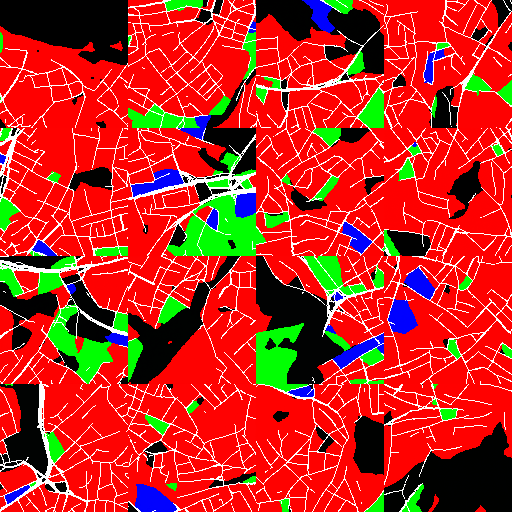

In [32]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Generate new samples

In [ ]:
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
images = pipeline(batch_size = config.eval_batch_size,
                  generator=torch.manual_seed(config.seed),).images